# ATLAS OmniFold - Technical Closure
In this notebook, we use a single a sample to perform a technical closure test (unfolding the sample against itself).

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
from omnifold import *

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

In [4]:
plot_setup()

In [5]:
# Global plot settings
import matplotlib.font_manager

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 22,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

### Utilities

In [7]:
# z-score standardization of data

def standardize(sim_truth, sim_reco, data_reco, dummyval=-99):
    scaler_truth = preprocessing.StandardScaler()
    scaler_reco = preprocessing.StandardScaler()

    scaler_truth.fit(
        sim_truth[sim_truth != dummyval].astype(float).reshape(-1, 1))
    scaler_reco.fit(
        np.concatenate(
            (sim_reco[sim_reco != dummyval],
             data_reco[data_reco != dummyval])).astype(float).reshape(-1, 1))

    sim_truth_z = np.copy(sim_truth.astype(float))
    sim_reco_z = np.copy(sim_reco.astype(float))
    data_reco_z = np.copy(data_reco.astype(float))

    sim_truth_z[sim_truth != dummyval] = np.squeeze(
        scaler_truth.transform(
            sim_truth[sim_truth != dummyval].astype(float).reshape(-1, 1)))
    sim_reco_z[sim_reco != dummyval] = np.squeeze(
        scaler_reco.transform(
            sim_reco[sim_reco != dummyval].astype(float).reshape(-1, 1)))
    data_reco_z[data_reco != dummyval] = np.squeeze(
        scaler_reco.transform(
            data_reco[data_reco != dummyval].astype(float).reshape(-1, 1)))

    return sim_truth_z, sim_reco_z, data_reco_z

In [8]:
plot_dir = './SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-TechnicalClosureTest/'

In [9]:
save_label0 = 'ATLASOmniFold-TechnicalClosureTest'

### Load ROOT files

In [10]:
data_dir = '/clusterfs/ml4hep/adisurtya/ATLASOmniFold/slimmedSamples/'

In [11]:
Events = uproot.lazy(
    data_dir +
    "ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root:OmniTree"
)

### Unpack data

In [12]:
# Event selection

mypass = (Events['pass190'].to_numpy().astype(bool)) | (
    Events['truth_pass190'].to_numpy().astype(bool))
mycut_truth = np.invert(
    Events['truth_pass190'].to_numpy().astype(bool))[mypass]
mycut_reco = np.invert(
    Events['pass190'].to_numpy().astype(bool))[mypass]

dummyval=-99

In [13]:
# Load Monte Carlo Event Weights
truth_weights_MC = np.array(Events['weight_mc'][mypass].to_list())
reco_weights_MC = np.array(Events['weight'][mypass].to_list())

# standardize
truth_weights_MC = truth_weights_MC / np.mean(truth_weights_MC)
reco_weights_MC = reco_weights_MC / np.mean(reco_weights_MC)

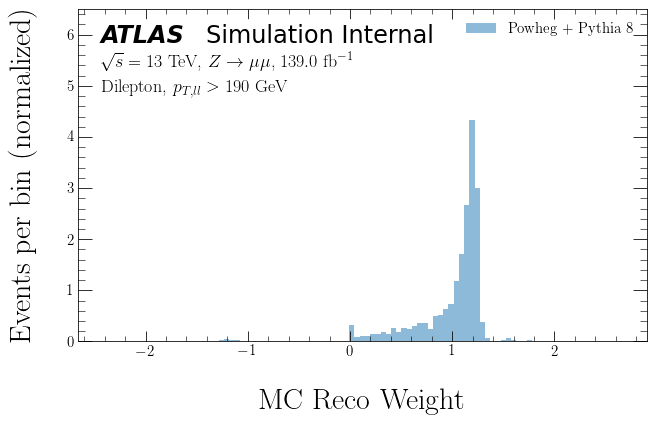

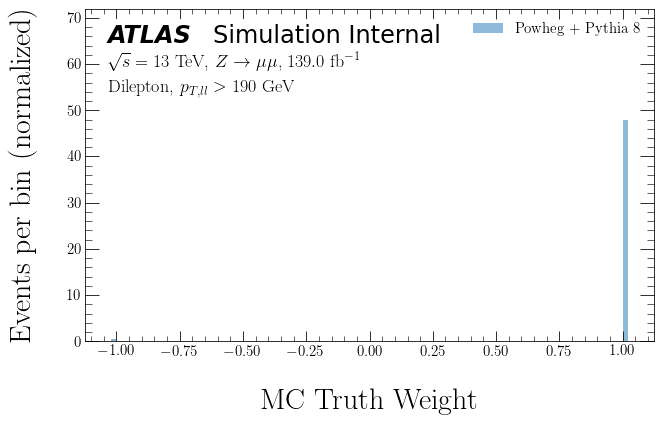

In [14]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_reco, _, _ = plt.hist(reco_weights_MC,
                             bins=np.linspace(np.min(reco_weights_MC), np.max(reco_weights_MC),100),
                             label=r'Powheg + Pythia 8',
                             **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max(hW_reco))
plt.legend()
draw_atlas_text()
plt.show()

plt.figure(figsize=(10, 6))
hW_truth, _, _ = plt.hist(truth_weights_MC,
                              bins=np.linspace(np.min(truth_weights_MC), np.max(truth_weights_MC),100),
                              label=r'Powheg + Pythia 8',
                              **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max(hW_truth))
plt.legend()
draw_atlas_text()
plt.show()

In [15]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]

plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

In [16]:
IBU_hists = uproot.open('/clusterfs/ml4hep/adisurtya/ATLASOmniFold/unfoldingPlotsJune14.root')

In [17]:
bins = []
for label in file_labels:
    bins += [IBU_hists['PowPy8_2018_'+label+'_Truth'].to_numpy()[1]]

In [18]:
labels_and_bins = zip(file_labels, plot_labels, bins)

obs = []

for file_label, plot_label, plot_bins in labels_and_bins:
    obs += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

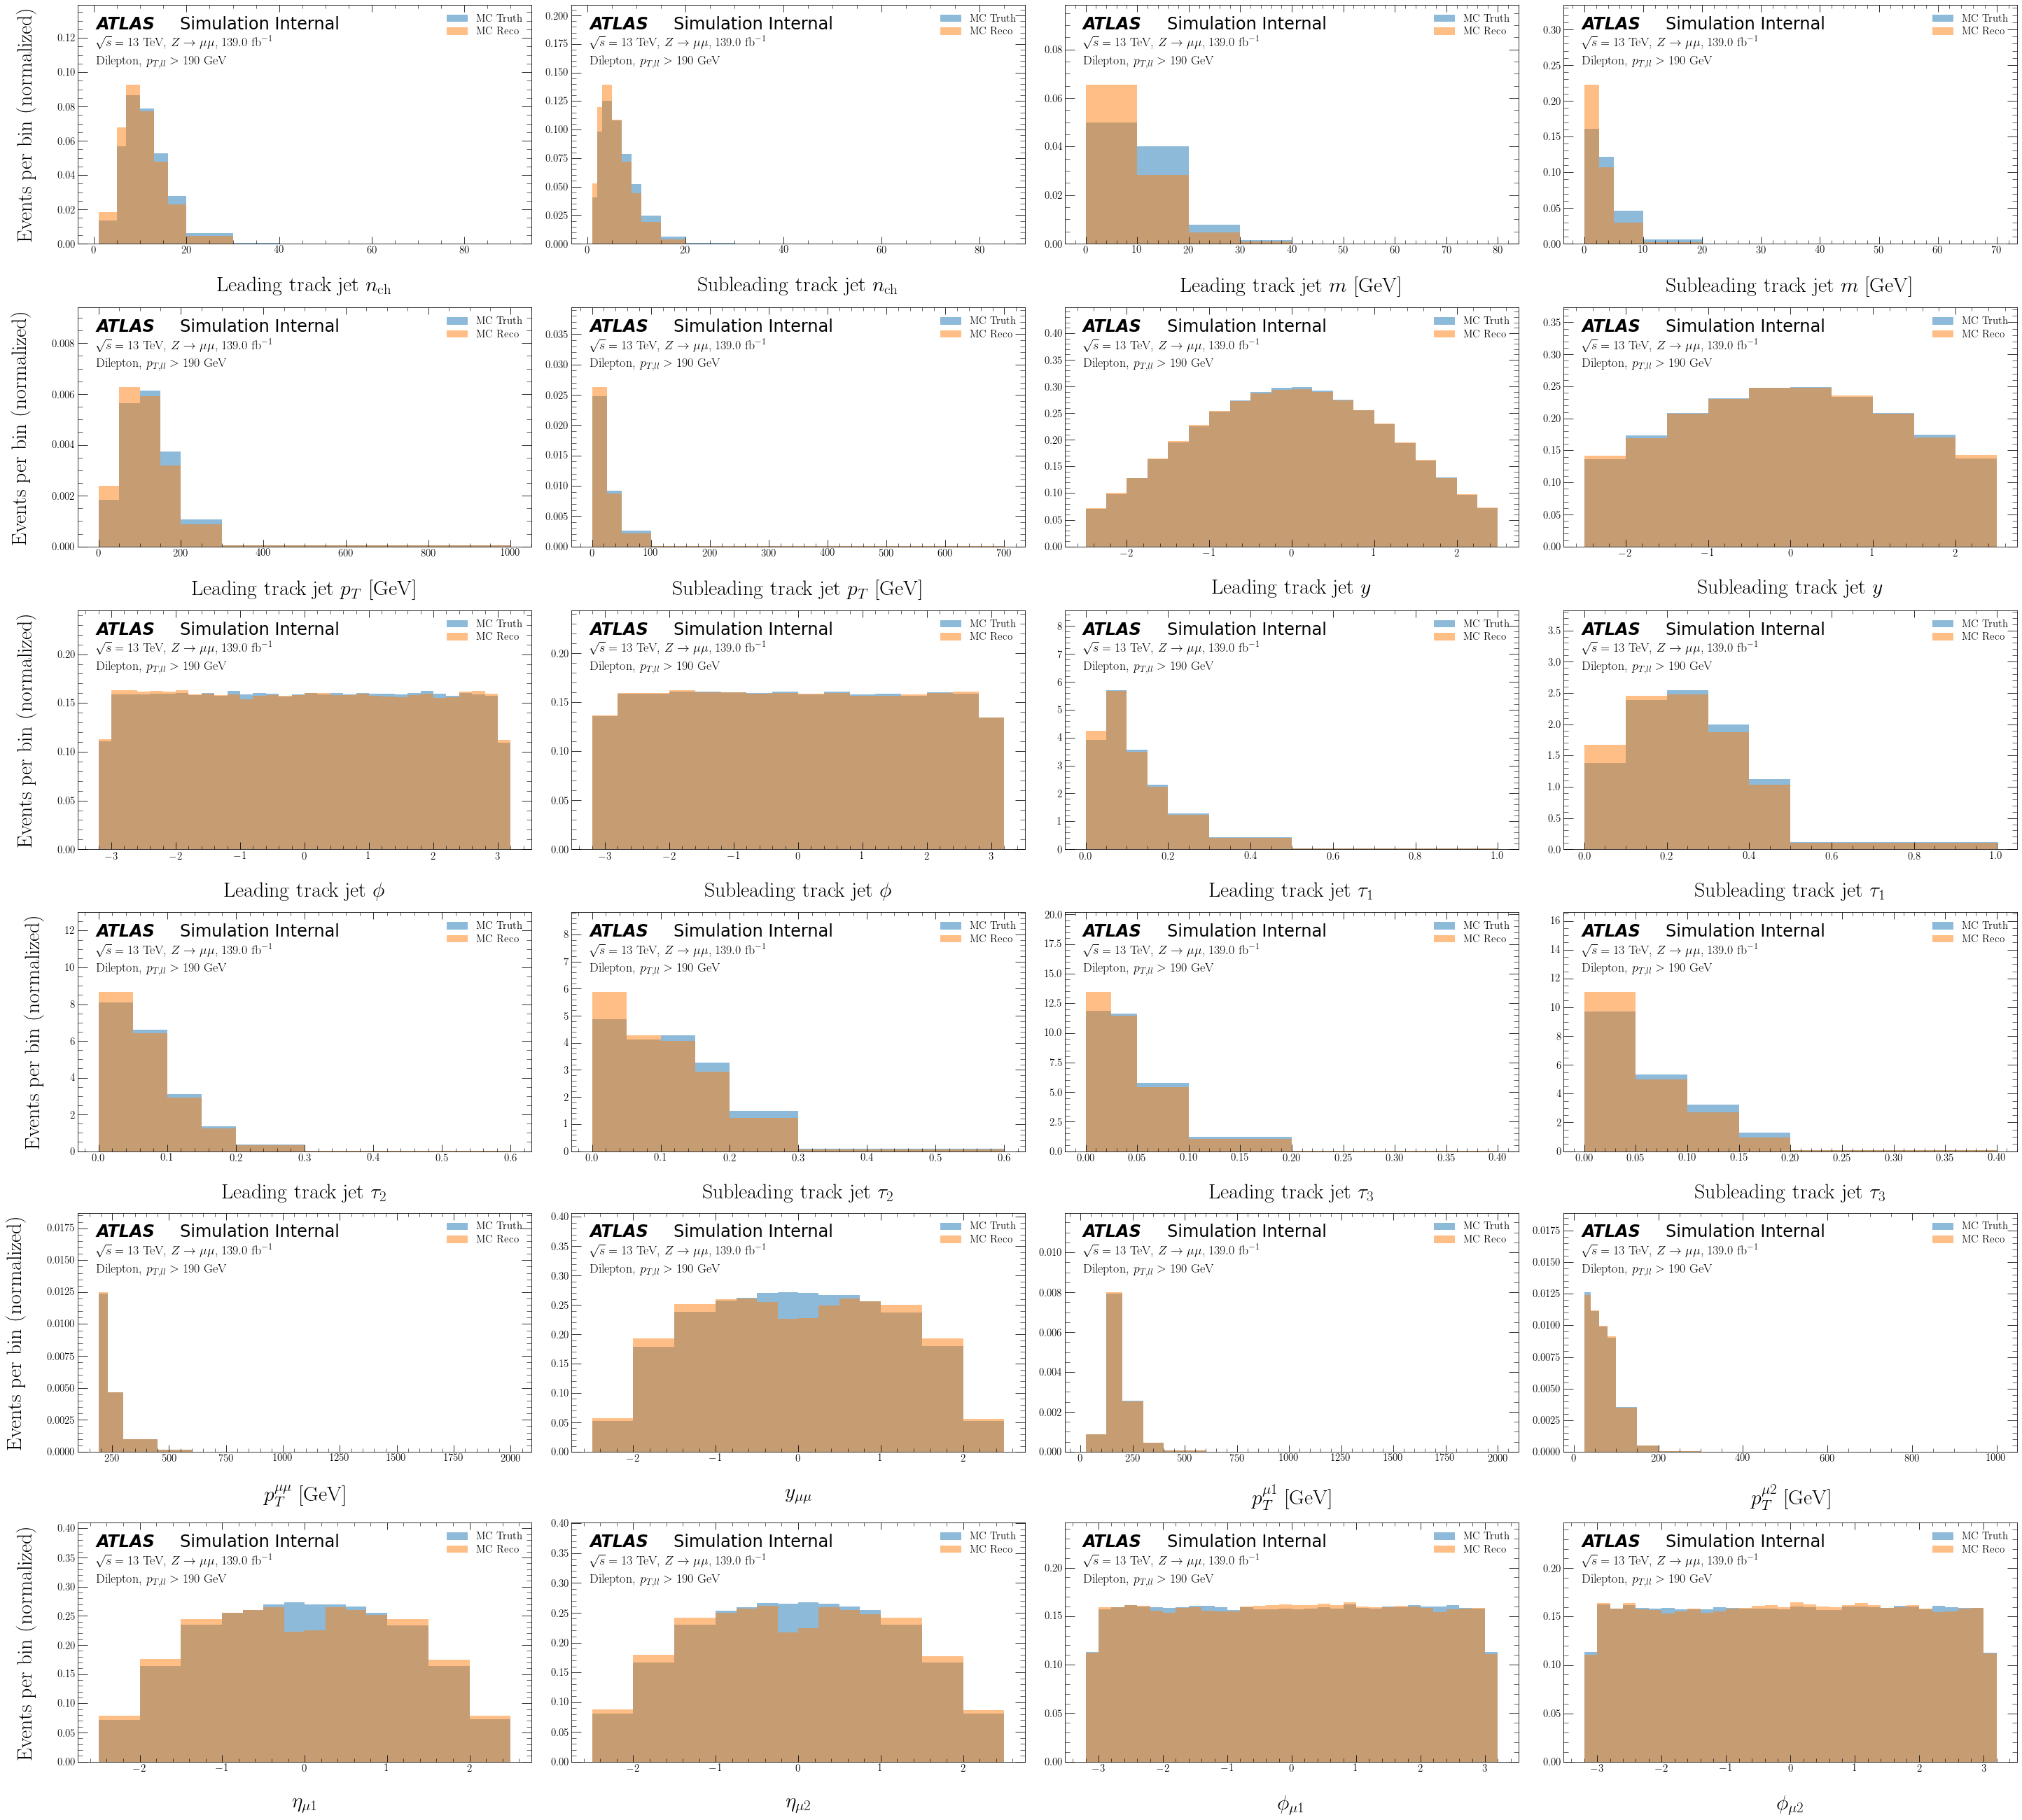

In [19]:
# Preview Observables

fig, ax = plt.subplots(6, 4, figsize=(40, 36), constrained_layout=True)
ax = np.ndarray.flatten(ax)

for i in range(len(obs)):
    bins = obs[i]['bins']
    hT, _, _ = ax[i].hist(
        Events['truth_' + obs[i]['file_label']][
            Events['truth_pass190'].to_numpy().astype(bool)],
        weights=Events['weight_mc'][
            Events['truth_pass190'].to_numpy().astype(bool)],
        bins=bins,
        label="MC Truth",
        **plot_style_2)
    hR, _, _ = ax[i].hist(Events[obs[i]['file_label']][
        Events['pass190'].to_numpy().astype(bool)],
                          weights=Events['weight'][
                              Events['pass190'].to_numpy().astype(bool)],
                          bins=bins,
                          label="MC Reco",
                          **plot_style_2)
    ax[i].set_xlabel(obs[i]['plot_label'])
    draw_atlas_text(ax=ax[i])
    if i % 4 == 0:
        ax[i].set_ylabel("Events per bin (normalized)")
    ax[i].legend()
    ax[i].set_ylim([0, 1.5 * max(max(hT), max(hR))])

# UniFold

To show unfolding of individual observables ("UniFold"), we will unfold the following observables for the leading track jet: the jet mass $m_{j_1}$, the number of constituents (tracks) $N_{j_1}$, the transverse momentum $p_{T,j_1}$, the rapidity $y_{j_1}$, and the $n$-subjettiness $\tau_{1, j_1}$.

## Unfold $N_{j_1}$

In [20]:
K.clear_session()

In [21]:
obs_index = 0    # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [22]:
truth = np.array(Events['truth_' +
                                   file_label][mypass].to_list())
truth[mycut_truth] = dummyval
reco = np.array(Events[file_label][mypass].to_list())
reco[mycut_reco] = dummyval

In [23]:
sim_truth, data_truth, sim_reco, data_reco, sim_truth_weights_MC, data_truth_weights_MC, sim_reco_weights_MC, data_reco_weights_MC = train_test_split(
    truth,
    reco,
    truth_weights_MC,
    reco_weights_MC,
    test_size=0.5)

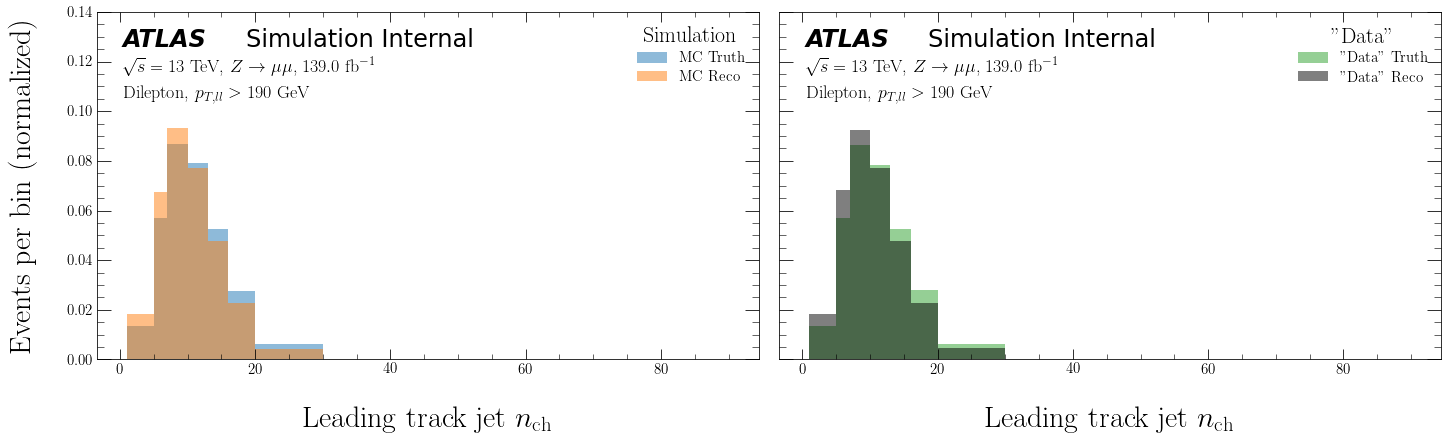

In [24]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [25]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [26]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)


ITERATION: 1

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.6942 - accuracy: 0.2523 - val_loss: 0.6916 - val_accuracy: 0.2518
Epoch 2/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.2531 - val_loss: 0.6917 - val_accuracy: 0.2518
Epoch 3/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.2537 - val_loss: 0.6915 - val_accuracy: 0.2503
Epoch 4/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.2522 - val_loss: 0.6916 - val_accuracy: 0.2511
Epoch 5/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.2524 - val_loss: 0.6915 - val_accuracy: 0.2511
Epoch 6/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.2524 - val_loss: 0.6915 - val_accuracy: 0.2510
Epoch 7/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.2523 - val_loss: 0.6916 - val_

Epoch 10/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.2507 - val_loss: 0.6919 - val_accuracy: 0.2521
Epoch 11/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.2534 - val_loss: 0.6919 - val_accuracy: 0.2504
Epoch 00011: early stopping

ITERATION: 2

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.2525 - val_loss: 0.6923 - val_accuracy: 0.2525
Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.2526 - val_loss: 0.6923 - val_accuracy: 0.2521
Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.2528 - val_loss: 0.6923 - val_accuracy: 0.2509
Epoch 4/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.2525 - val_loss: 0.6923 - val_accuracy: 0.2521
Epoch 5/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.

Epoch 00014: early stopping

ITERATION: 3

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.2519 - val_loss: 0.6930 - val_accuracy: 0.2496
Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2521 - val_loss: 0.6929 - val_accuracy: 0.2534
Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2523 - val_loss: 0.6929 - val_accuracy: 0.2539
Epoch 4/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2535 - val_loss: 0.6929 - val_accuracy: 0.2490
Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2522 - val_loss: 0.6929 - val_accuracy: 0.2539
Epoch 6/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2527 - val_loss: 0.6929 - val_accuracy: 0.2539
Epoch 7/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.25

#### Results

ITERATION 1:


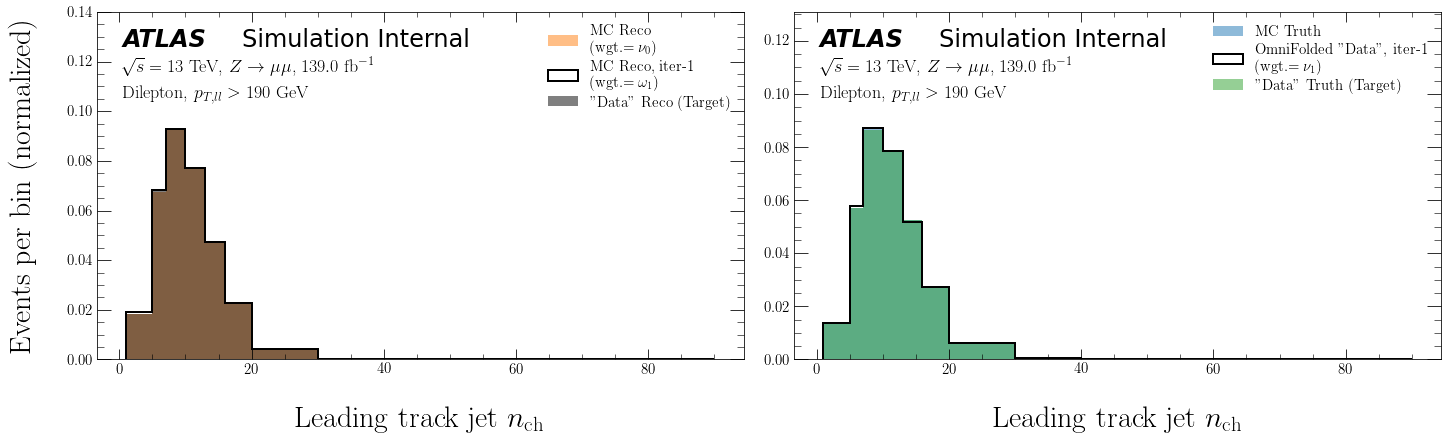

ITERATION 2:


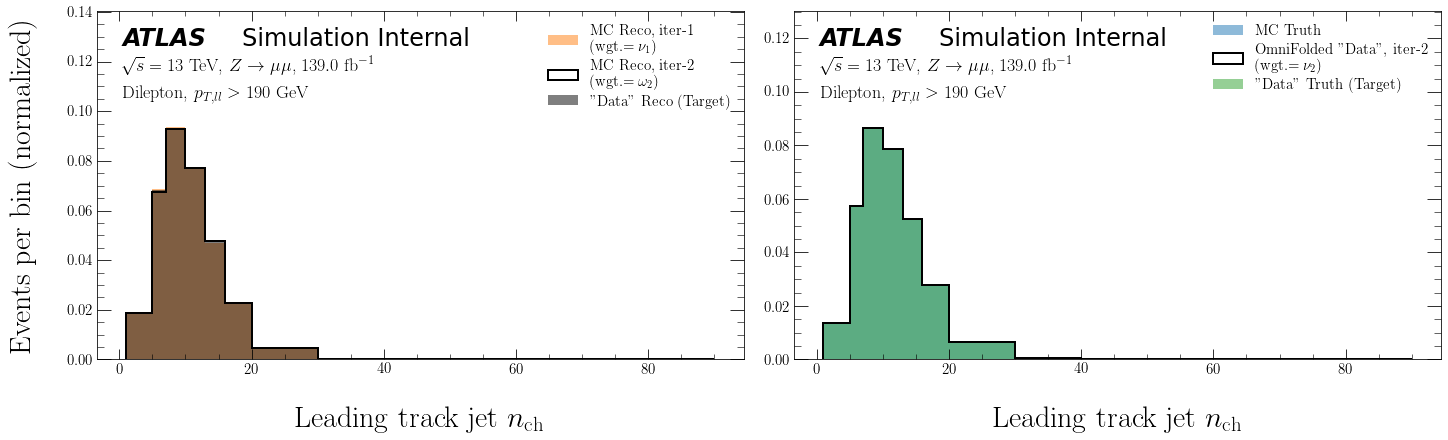

ITERATION 3:


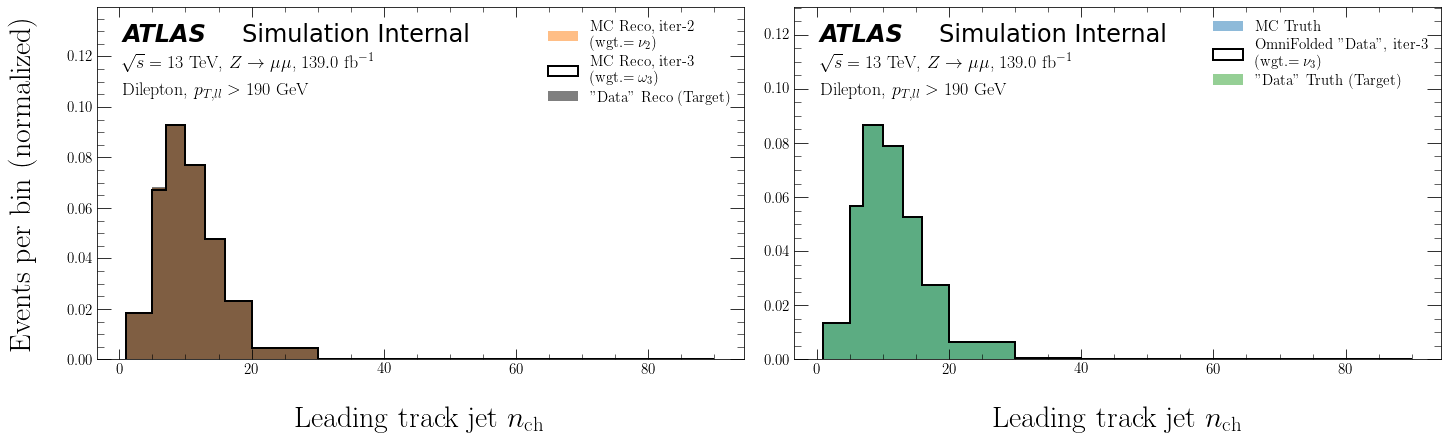

In [27]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

## Unfold $m_{j_1}$

In [28]:
K.clear_session()

In [29]:
obs_index = 2  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [30]:
truth = np.array(Events['truth_' +
                                   file_label][mypass].to_list())
truth[mycut_truth] = dummyval
reco = np.array(Events[file_label][mypass].to_list())
reco[mycut_reco] = dummyval

In [31]:
sim_truth, data_truth, sim_reco, data_reco, sim_truth_weights_MC, data_truth_weights_MC, sim_reco_weights_MC, data_reco_weights_MC = train_test_split(
    truth,
    reco,
    truth_weights_MC,
    reco_weights_MC,
    test_size=0.5)

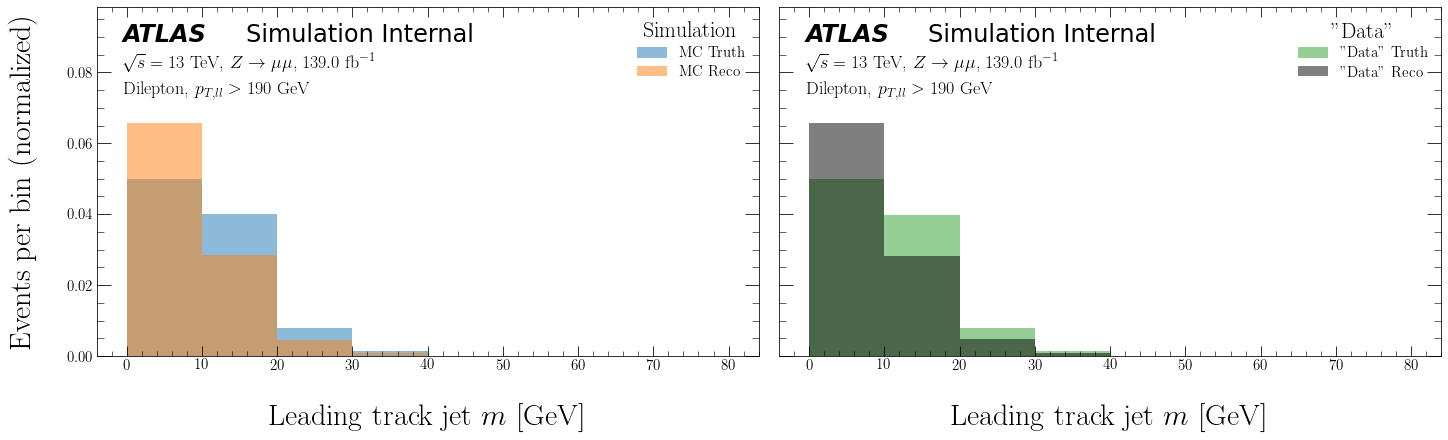

In [32]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [33]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [34]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)


ITERATION: 1

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.6937 - accuracy: 0.2518 - val_loss: 0.6932 - val_accuracy: 0.2519
Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2514 - val_loss: 0.6931 - val_accuracy: 0.2537
Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2524 - val_loss: 0.6931 - val_accuracy: 0.2523
Epoch 4/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2521 - val_loss: 0.6931 - val_accuracy: 0.2518
Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2517 - val_loss: 0.6931 - val_accuracy: 0.2510
Epoch 6/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2527 - val_loss: 0.6931 - val_accuracy: 0.2537
Epoch 7/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2520 - val_loss: 0.6931 - val_

Epoch 21/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6936 - val_accuracy: 0.2500
Epoch 00021: early stopping

STEP 2b

Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.2524 - val_loss: 0.6927 - val_accuracy: 0.2535
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.2534 - val_loss: 0.6927 - val_accuracy: 0.2533
Epoch 3/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.2533 - val_loss: 0.6926 - val_accuracy: 0.2537
Epoch 4/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.2519 - val_loss: 0.6927 - val_accuracy: 0.2534
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.2536 - val_loss: 0.6926 - val_accuracy: 0.2538
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.2533 - val_los

30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2502 - val_loss: 0.6930 - val_accuracy: 0.2491
Epoch 8/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2503 - val_loss: 0.6930 - val_accuracy: 0.2492
Epoch 9/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2496 - val_loss: 0.6930 - val_accuracy: 0.2496
Epoch 10/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2494 - val_loss: 0.6930 - val_accuracy: 0.2492
Epoch 11/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2502 - val_loss: 0.6930 - val_accuracy: 0.2492
Epoch 12/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2496 - val_loss: 0.6930 - val_accuracy: 0.2492
Epoch 13/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2503 - val_loss: 0.6930 - val_accuracy: 0.2492
Epoch 14/1000
3


STEP 1b

Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.2494 - val_loss: 0.6940 - val_accuracy: 0.2490
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.2496 - val_loss: 0.6940 - val_accuracy: 0.2490
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.2503 - val_loss: 0.6940 - val_accuracy: 0.2489
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.2503 - val_loss: 0.6940 - val_accuracy: 0.2489
Epoch 5/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.2497 - val_loss: 0.6940 - val_accuracy: 0.2502
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.2499 - val_loss: 0.6940 - val_accuracy: 0.2490
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6940 - val_accuracy: 0.2

#### Results

ITERATION 1:


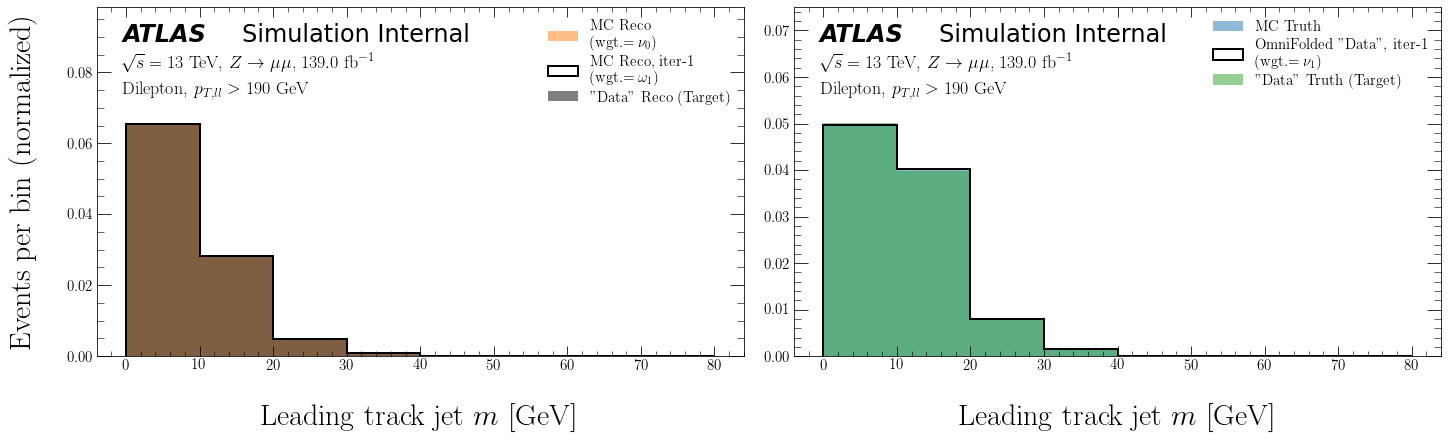

ITERATION 2:


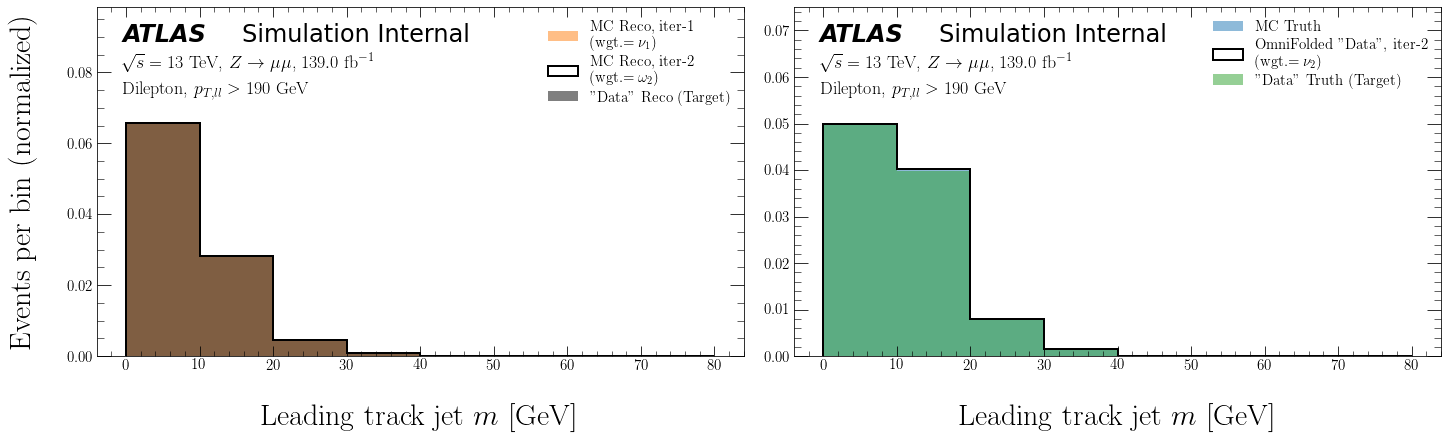

ITERATION 3:


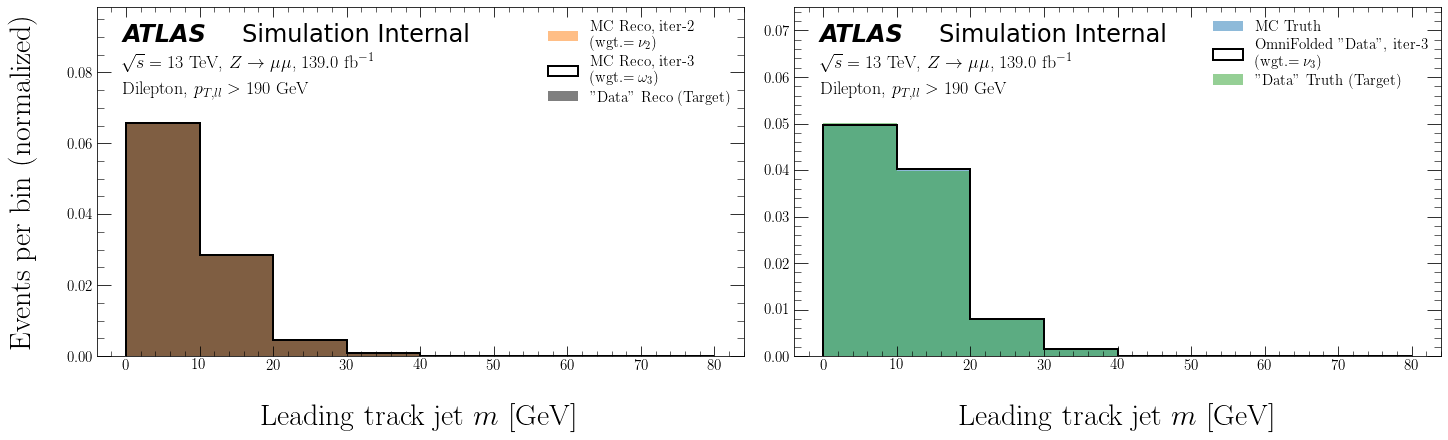

In [35]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

## Unfold $p_{T, j_1}$

In [36]:
K.clear_session()

In [37]:
obs_index = 4  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [38]:
truth = np.array(Events['truth_' +
                                   file_label][mypass].to_list())
truth[mycut_truth] = dummyval
reco = np.array(Events[file_label][mypass].to_list())
reco[mycut_reco] = dummyval

In [39]:
sim_truth, data_truth, sim_reco, data_reco, sim_truth_weights_MC, data_truth_weights_MC, sim_reco_weights_MC, data_reco_weights_MC = train_test_split(
    truth,
    reco,
    truth_weights_MC,
    reco_weights_MC,
    test_size=0.5)

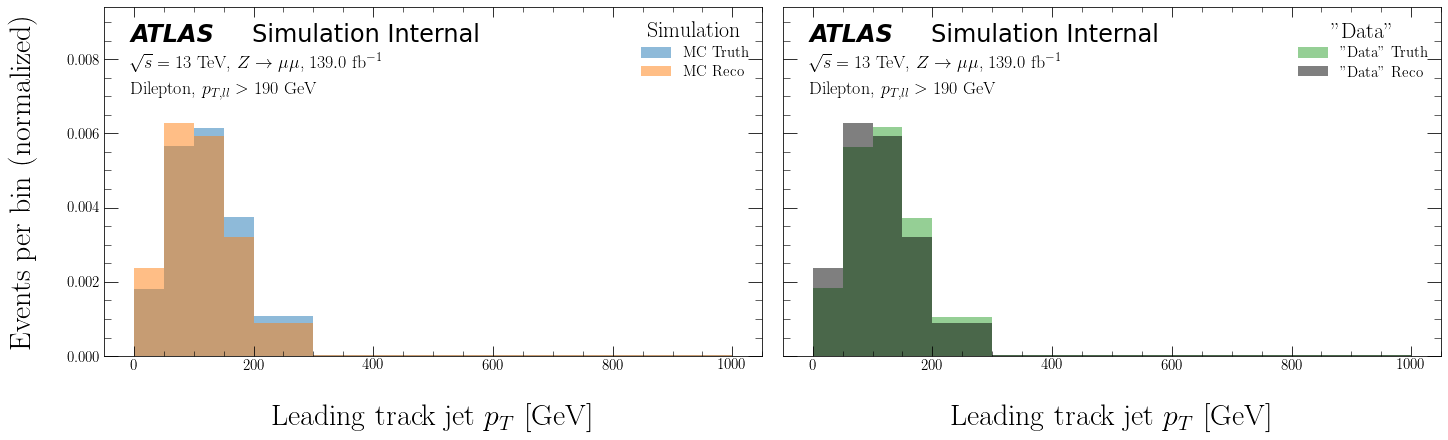

In [40]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [41]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [42]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)


ITERATION: 1

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.2517 - val_loss: 0.6931 - val_accuracy: 0.2542
Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2519 - val_loss: 0.6931 - val_accuracy: 0.2494
Epoch 3/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2502 - val_loss: 0.6931 - val_accuracy: 0.2511
Epoch 4/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2515 - val_loss: 0.6931 - val_accuracy: 0.2494
Epoch 5/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2503 - val_loss: 0.6932 - val_accuracy: 0.2494
Epoch 6/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2501 - val_loss: 0.6931 - val_accuracy: 0.2495
Epoch 7/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2527 - val_loss: 0.6931 - val_

Epoch 19/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2500 - val_loss: 0.6933 - val_accuracy: 0.2497
Epoch 20/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2499 - val_loss: 0.6933 - val_accuracy: 0.2495
Epoch 21/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2500 - val_loss: 0.6933 - val_accuracy: 0.2499
Epoch 22/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.2498 - val_loss: 0.6934 - val_accuracy: 0.2500
Epoch 00022: early stopping

STEP 2b

Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.2502 - val_loss: 0.6940 - val_accuracy: 0.2495
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.2502 - val_loss: 0.6940 - val_accuracy: 0.2495
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6945 - accuracy: 0.2502 - val_

Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.2499 - val_loss: 0.6944 - val_accuracy: 0.2488
Epoch 11/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.2492 - val_loss: 0.6944 - val_accuracy: 0.2495
Epoch 12/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.2497 - val_loss: 0.6944 - val_accuracy: 0.2490
Epoch 13/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.2500 - val_loss: 0.6944 - val_accuracy: 0.2494
Epoch 00013: early stopping

STEP 2

Epoch 1/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.2498 - val_loss: 0.6935 - val_accuracy: 0.2483
Epoch 2/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2494 - val_loss: 0.6935 - val_accuracy: 0.2485
Epoch 3/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.2504 - val_l

Epoch 9/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.2510 - val_loss: 0.6935 - val_accuracy: 0.2504
Epoch 10/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.2510 - val_loss: 0.6935 - val_accuracy: 0.2533
Epoch 11/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.2507 - val_loss: 0.6935 - val_accuracy: 0.2504
Epoch 12/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.2535 - val_loss: 0.6935 - val_accuracy: 0.2533
Epoch 13/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.2538 - val_loss: 0.6935 - val_accuracy: 0.2533
Epoch 00013: early stopping

STEP 1b

Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2489
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.2499 - val_

#### Results

ITERATION 1:


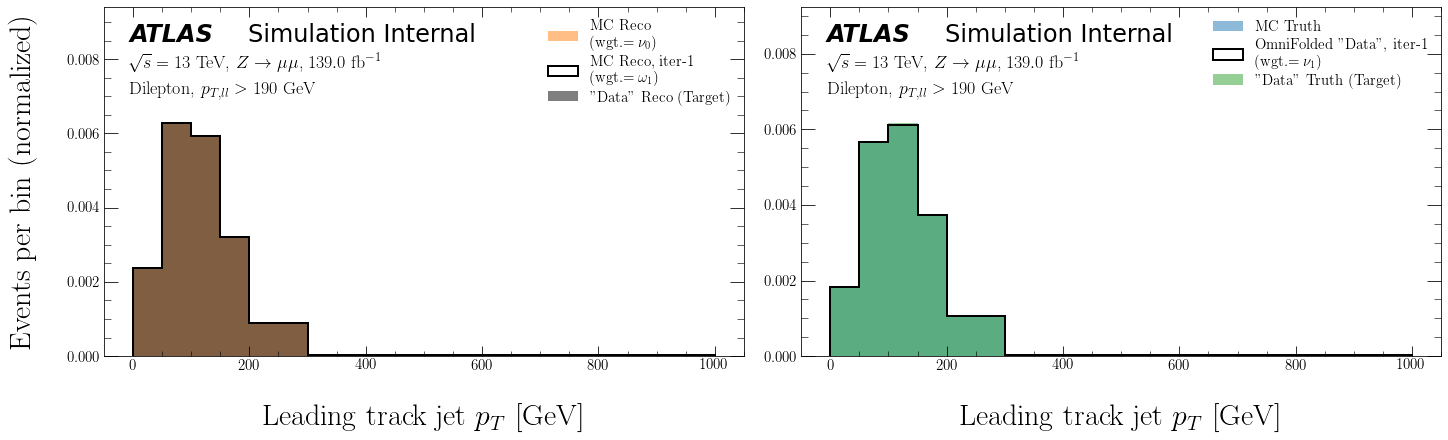

ITERATION 2:


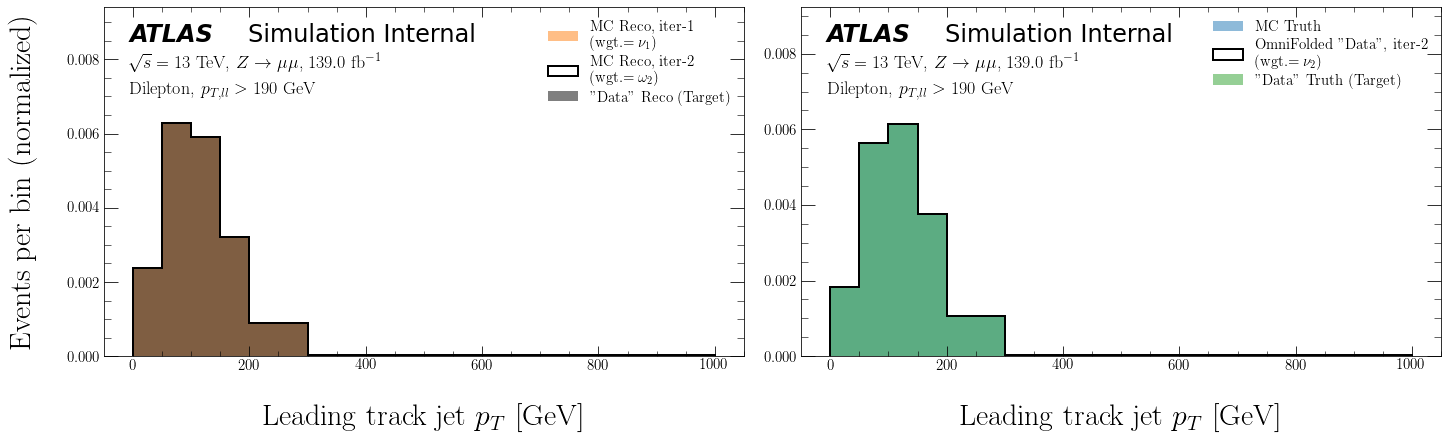

ITERATION 3:


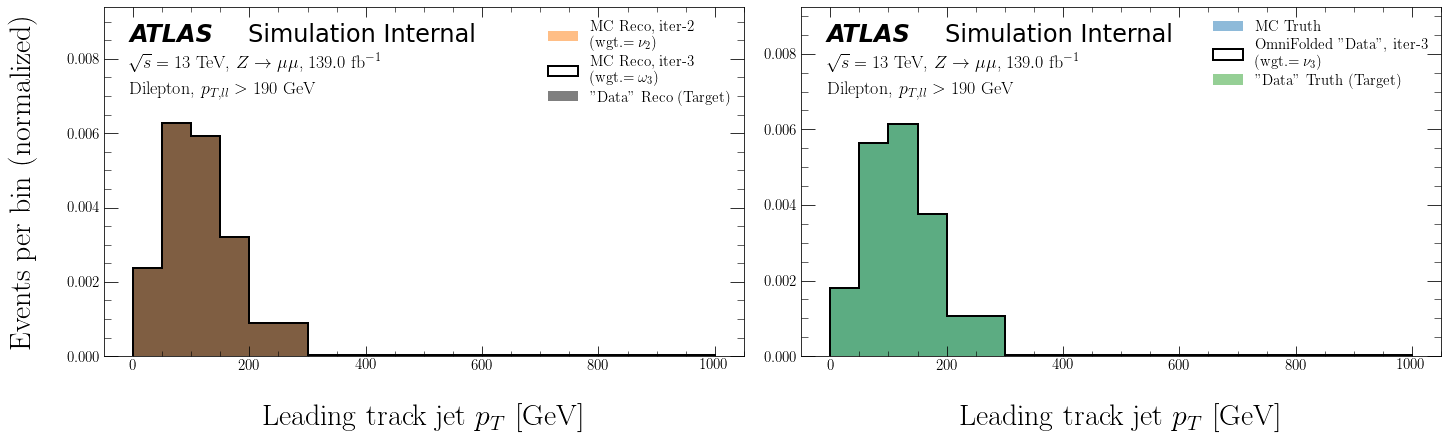

In [43]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

## Unfold $y_{j_1}$

In [44]:
K.clear_session()

In [45]:
obs_index = 6  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [46]:
truth = np.array(Events['truth_' +
                                   file_label][mypass].to_list())
truth[mycut_truth] = dummyval
reco = np.array(Events[file_label][mypass].to_list())
reco[mycut_reco] = dummyval

In [47]:
sim_truth, data_truth, sim_reco, data_reco, sim_truth_weights_MC, data_truth_weights_MC, sim_reco_weights_MC, data_reco_weights_MC = train_test_split(
    truth,
    reco,
    truth_weights_MC,
    reco_weights_MC,
    test_size=0.5)

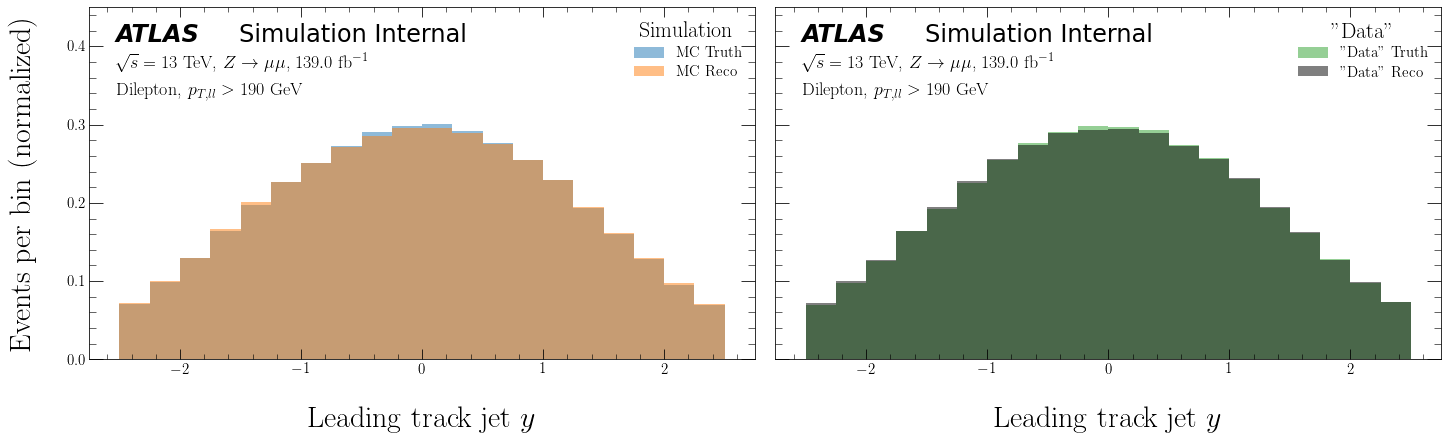

In [48]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [49]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [50]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)


ITERATION: 1

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.2535 - val_loss: 0.6943 - val_accuracy: 0.2536
Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.2527 - val_loss: 0.6943 - val_accuracy: 0.2519
Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.2514 - val_loss: 0.6943 - val_accuracy: 0.2527
Epoch 4/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.2526 - val_loss: 0.6943 - val_accuracy: 0.2518
Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.2521 - val_loss: 0.6943 - val_accuracy: 0.2503
Epoch 6/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.2525 - val_loss: 0.6943 - val_accuracy: 0.2508
Epoch 7/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.2526 - val_loss: 0.6943 - val_

Epoch 25/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2492
Epoch 26/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.2502 - val_loss: 0.6936 - val_accuracy: 0.2497
Epoch 27/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.2500 - val_loss: 0.6936 - val_accuracy: 0.2495
Epoch 28/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.2495 - val_loss: 0.6936 - val_accuracy: 0.2498
Epoch 00028: early stopping

STEP 2b

Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.2524 - val_loss: 0.6920 - val_accuracy: 0.2526
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.2528 - val_loss: 0.6920 - val_accuracy: 0.2519
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.2530 - val_

30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2490
Epoch 8/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2494
Epoch 9/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.2502 - val_loss: 0.6927 - val_accuracy: 0.2490
Epoch 10/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.2497 - val_loss: 0.6927 - val_accuracy: 0.2490
Epoch 11/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6927 - val_accuracy: 0.2491
Epoch 12/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2503 - val_loss: 0.6927 - val_accuracy: 0.2492
Epoch 00012: early stopping

STEP 2b

Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.2520 - val_loss: 0.6938 -

30/30 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.2496 - val_loss: 0.6928 - val_accuracy: 0.2488
Epoch 2/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2504 - val_loss: 0.6928 - val_accuracy: 0.2491
Epoch 3/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6928 - val_accuracy: 0.2488
Epoch 4/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.2506 - val_loss: 0.6928 - val_accuracy: 0.2489
Epoch 5/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2505 - val_loss: 0.6928 - val_accuracy: 0.2487
Epoch 6/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.2504 - val_loss: 0.6928 - val_accuracy: 0.2491
Epoch 7/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.2503 - val_loss: 0.6928 - val_accuracy: 0.2486
Epoch 8/1000
30/30 

#### Results

ITERATION 1:


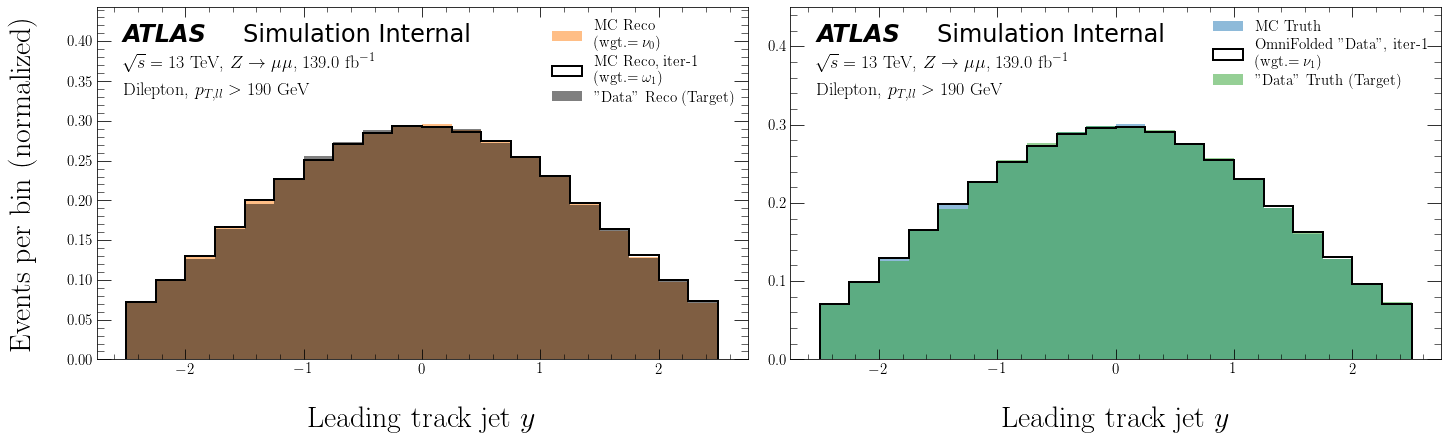

ITERATION 2:


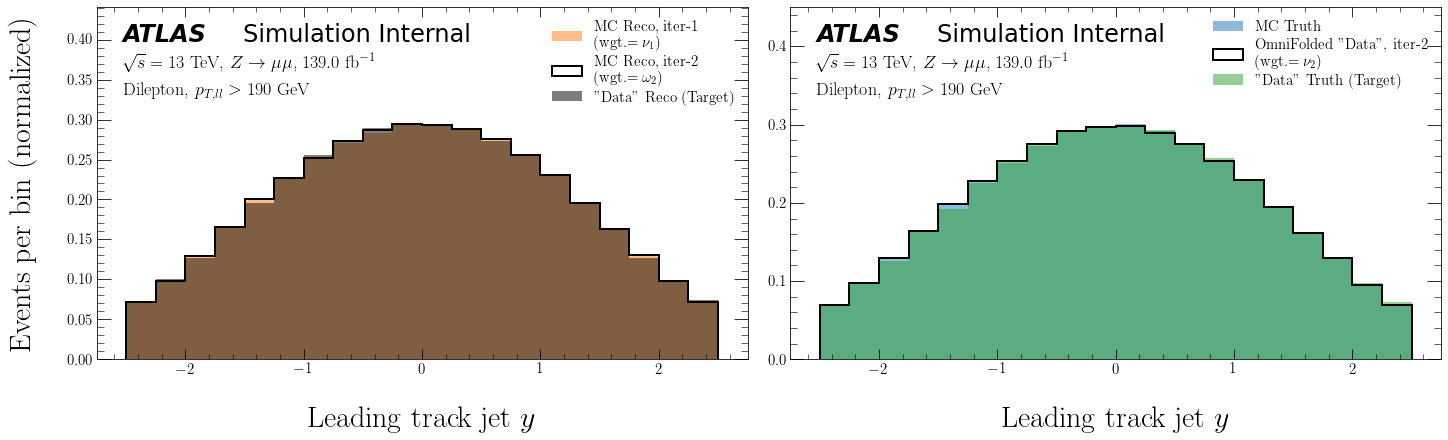

ITERATION 3:


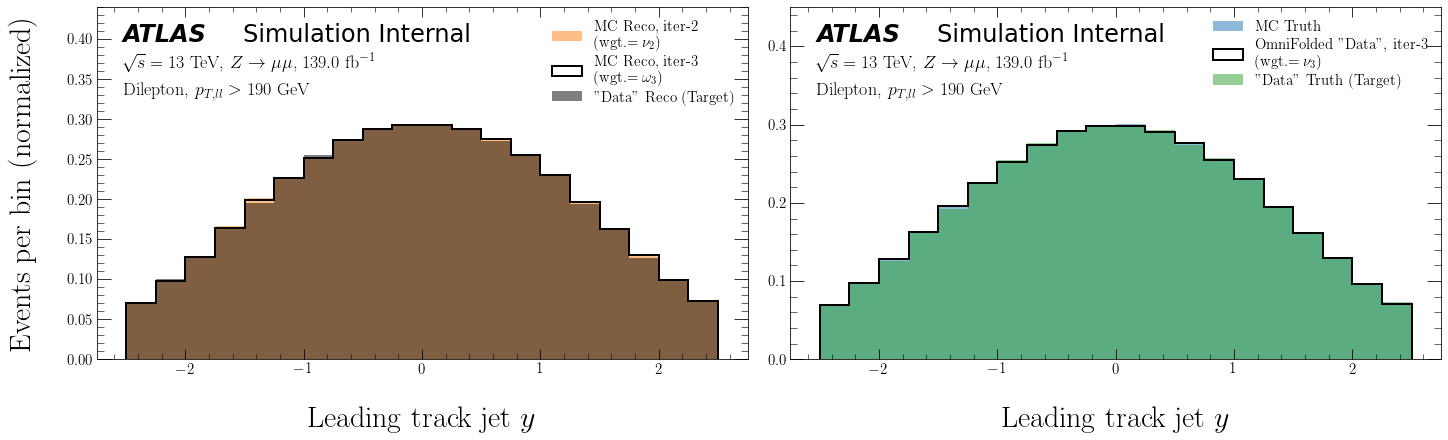

In [51]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

## Unfold $\tau _{j_1}$

In [52]:
K.clear_session()

In [53]:
obs_index = 10  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [54]:
truth = np.array(Events['truth_' +
                                   file_label][mypass].to_list())
truth[mycut_truth] = dummyval
reco = np.array(Events[file_label][mypass].to_list())
reco[mycut_reco] = dummyval

In [55]:
sim_truth, data_truth, sim_reco, data_reco, sim_truth_weights_MC, data_truth_weights_MC, sim_reco_weights_MC, data_reco_weights_MC = train_test_split(
    truth,
    reco,
    truth_weights_MC,
    reco_weights_MC,
    test_size=0.5)

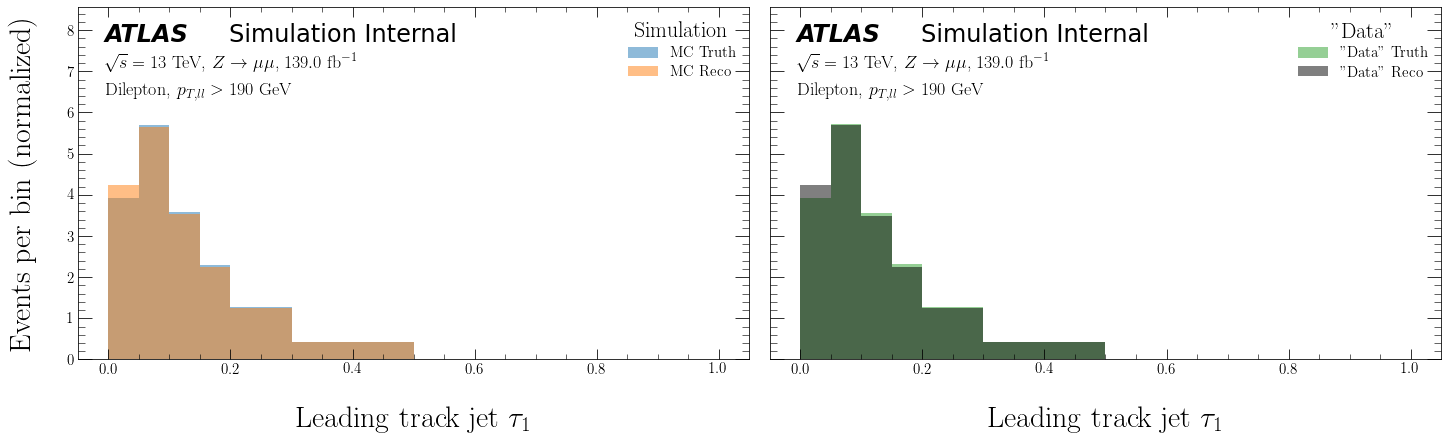

In [56]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [57]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [58]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)


ITERATION: 1

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.2516 - val_loss: 0.6938 - val_accuracy: 0.2525
Epoch 2/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2520 - val_loss: 0.6938 - val_accuracy: 0.2537
Epoch 3/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.2519 - val_loss: 0.6938 - val_accuracy: 0.2512
Epoch 4/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2513 - val_loss: 0.6938 - val_accuracy: 0.2514
Epoch 5/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.2518 - val_loss: 0.6938 - val_accuracy: 0.2531
Epoch 6/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.2530 - val_loss: 0.6939 - val_accuracy: 0.2505
Epoch 7/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.2515 - val_loss: 0.6938 - val_

Epoch 11/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.2512 - val_loss: 0.6949 - val_accuracy: 0.2510
Epoch 00011: early stopping

ITERATION: 2

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.2533 - val_loss: 0.6933 - val_accuracy: 0.2527
Epoch 2/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2534 - val_loss: 0.6933 - val_accuracy: 0.2513
Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2519 - val_loss: 0.6934 - val_accuracy: 0.2524
Epoch 4/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2539 - val_loss: 0.6933 - val_accuracy: 0.2517
Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.2535 - val_loss: 0.6933 - val_accuracy: 0.2512
Epoch 6/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.2

26/26 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.2521 - val_loss: 0.6930 - val_accuracy: 0.2525
Epoch 4/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2511 - val_loss: 0.6930 - val_accuracy: 0.2527
Epoch 5/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2517 - val_loss: 0.6930 - val_accuracy: 0.2516
Epoch 6/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2517 - val_loss: 0.6930 - val_accuracy: 0.2512
Epoch 7/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2512 - val_loss: 0.6930 - val_accuracy: 0.2524
Epoch 8/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2521 - val_loss: 0.6930 - val_accuracy: 0.2525
Epoch 9/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2523 - val_loss: 0.6930 - val_accuracy: 0.2529
Epoch 10/1000
26/26

Epoch 00016: early stopping


#### Results

ITERATION 1:


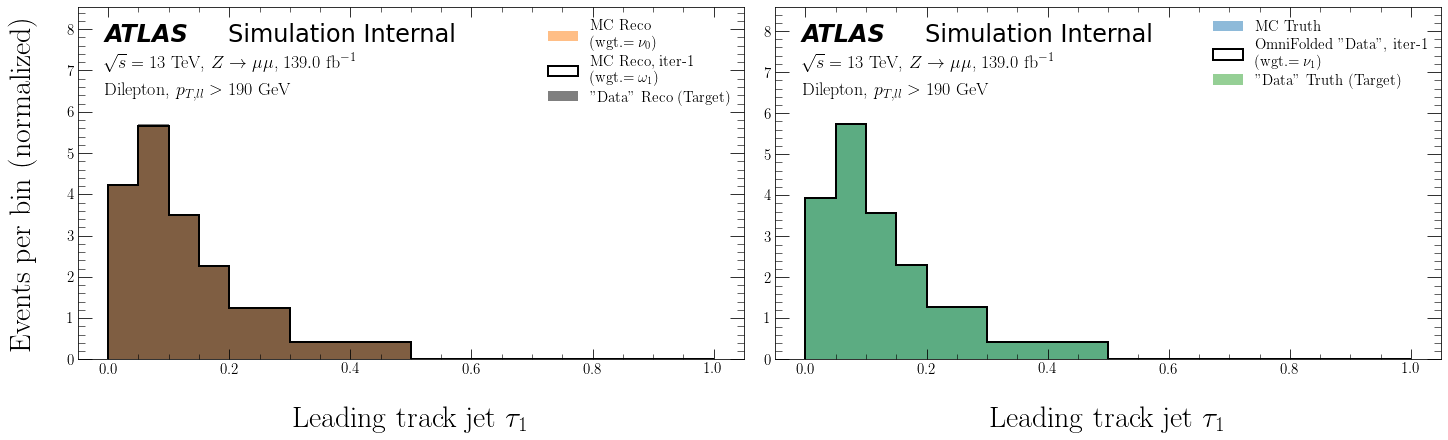

ITERATION 2:


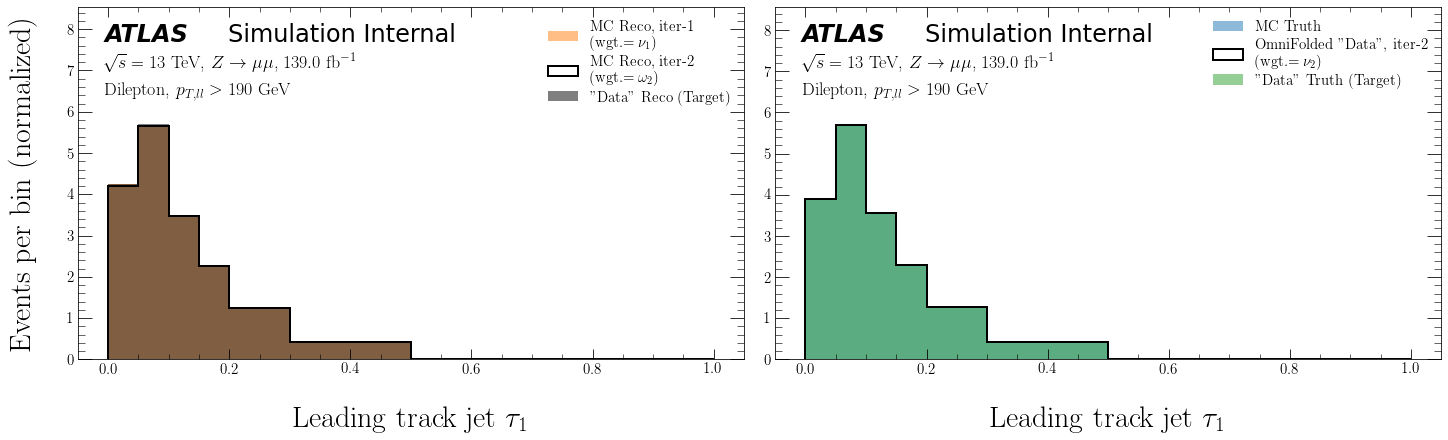

ITERATION 3:


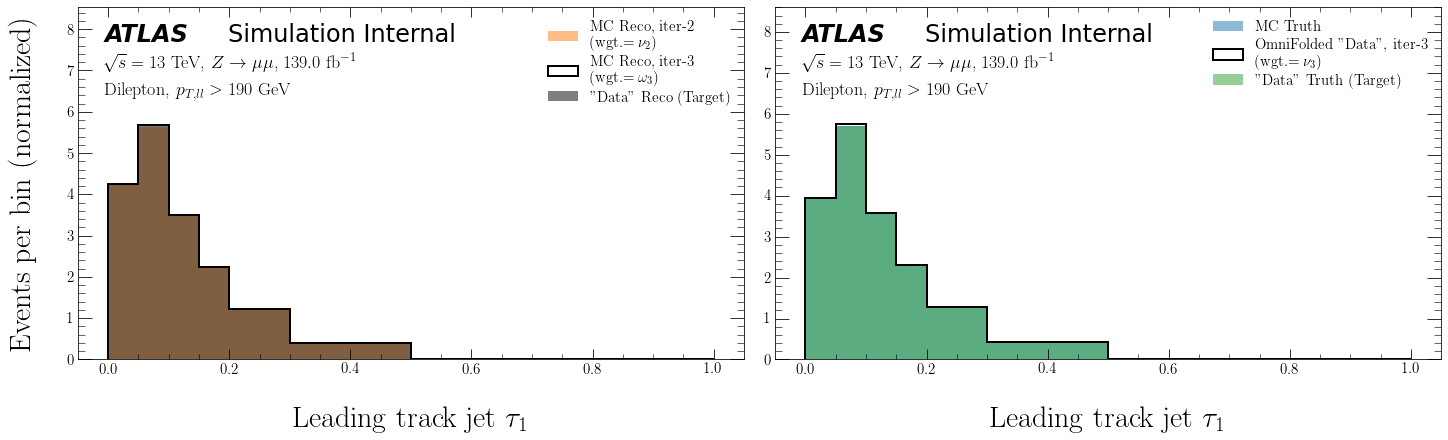

In [59]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

# MultiFold

To show unfolding of multiple observables simultaneously ("MultiFold"), we will unfold the following observables together: the leading jet number of constituents (tracks) $N_{j_1}$, the leading jet mass $m_{j_1}$,  the leading jet transverse momentum $p_{T,j_1}$, the leading jet rapidity $y_{j_1}$, the leading jet azimuthal angle $\phi_{j_1}$, the leading jet $n$-subjettiness ($\tau_{1, j_1}$, $\tau_{2, j_1}$, $\tau_{3, j_1}$), the subleading jet number of constituents (tracks) $N_{j_2}$, the subleading jet mass $m_{j_2}$,  the subleading jet transverse momentum $p_{T,j_2}$, the subleading jet rapidity $y_{j_2}$, the subleading jet azimuthal angle $\phi_{j_2}$, the subleading jet $n$-subjettiness ($\tau_{1, j_2}$, $\tau_{2, j_2}$, $\tau_{3, j_2}$), the dilepton transverse momentum $p_{T,ll}$, the dilepton rapidity $y_{ll}$, the leading lepton transverse momentum $p_{T,l_1}$, the leading lepton pseudorapidity $\eta_{l_1}$, the leading lepton azimuthal angle $\phi_{l_1}$, the subleading lepton transverse momentum $p_{T,l_2}$, the subleading lepton pseudorapidity $\eta_{l_2}$, and the subleading lepton azimuthal angle $\phi_{l_2}$ for a total of **24 observables**.

In [60]:
K.clear_session()

## Setup datasets

In [61]:
sim, data = train_test_split(np.arange(np.sum(mypass)), test_size=0.5)

In [62]:
sim_truth = [None] * len(obs)
sim_reco = [None] * len(obs)
data_truth = [None] * len(obs)
data_reco = [None] * len(obs)

In [63]:
for i in range(len(obs)):
    file_label = obs[i]['file_label']
    
    truth = np.array(Events['truth_' +
                                       file_label][mypass].to_list())
    truth[mycut_truth] = dummyval
    reco = np.array(Events[file_label][mypass].to_list())
    reco[mycut_reco] = dummyval 

    sim_truth[i] = truth[sim]
    sim_reco[i] = reco[sim]
    data_truth[i] = truth[data]
    data_reco[i] = reco[data]

sim_truth_weights_MC = truth_weights_MC[sim]
sim_reco_weights_MC = reco_weights_MC[sim]
data_truth_weights_MC = truth_weights_MC[data]
data_reco_weights_MC = reco_weights_MC[data]

/global/home/users/adisurtya/ATLASOmniFold/omnifold/plot.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,


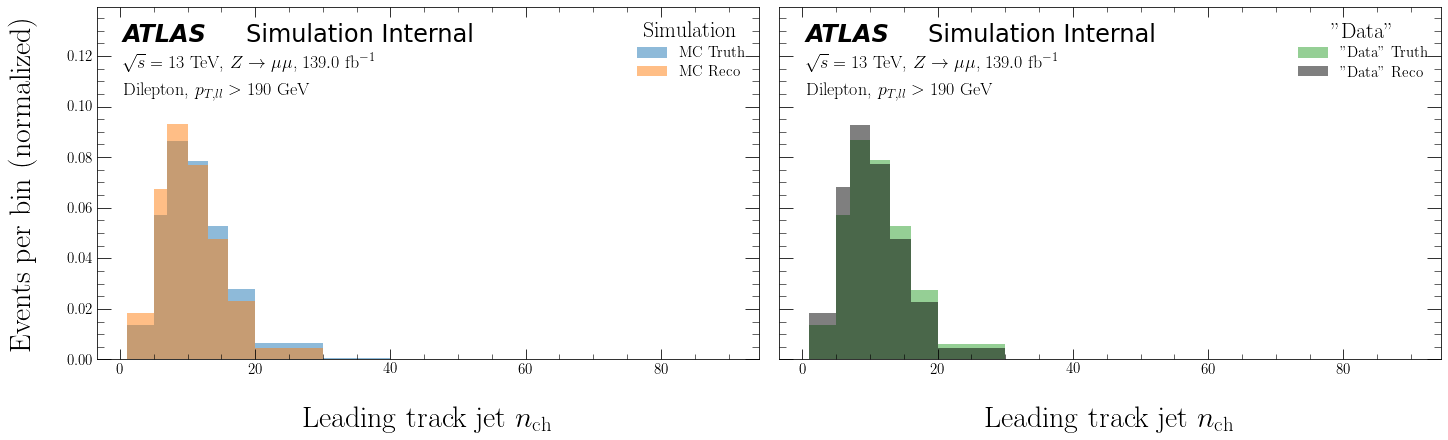

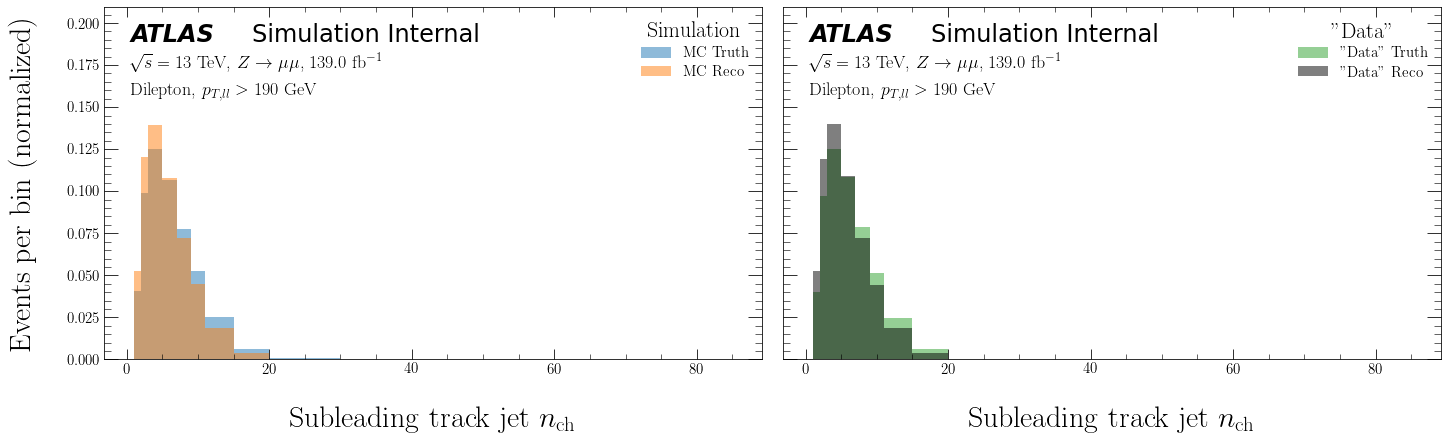

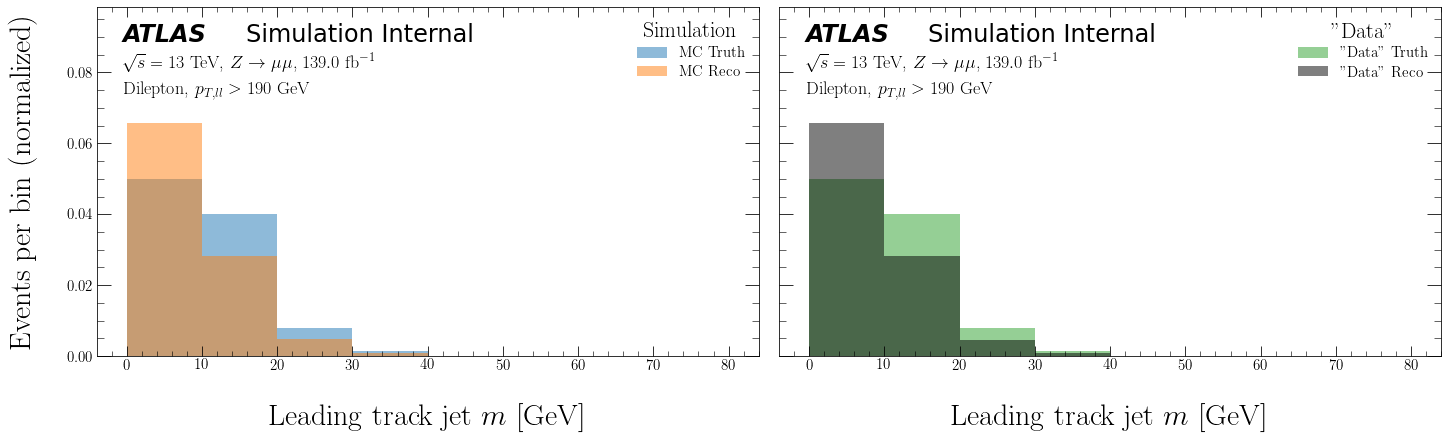

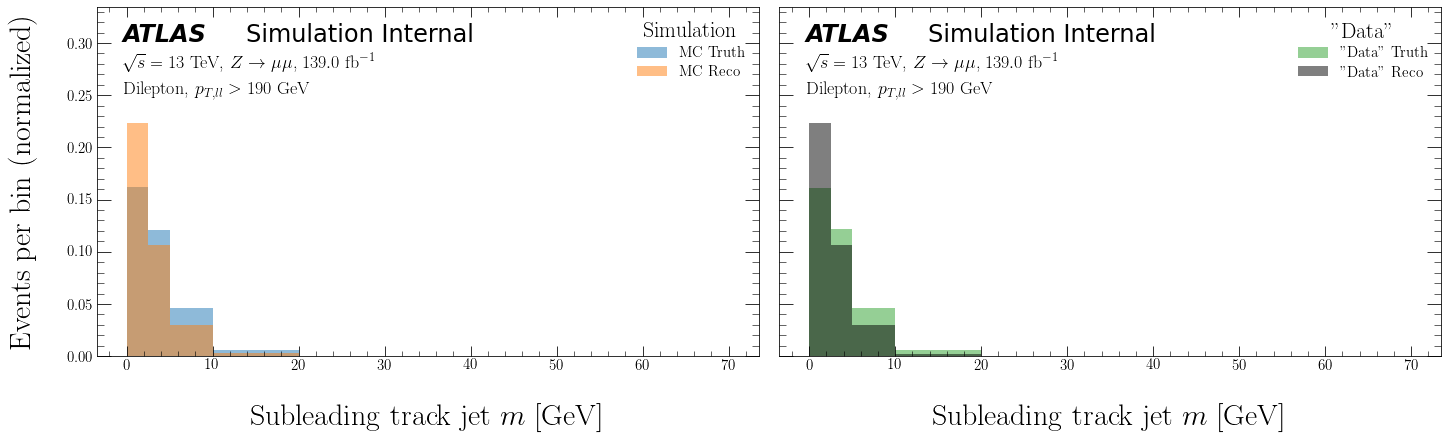

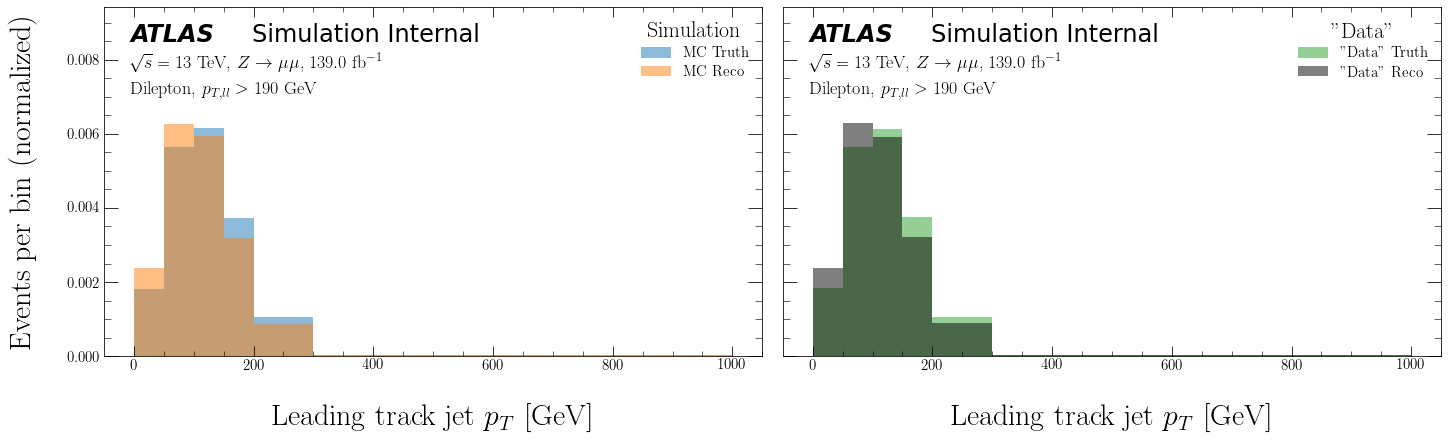

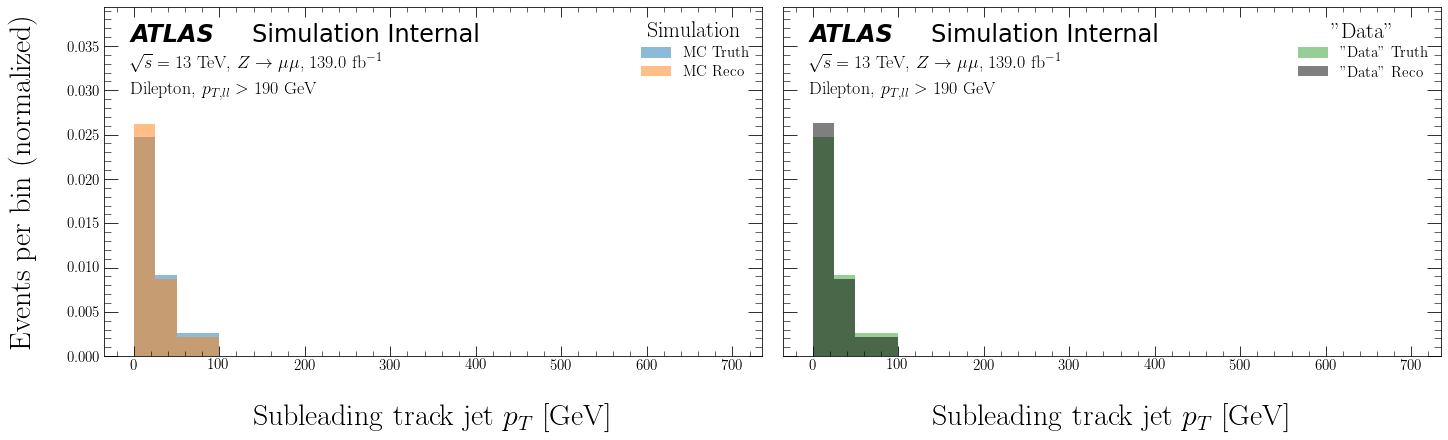

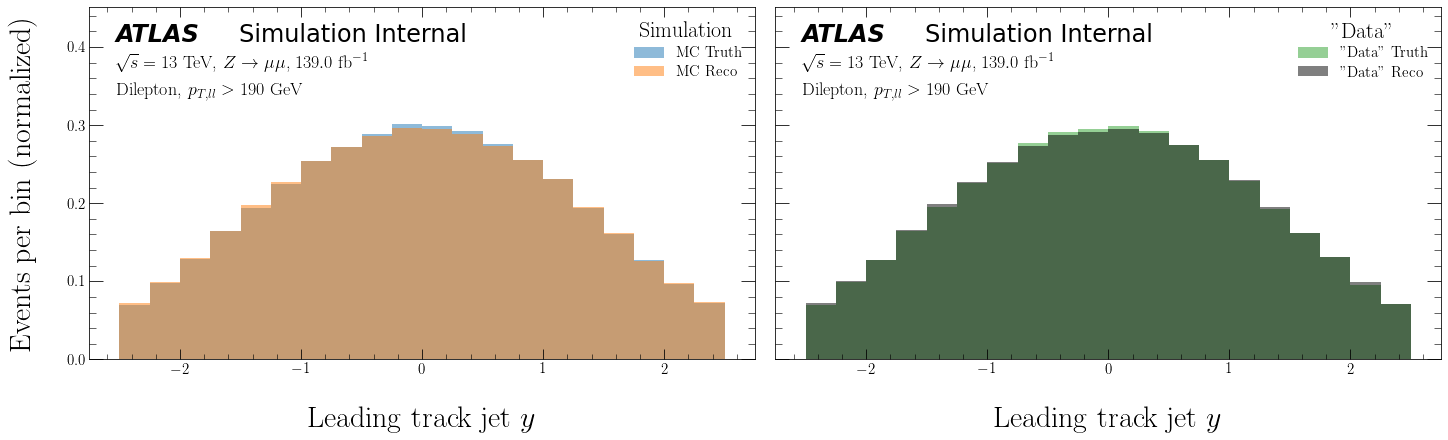

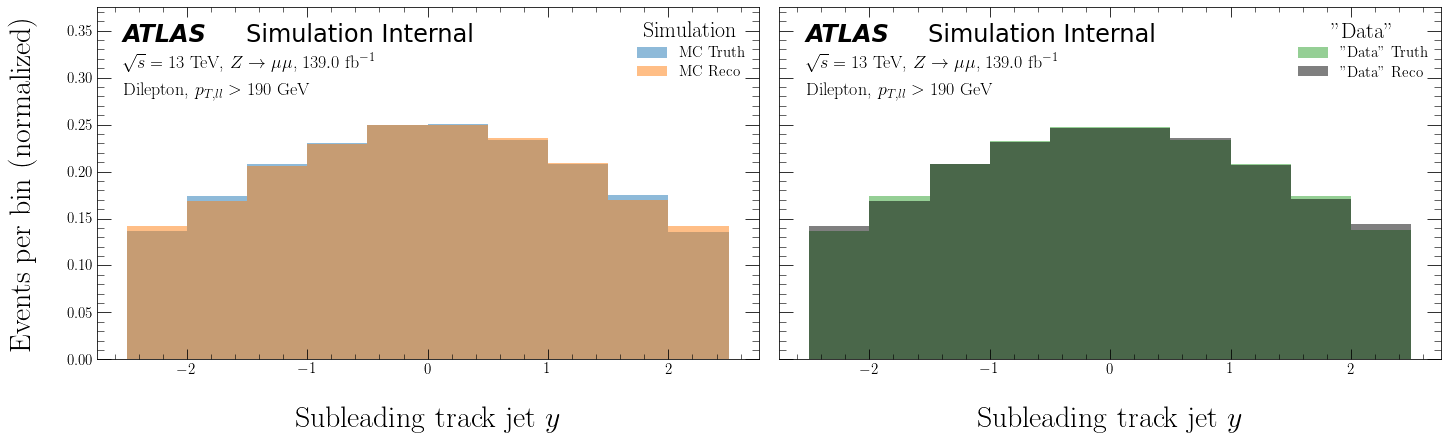

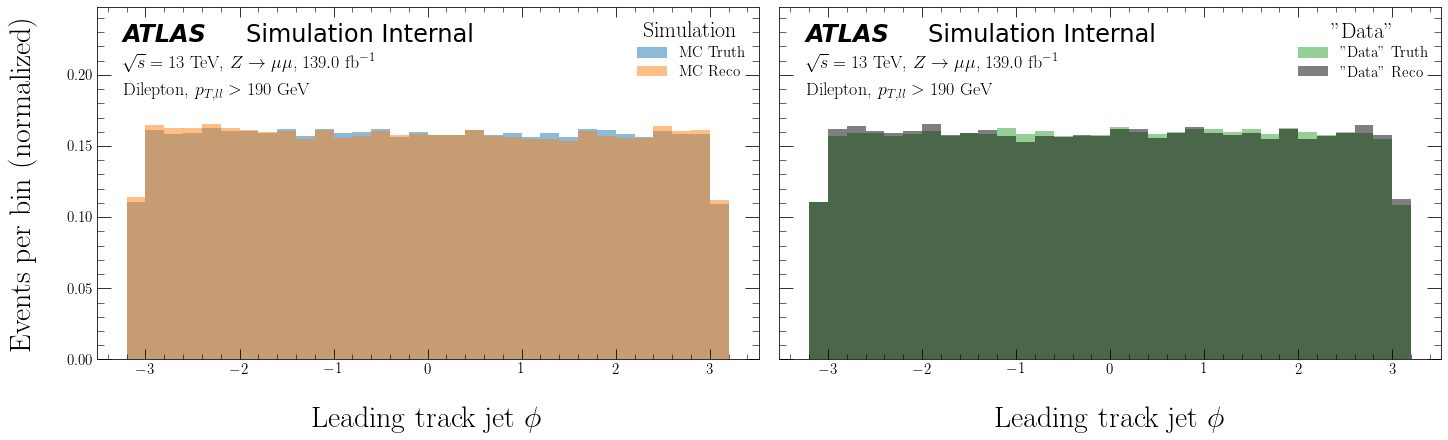

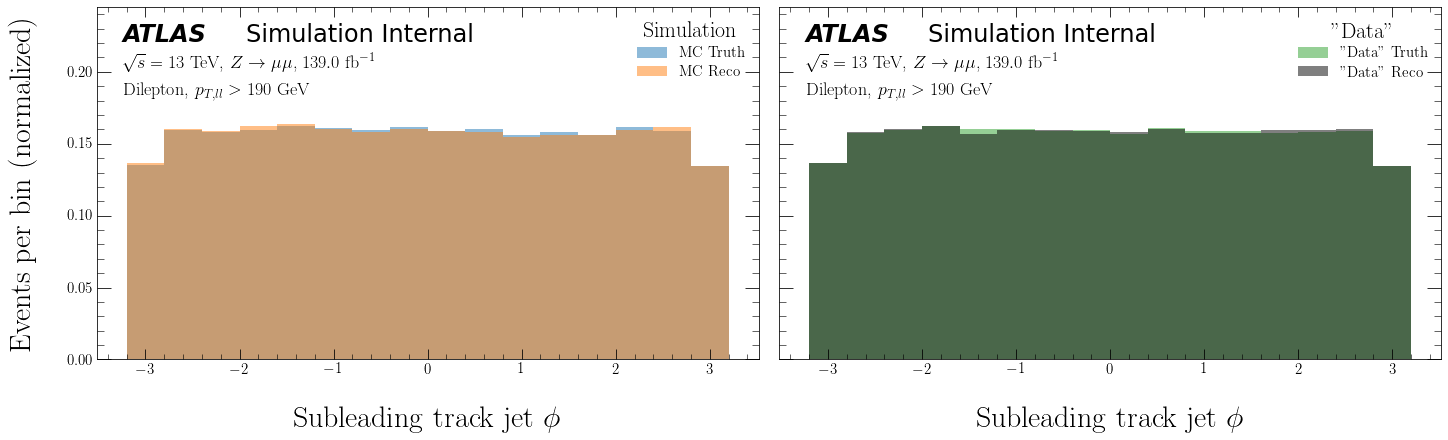

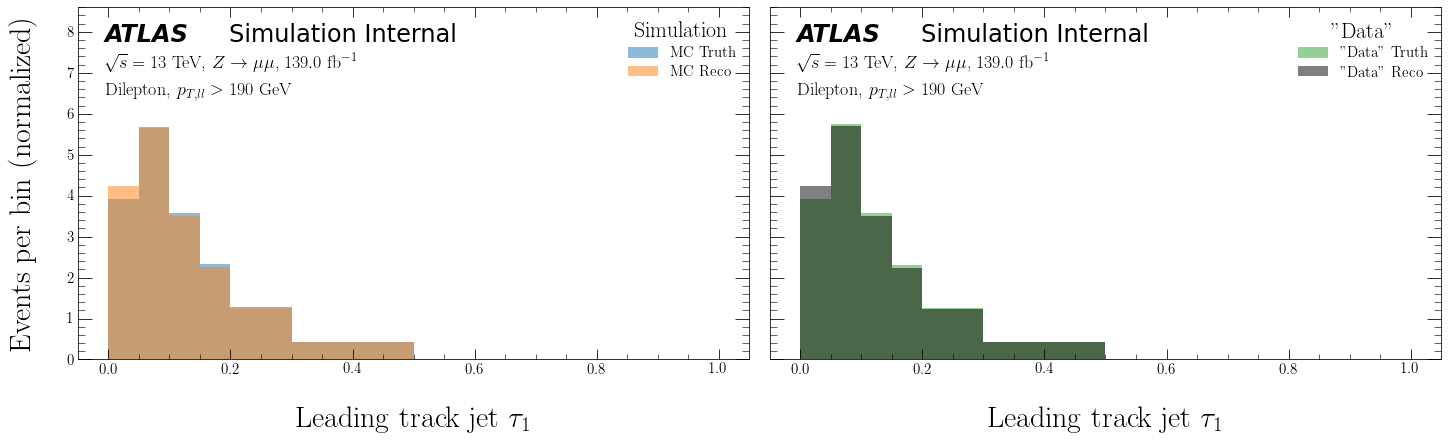

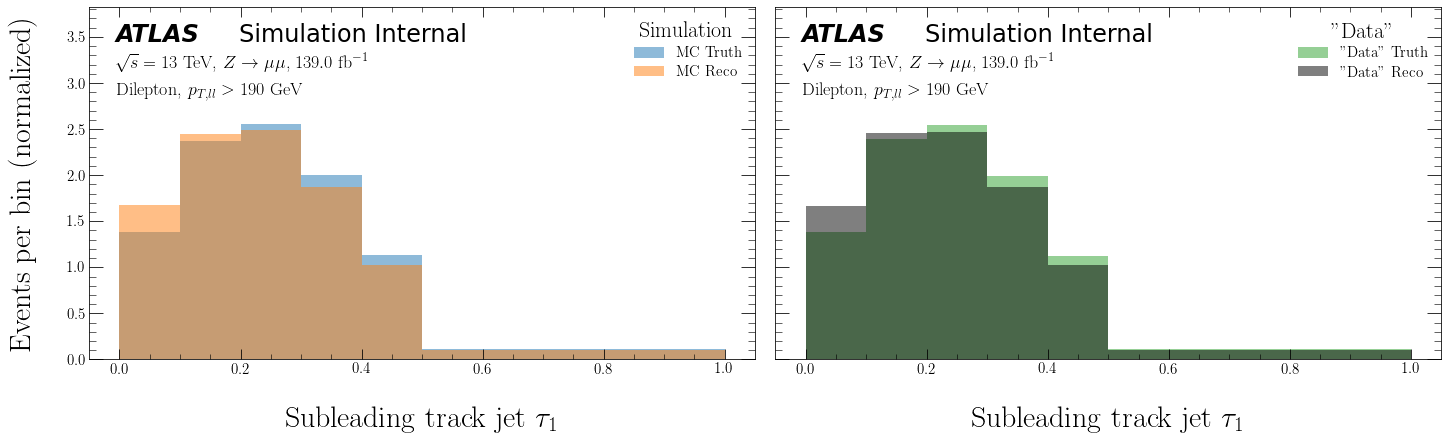

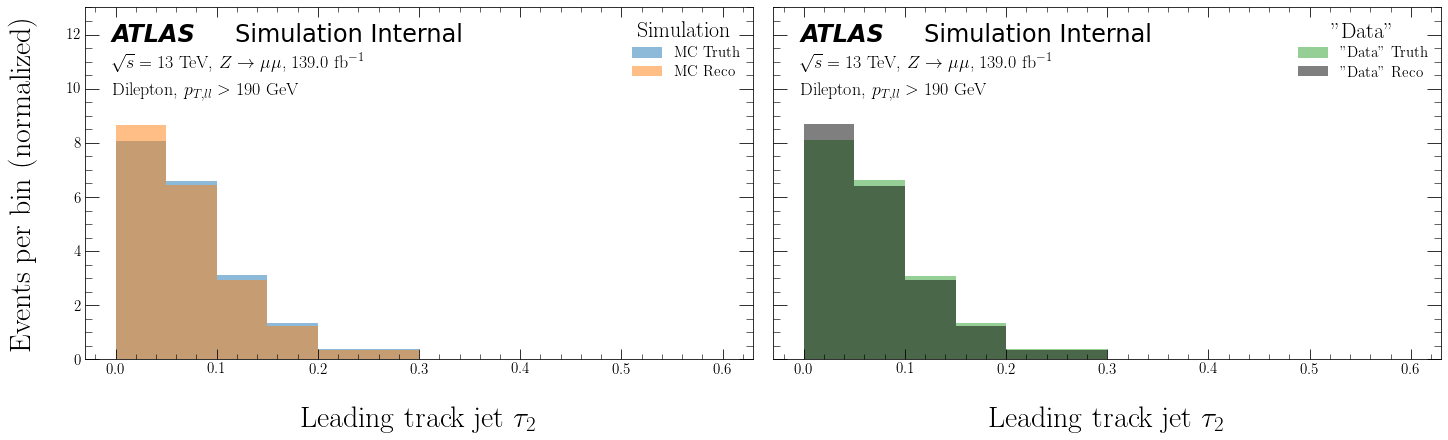

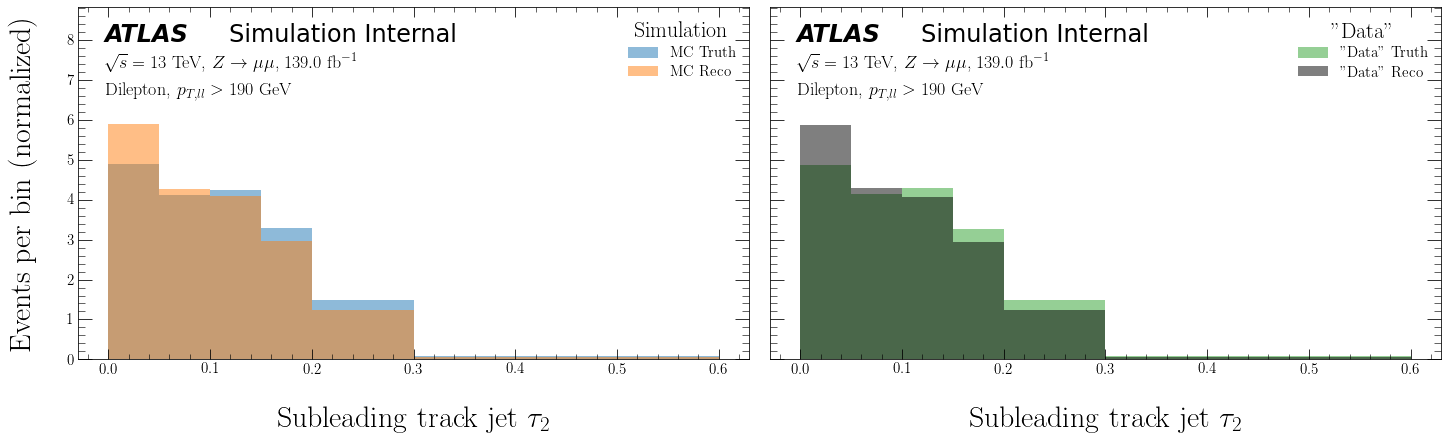

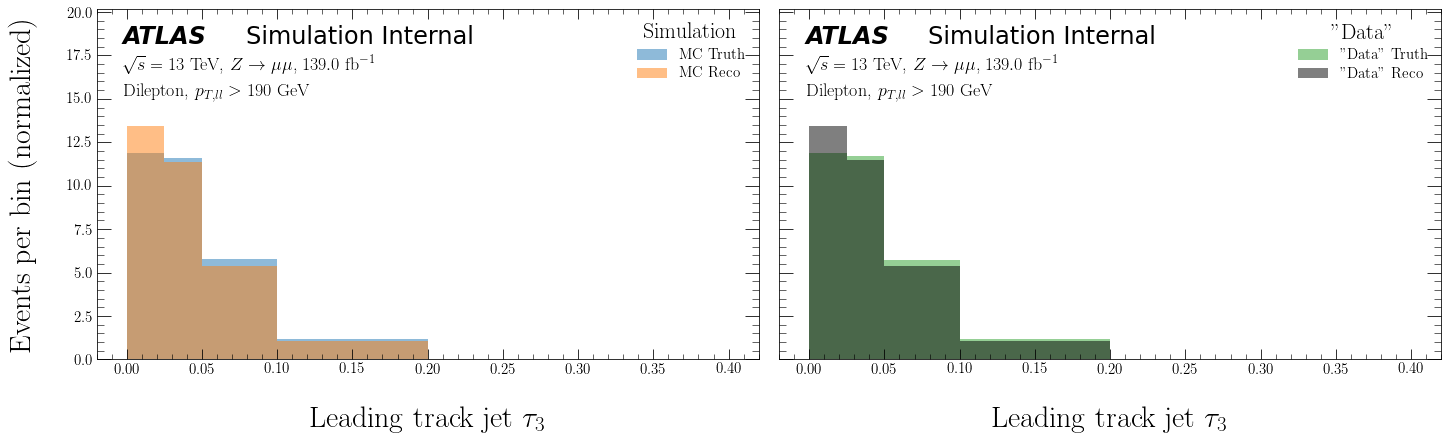

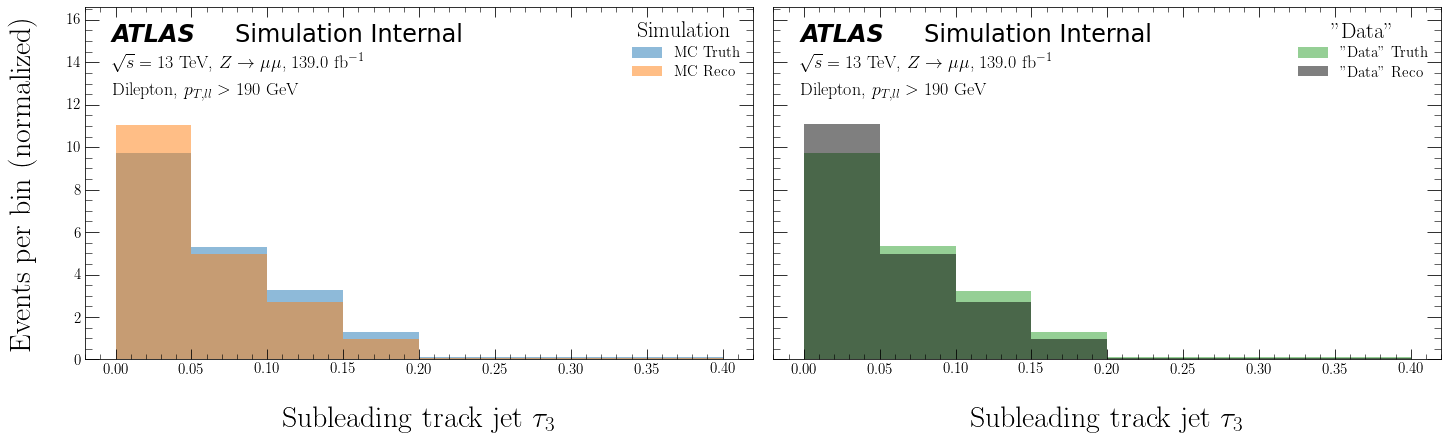

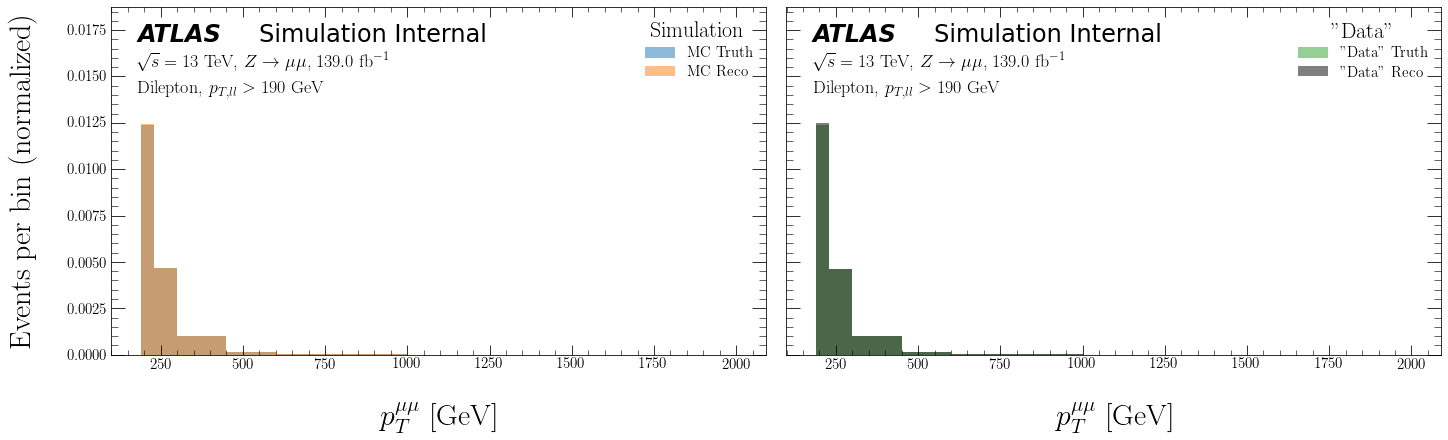

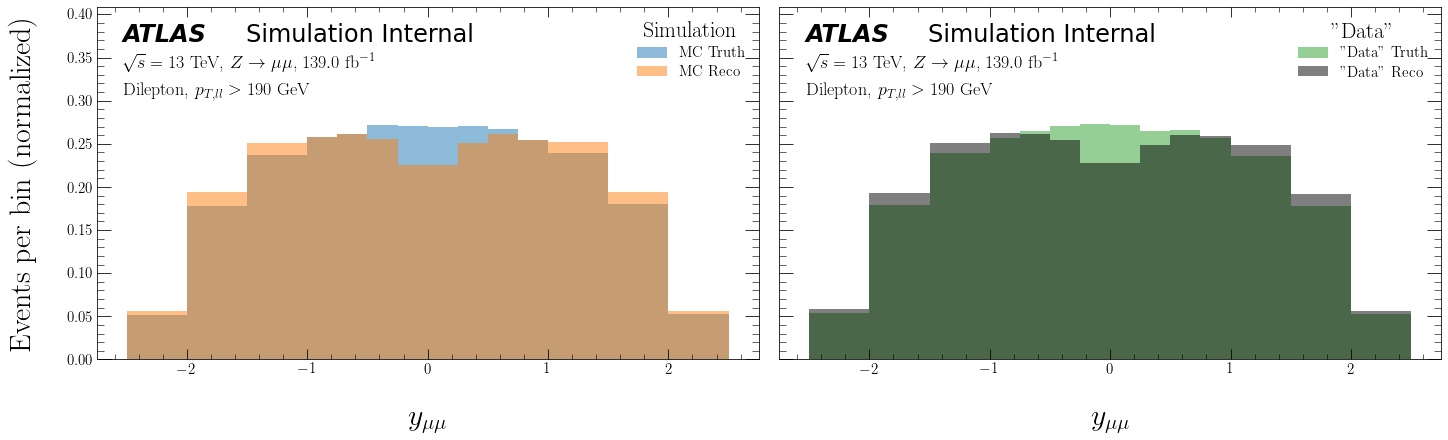

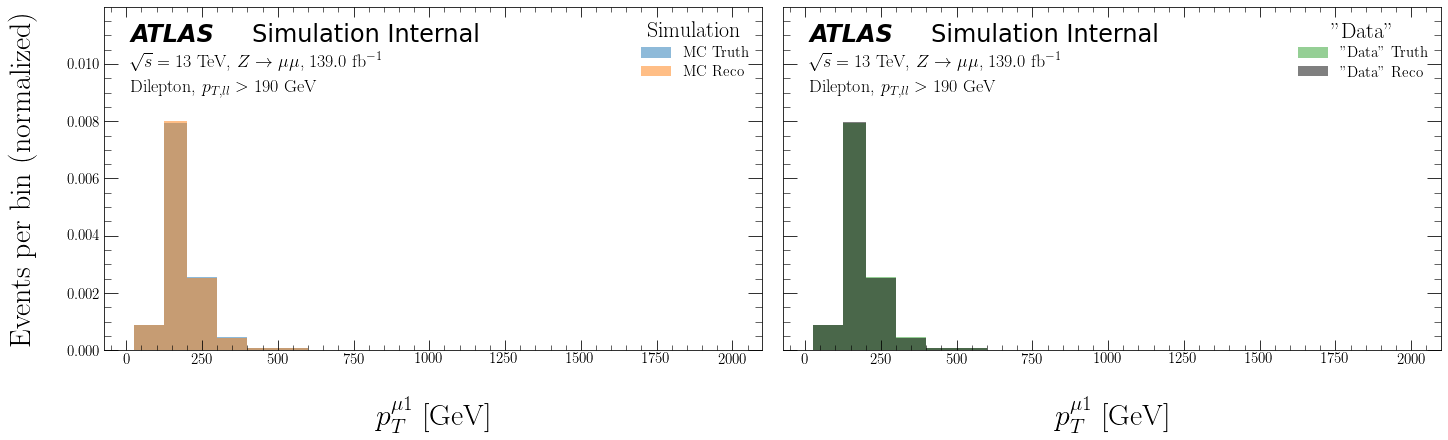

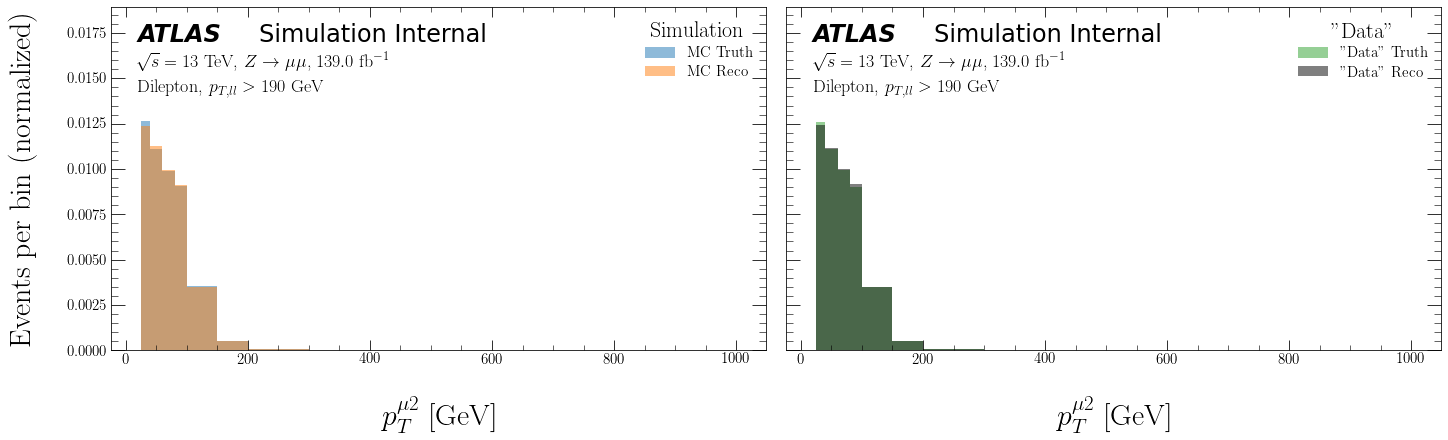

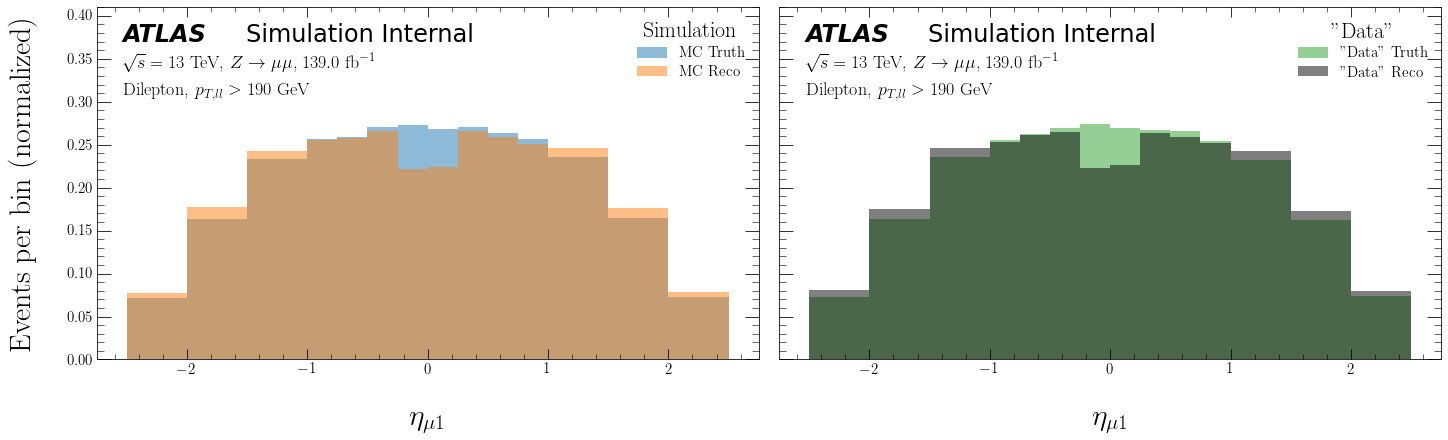

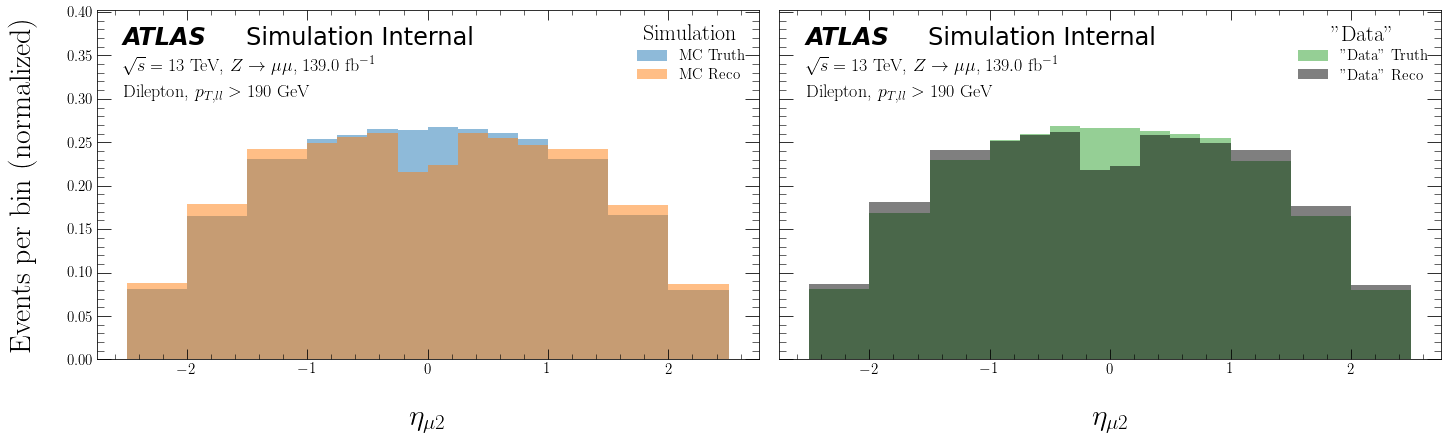

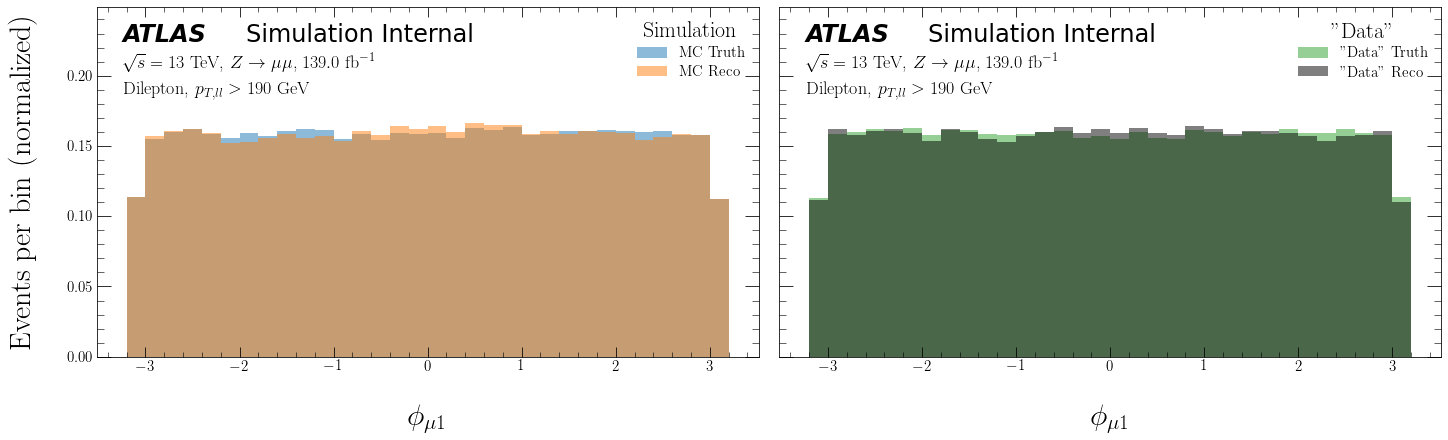

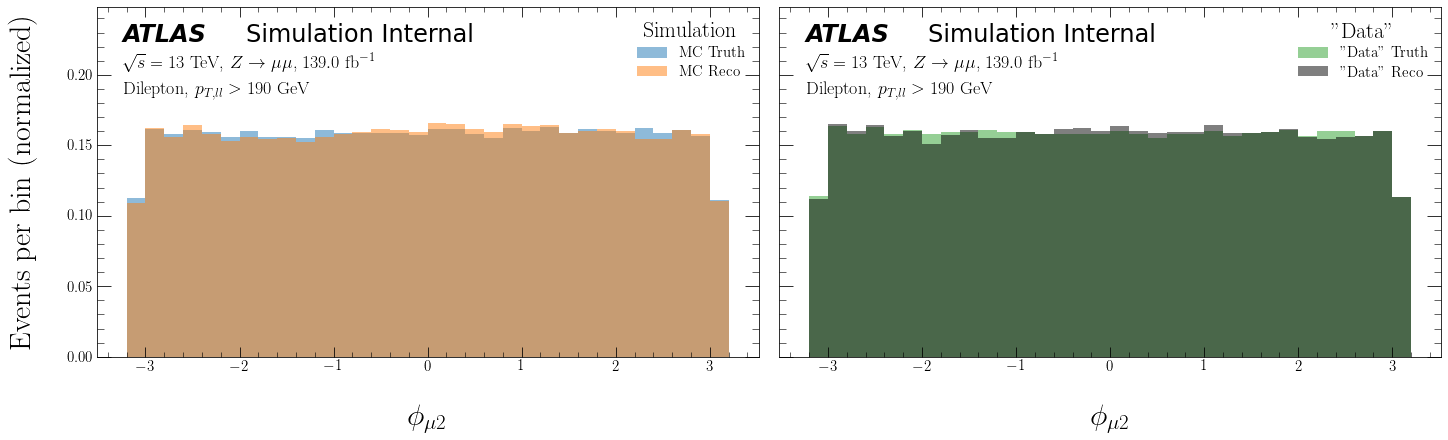

In [64]:
for i in range(len(obs)):
    bins = obs[i]['bins']
    x_label = obs[i]['plot_label']
    file_label = obs[i]['file_label']
    save_label = plot_dir + '/MultiFold/' + file_label + '/' + save_label0 + '-MultiFold-' + file_label
    plot_distributions(sim_truth=sim_truth[i],
                       sim_reco=sim_reco[i],
                       sim_truth_weights_MC=sim_truth_weights_MC,
                       sim_reco_weights_MC=sim_reco_weights_MC,
                       data_truth=data_truth[i],
                       data_reco=data_reco[i],
                       data_truth_weights_MC=data_truth_weights_MC,
                       data_reco_weights_MC=data_reco_weights_MC,
                       bins=bins,
                       x_label=x_label,
                       save_label=save_label)

## Unfold 

In [65]:
# z-score standardization of data
sim_truth_z = [None] * len(obs)
sim_reco_z = [None] * len(obs)
data_reco_z = [None] * len(obs)

for i in range(len(obs)):
    sim_truth_z[i], sim_reco_z[i], data_reco_z[i] = standardize(
        sim_truth[i], sim_reco[i], data_reco[i])

In [66]:
weights, _ = multifold(iterations=3,
                       sim_truth=sim_truth_z,
                       sim_reco=sim_reco_z,
                       sim_truth_weights_MC=sim_truth_weights_MC,
                       sim_reco_weights_MC=sim_reco_weights_MC,
                       data_reco=data_reco_z,
                       data_reco_weights_MC=data_reco_weights_MC,
                       dummyval=dummyval,
                       verbose=1)


ITERATION: 1

STEP 1

Epoch 1/1000
26/26 [==============================] - 0s 6ms/step - loss: 0.6981 - accuracy: 0.2515 - val_loss: 0.6953 - val_accuracy: 0.2524
Epoch 2/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.2523 - val_loss: 0.6947 - val_accuracy: 0.2519
Epoch 3/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.2532 - val_loss: 0.6946 - val_accuracy: 0.2507
Epoch 4/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.2546 - val_loss: 0.6946 - val_accuracy: 0.2512
Epoch 5/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.2559 - val_loss: 0.6946 - val_accuracy: 0.2512
Epoch 6/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.2571 - val_loss: 0.6945 - val_accuracy: 0.2516
Epoch 7/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.2578 - val_loss: 0.6946 - val_

26/26 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.2580 - val_loss: 0.6940 - val_accuracy: 0.2529
Epoch 5/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.2590 - val_loss: 0.6940 - val_accuracy: 0.2538
Epoch 6/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.2597 - val_loss: 0.6941 - val_accuracy: 0.2530
Epoch 7/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.2599 - val_loss: 0.6941 - val_accuracy: 0.2527
Epoch 8/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.2605 - val_loss: 0.6942 - val_accuracy: 0.2520
Epoch 9/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.2609 - val_loss: 0.6943 - val_accuracy: 0.2516
Epoch 10/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.2619 - val_loss: 0.6943 - val_accuracy: 0.2517
Epoch 11/1000
26/2

26/26 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.2621 - val_loss: 0.6961 - val_accuracy: 0.2531
Epoch 11/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.2626 - val_loss: 0.6962 - val_accuracy: 0.2535
Epoch 00011: early stopping

STEP 1b

Epoch 1/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.2494 - val_loss: 0.6924 - val_accuracy: 0.2478
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.2496 - val_loss: 0.6925 - val_accuracy: 0.2467
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.2505 - val_loss: 0.6928 - val_accuracy: 0.2464
Epoch 4/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.2507 - val_loss: 0.6929 - val_accuracy: 0.2452
Epoch 5/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.2508 - val_loss: 0.6930 - v

### Results

Ntracks_trackj1 Results

ITERATION 1:


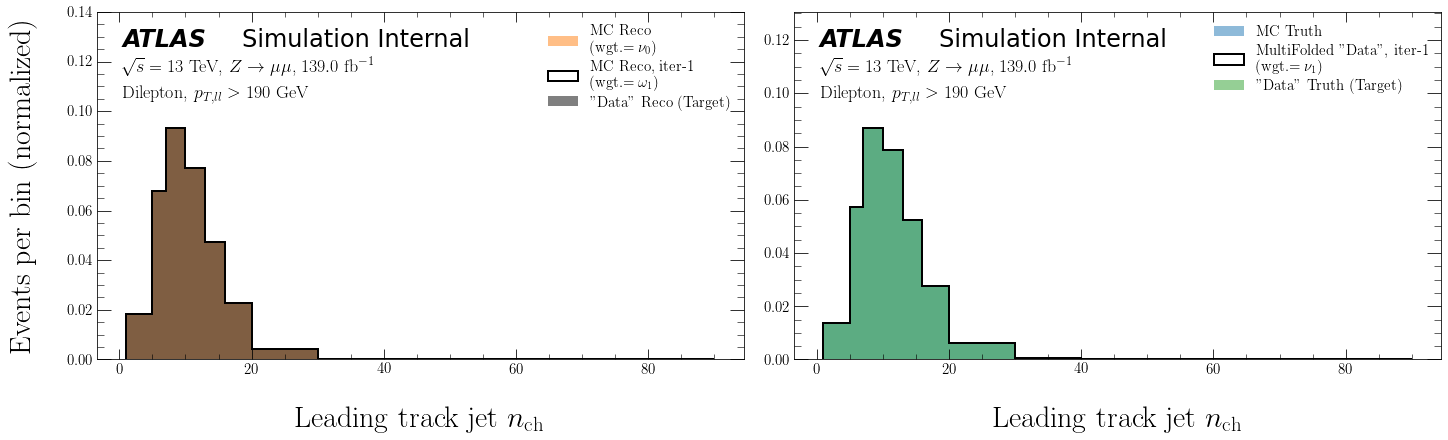

ITERATION 2:


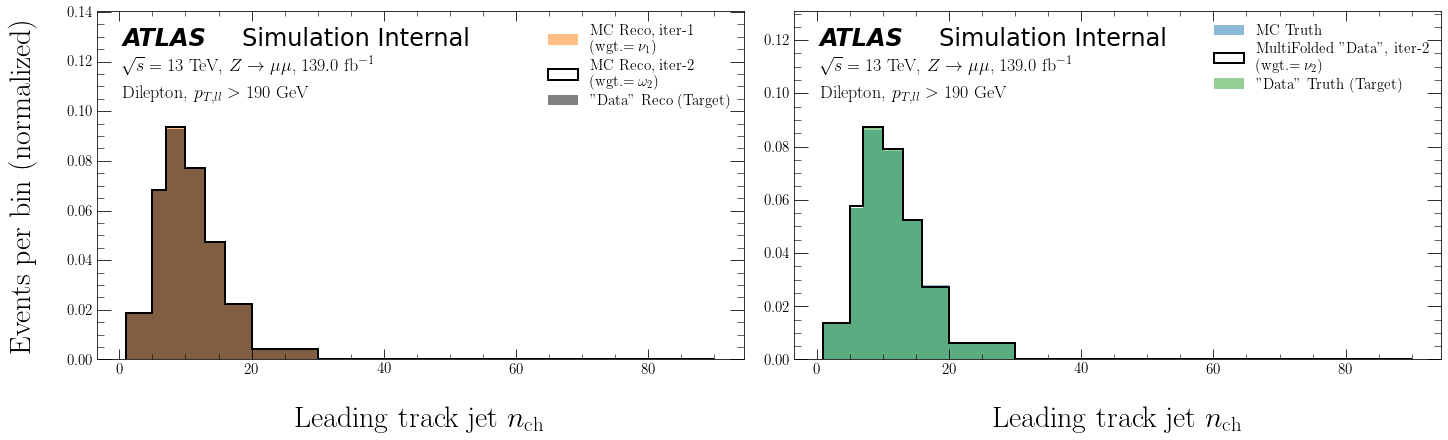

ITERATION 3:


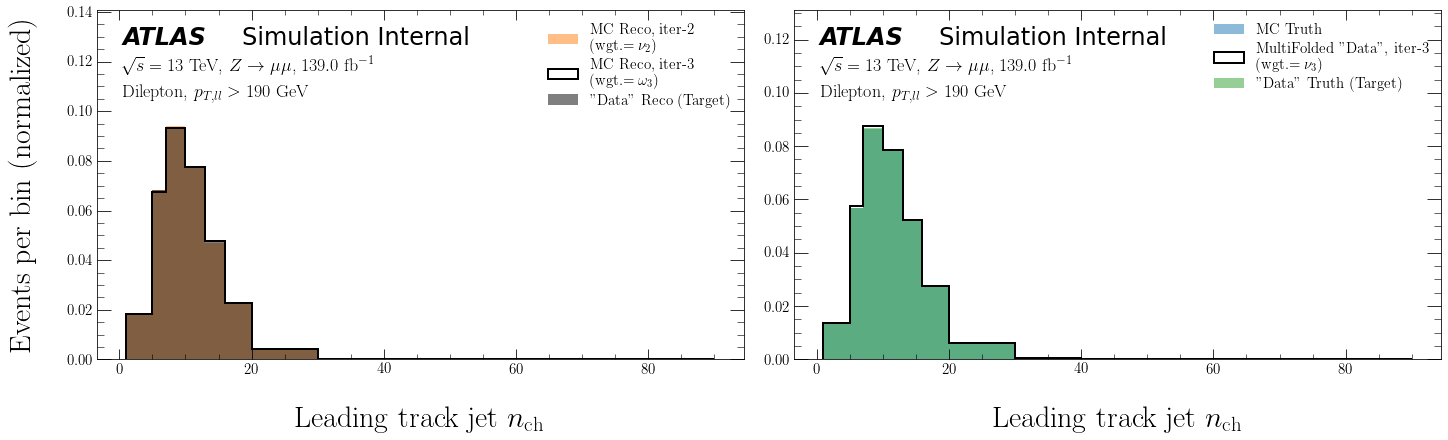

Ntracks_trackj2 Results

ITERATION 1:


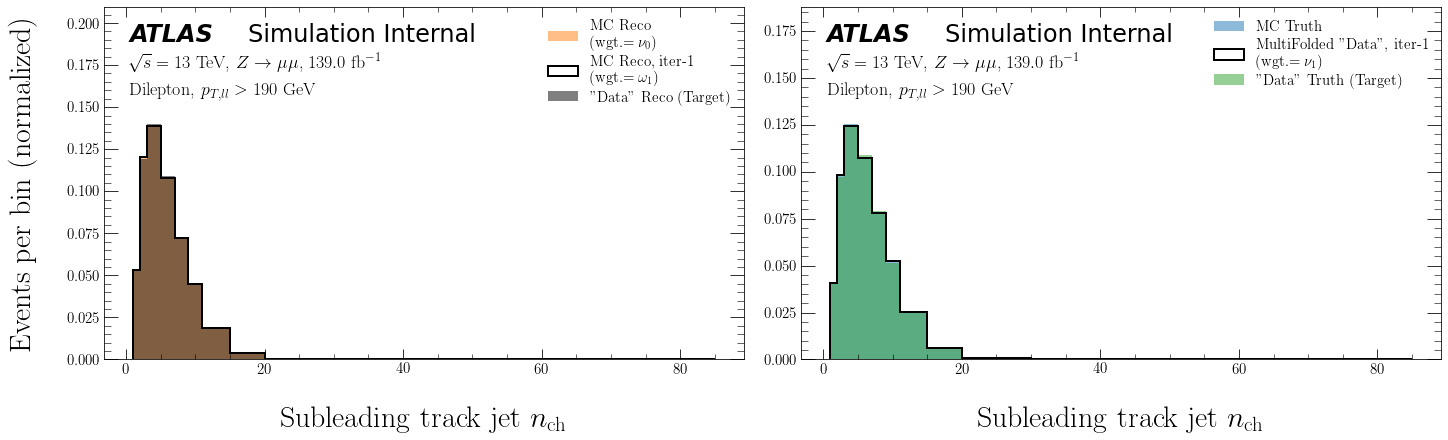

ITERATION 2:


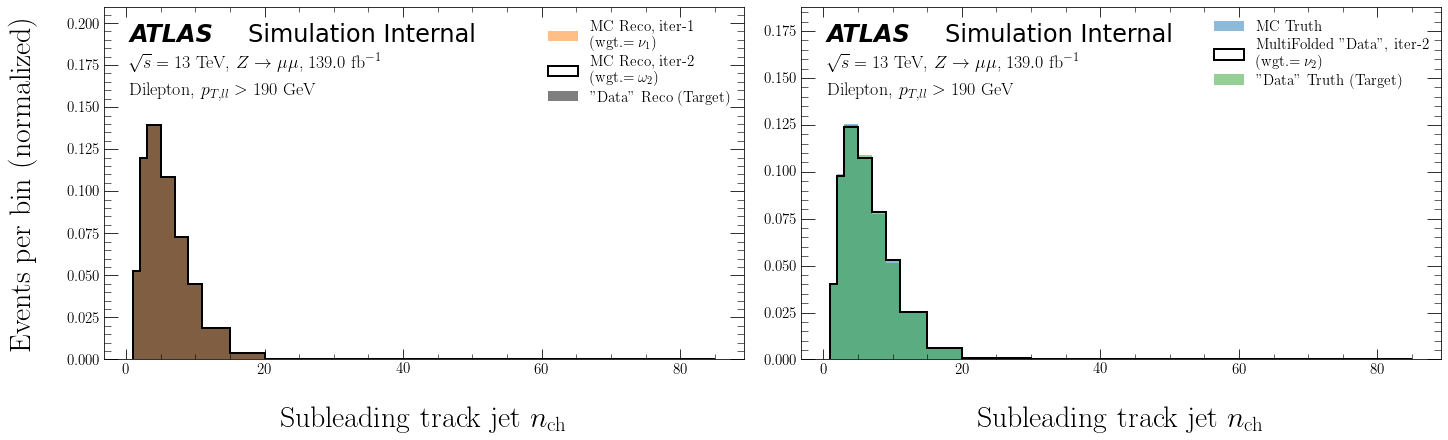

ITERATION 3:


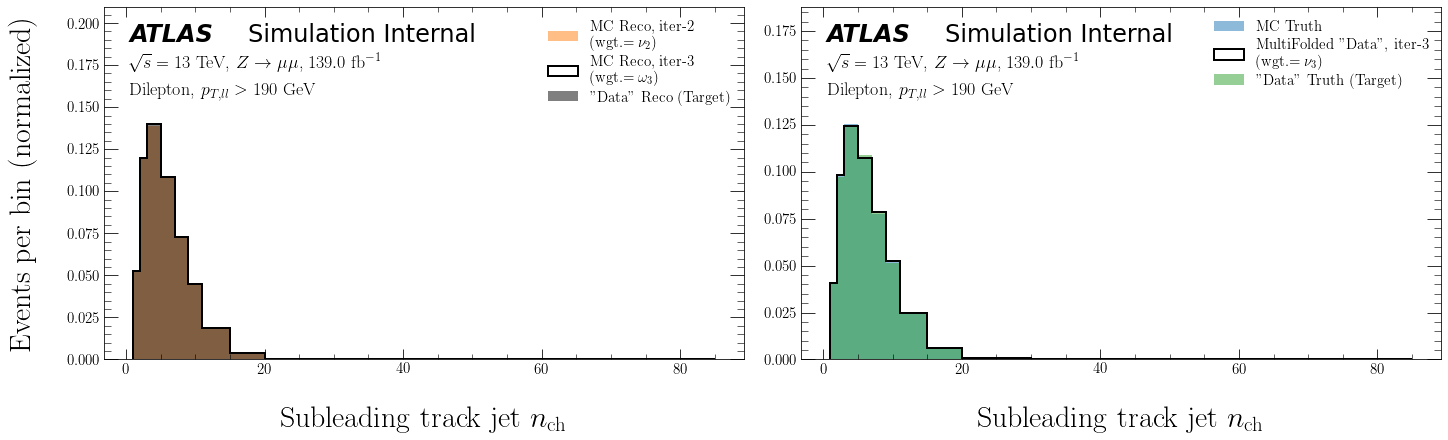

m_trackj1 Results

ITERATION 1:


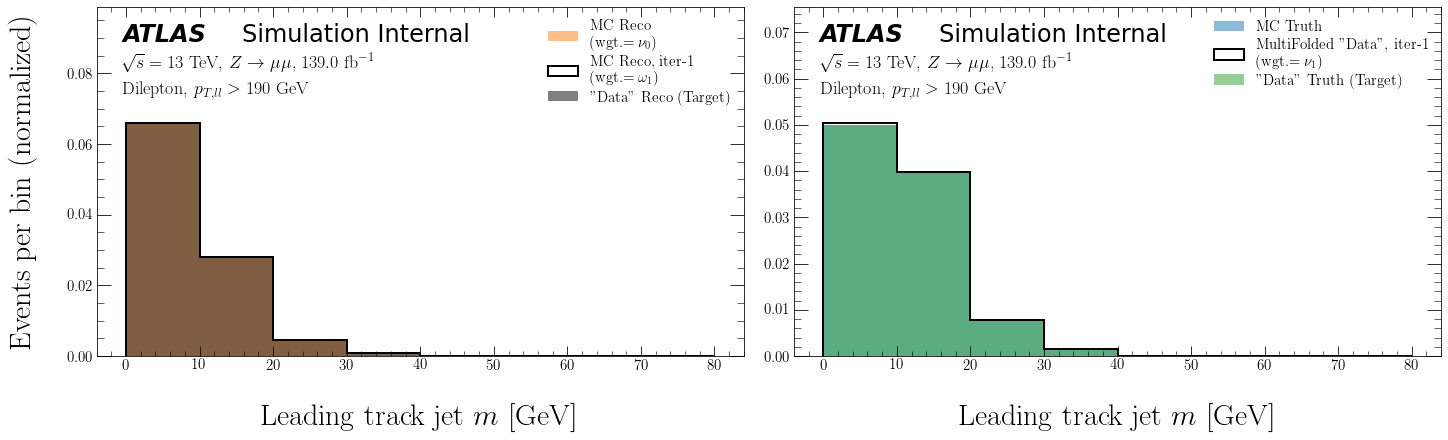

ITERATION 2:


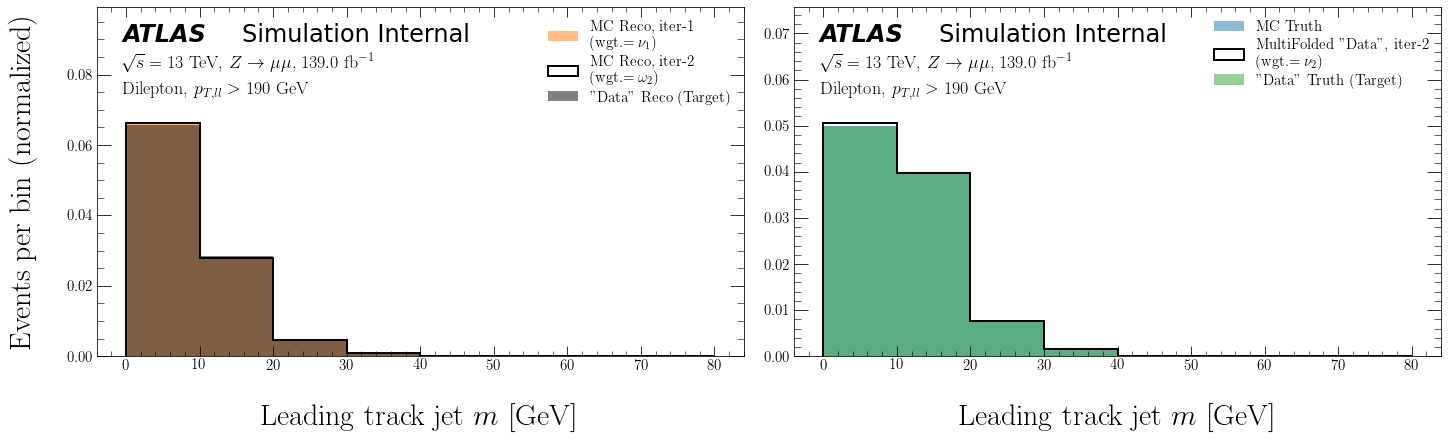

ITERATION 3:


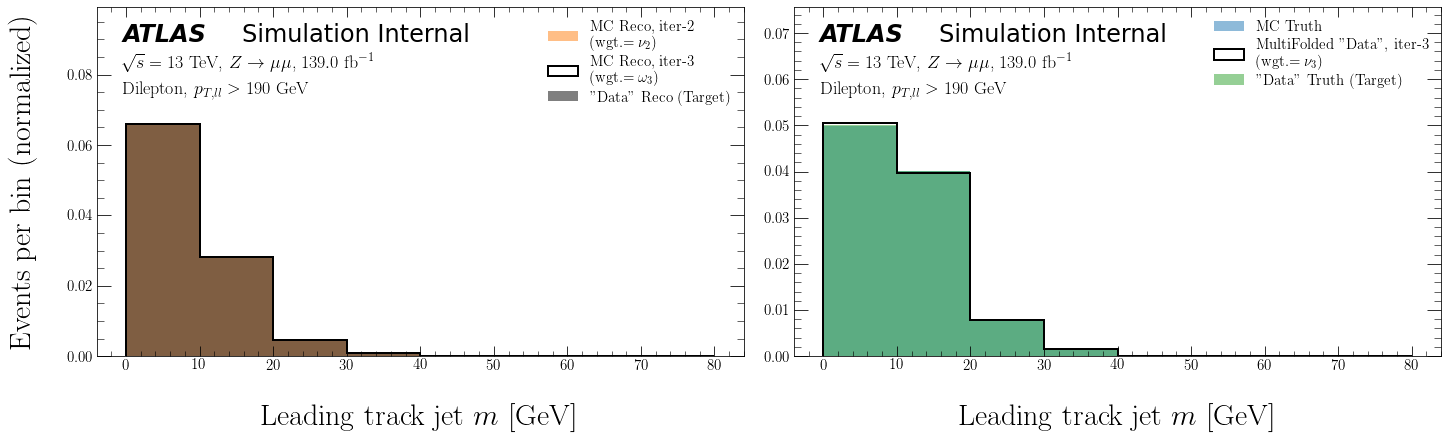

m_trackj2 Results

ITERATION 1:


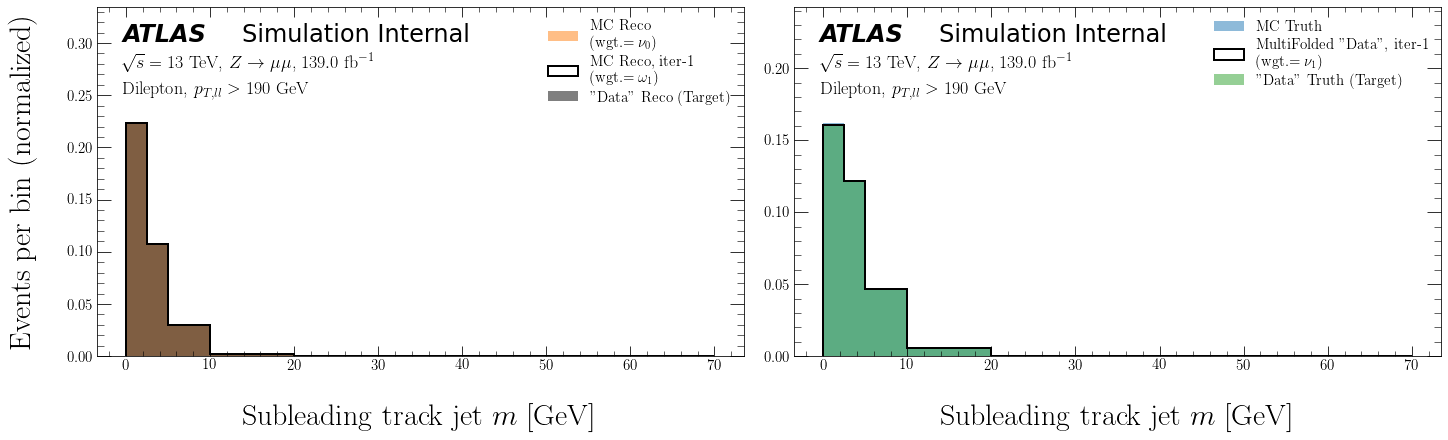

ITERATION 2:


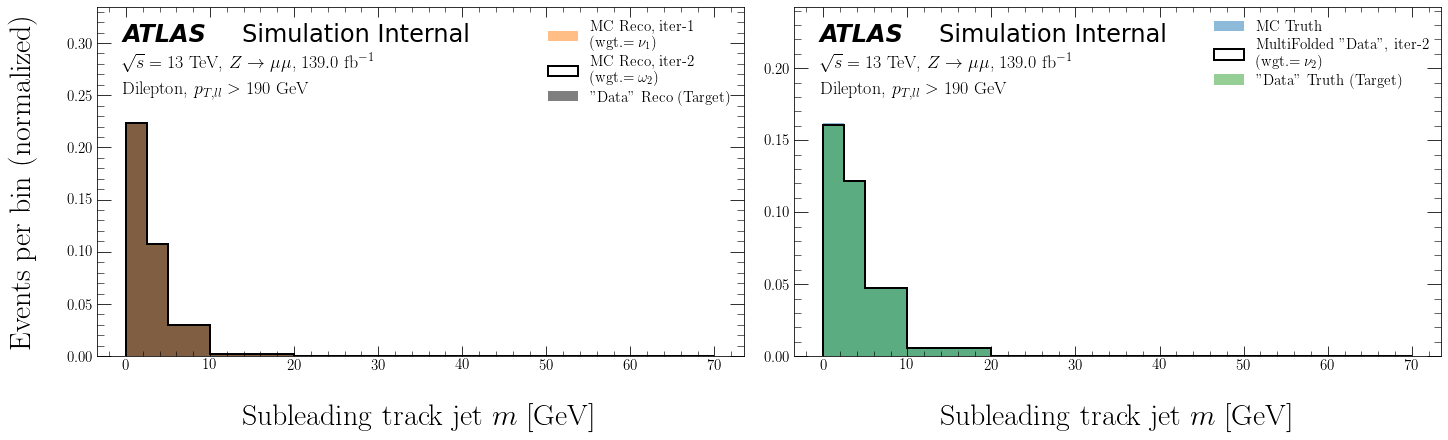

ITERATION 3:


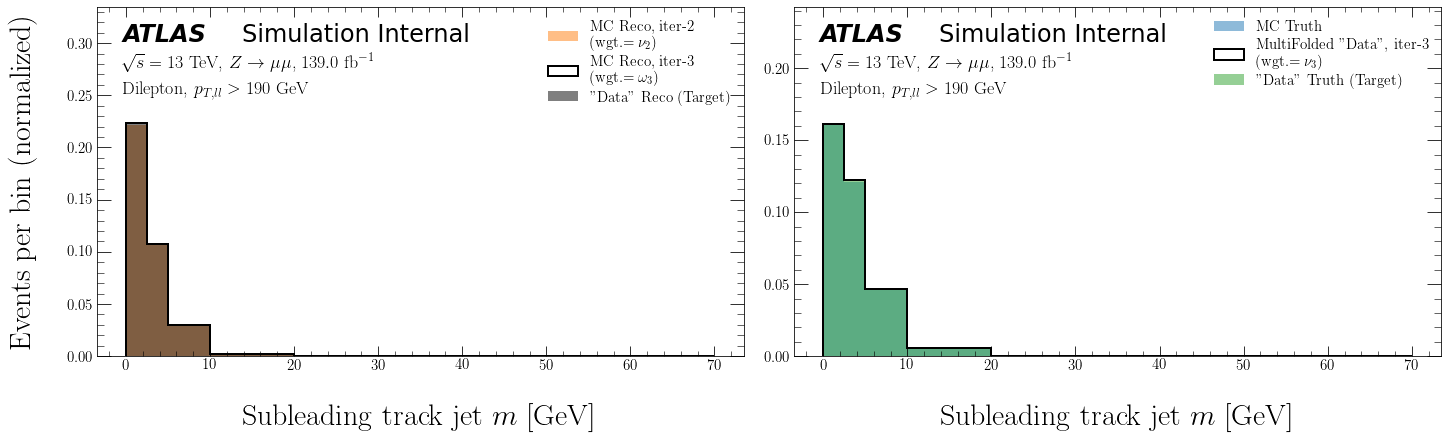

pT_trackj1 Results

ITERATION 1:


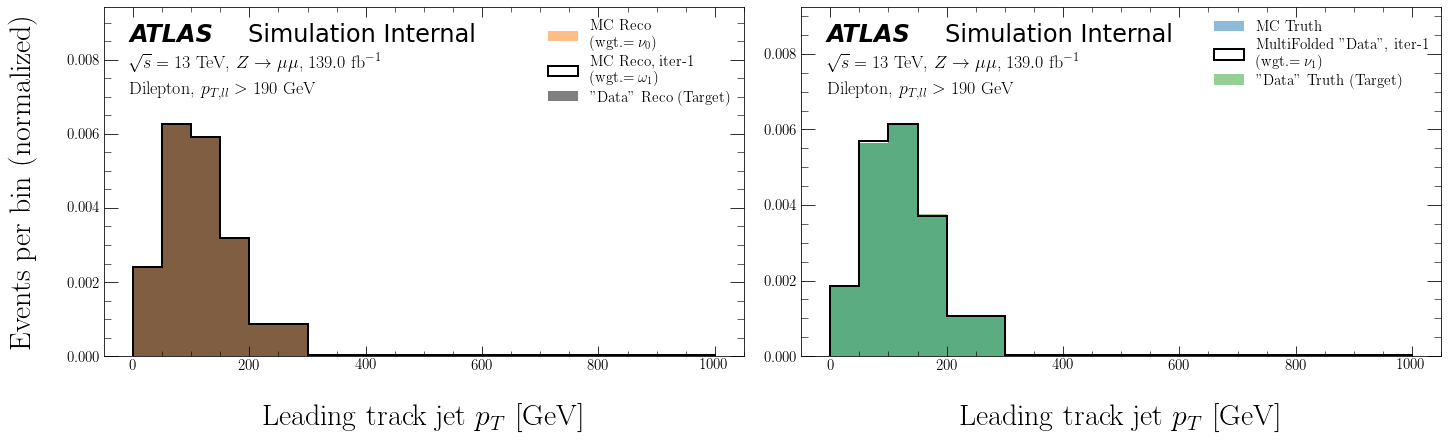

ITERATION 2:


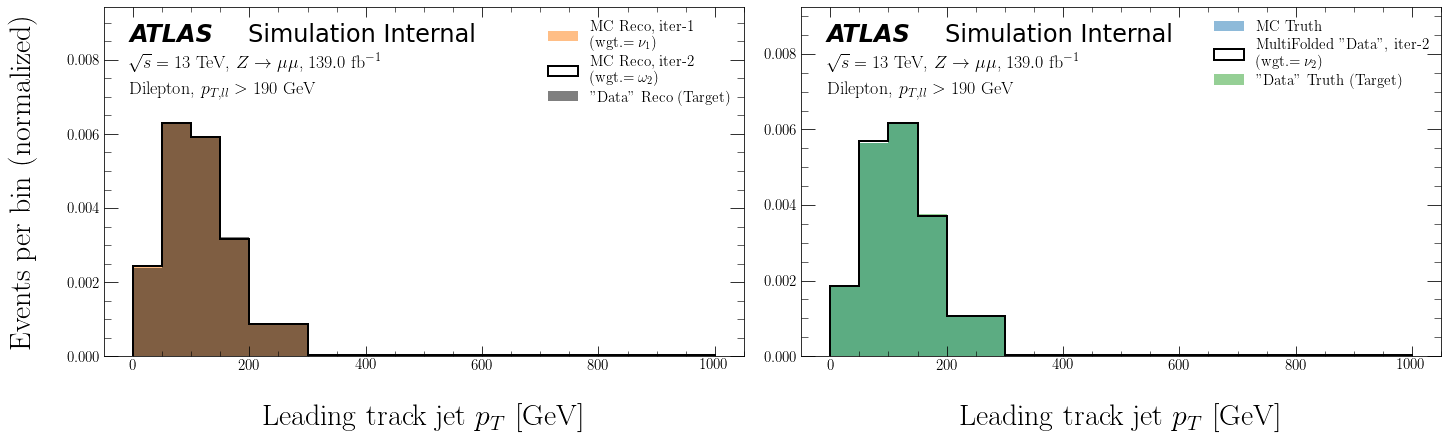

ITERATION 3:


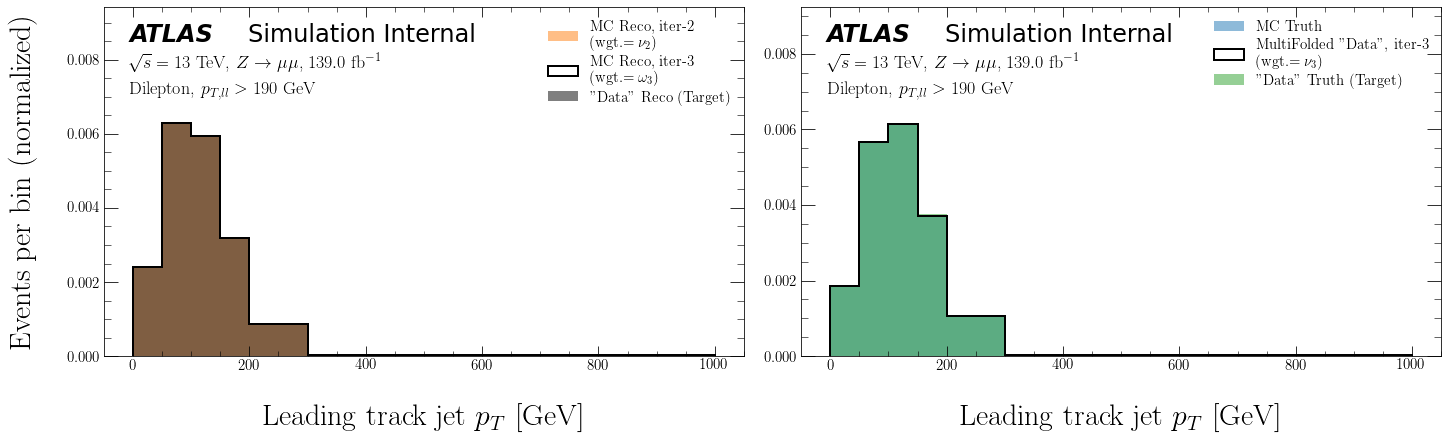

pT_trackj2 Results

ITERATION 1:


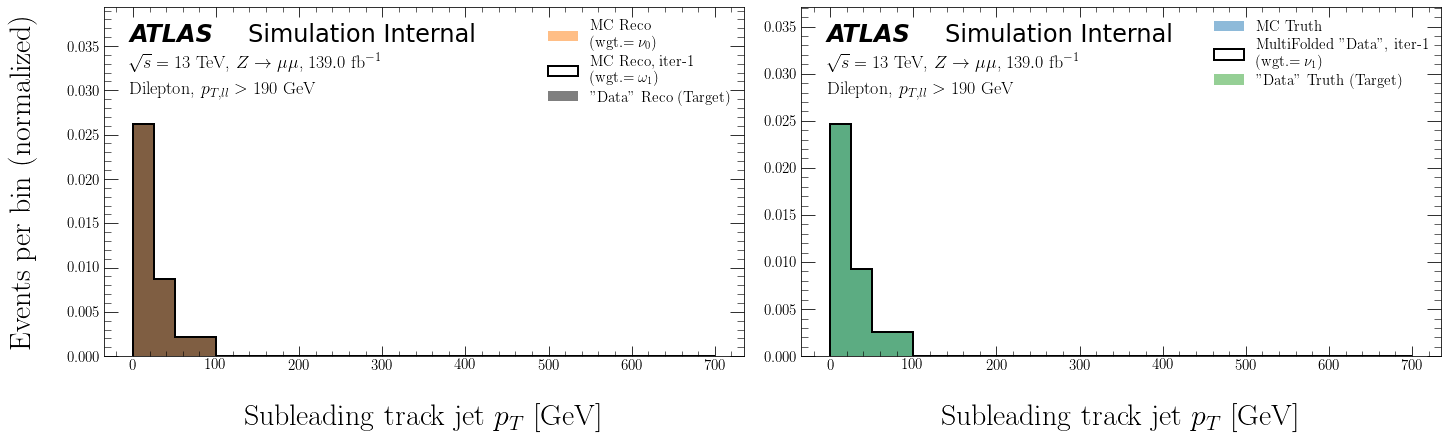

ITERATION 2:


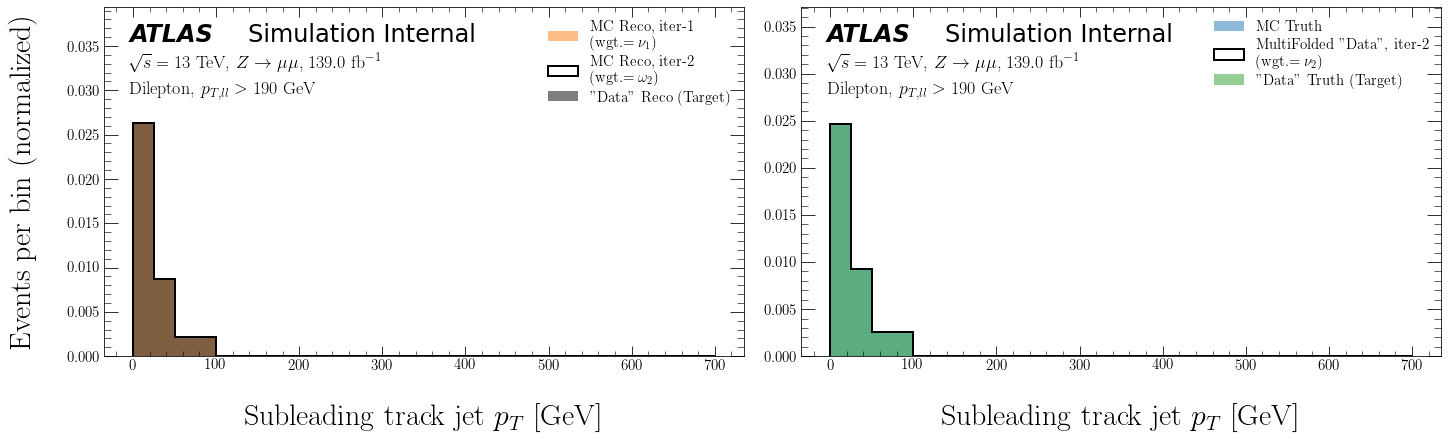

ITERATION 3:


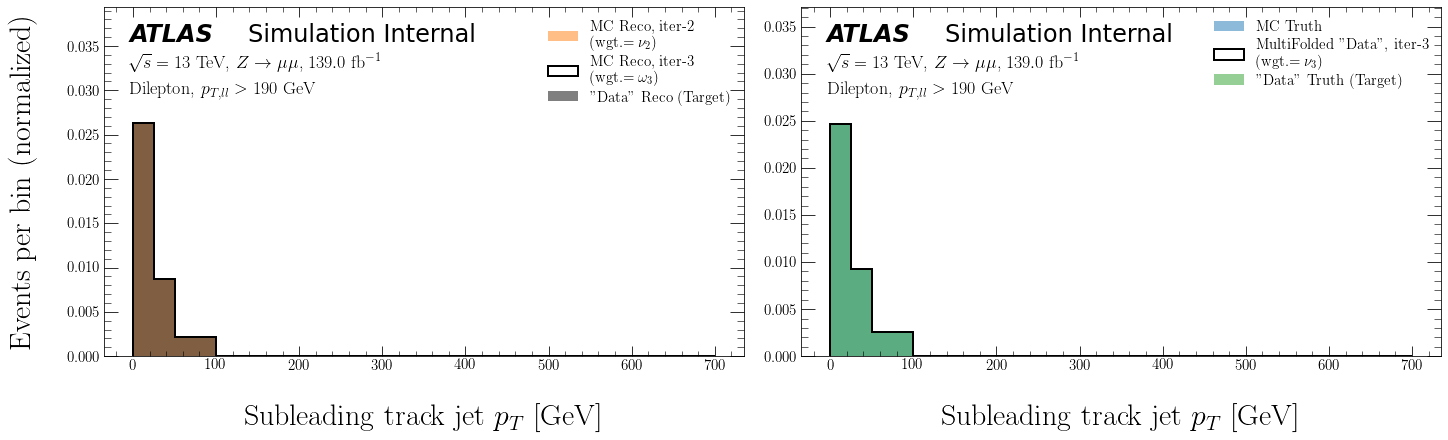

y_trackj1 Results

ITERATION 1:


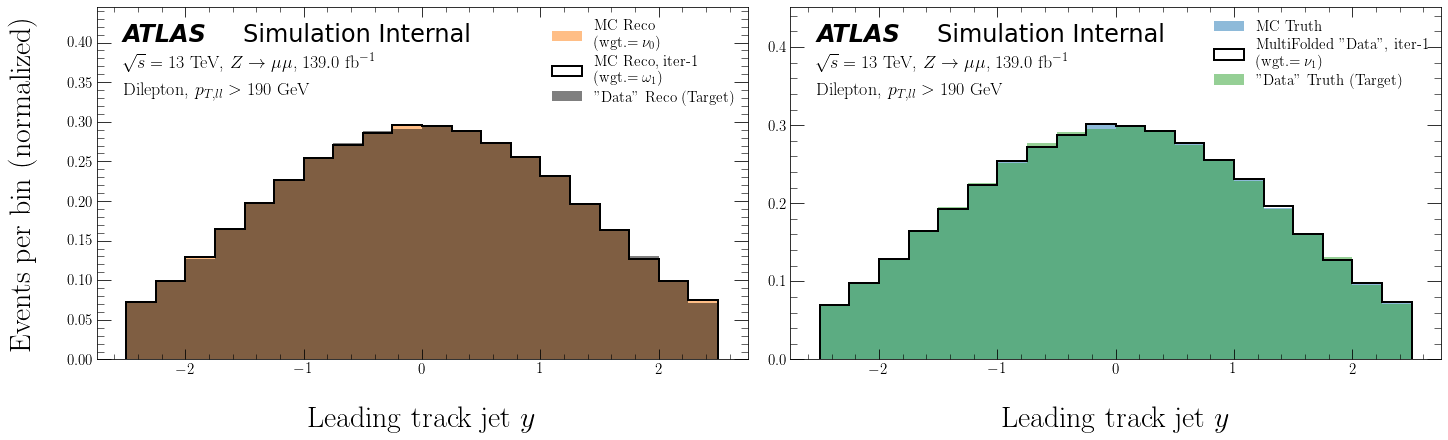

ITERATION 2:


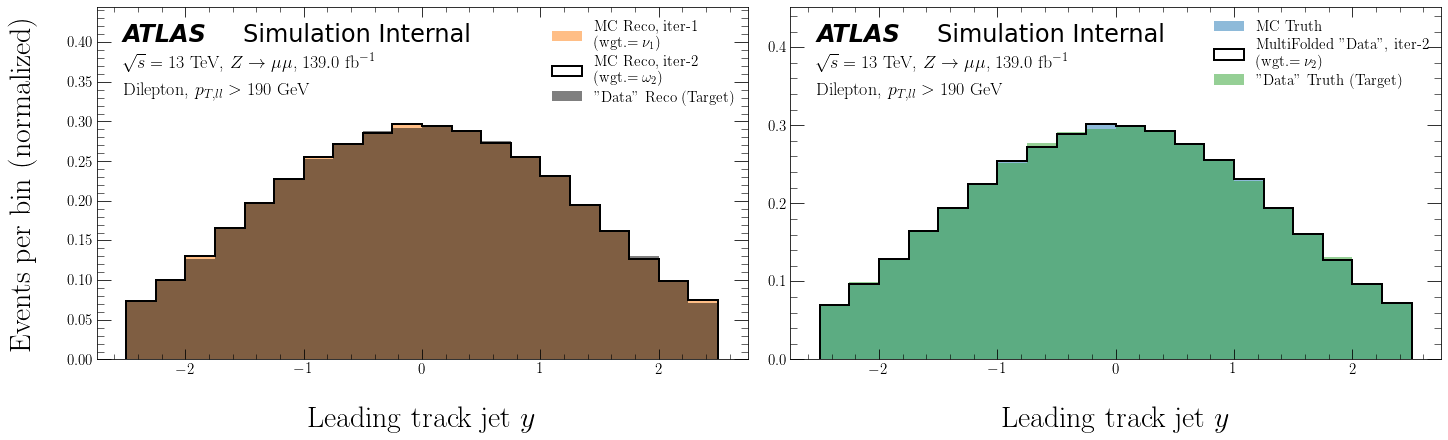

ITERATION 3:


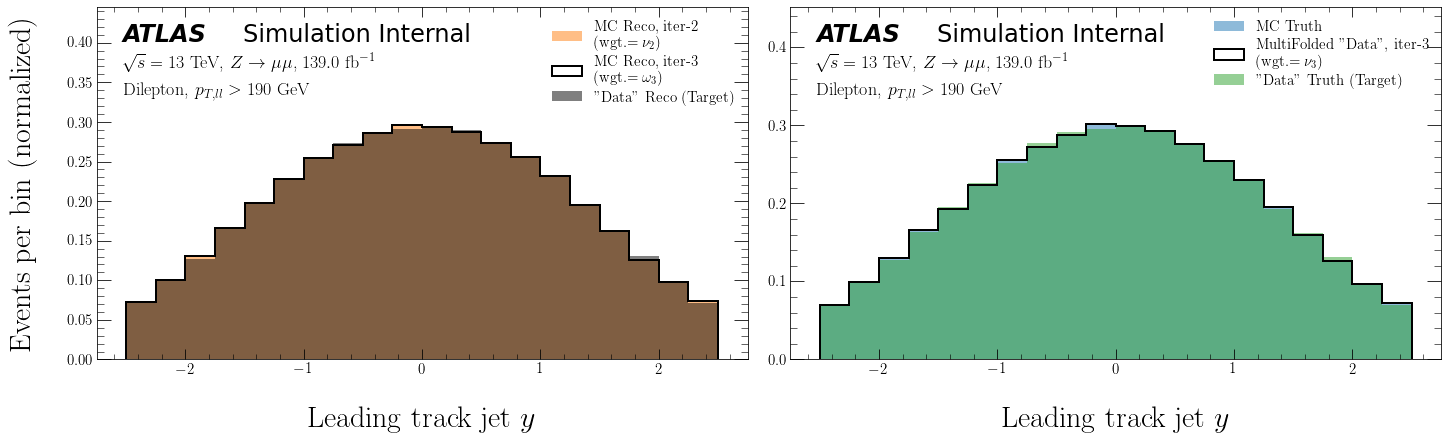

y_trackj2 Results

ITERATION 1:


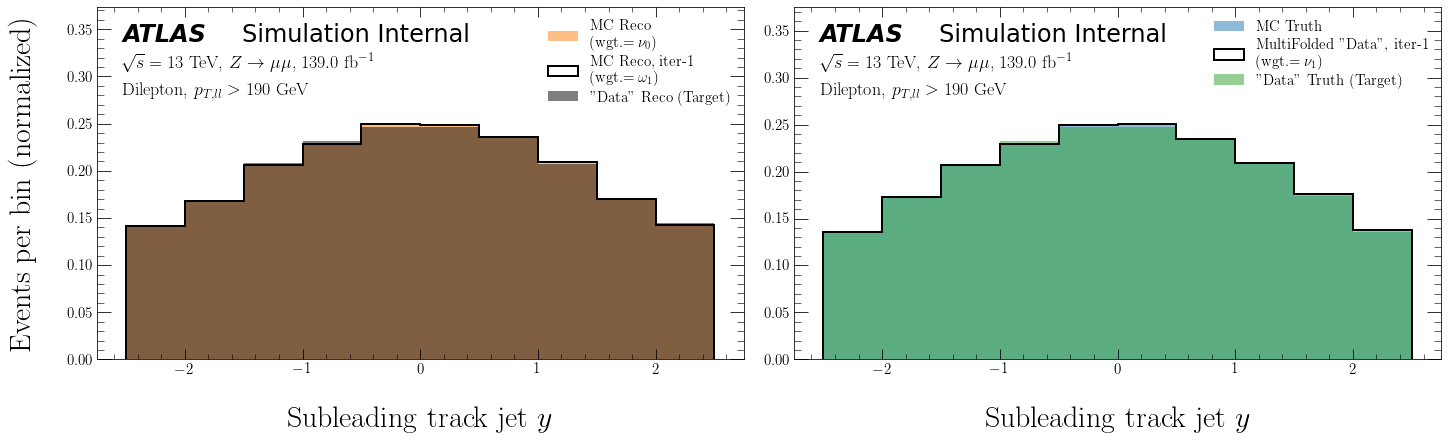

ITERATION 2:


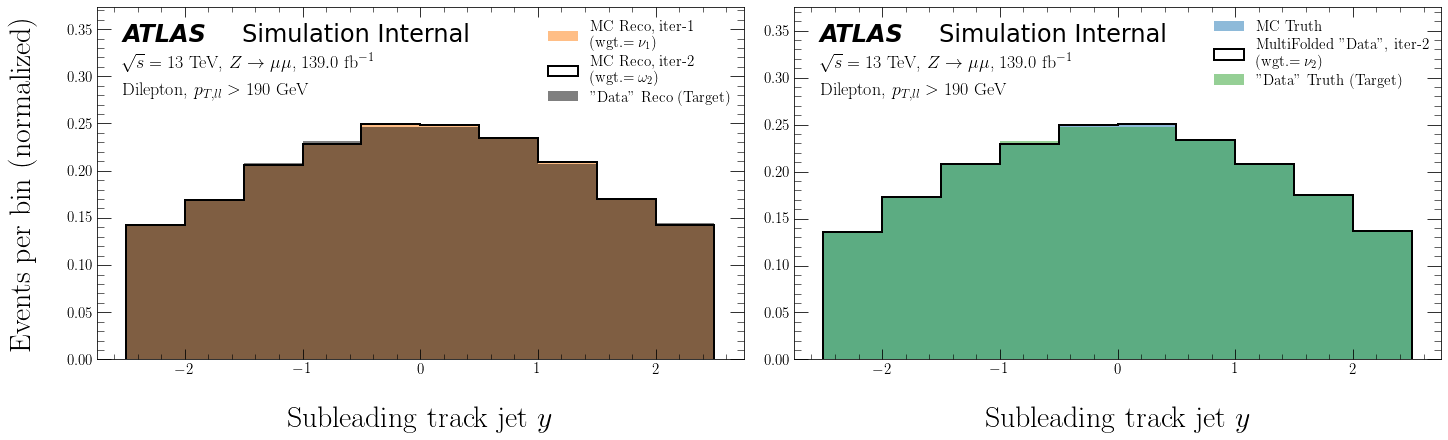

ITERATION 3:


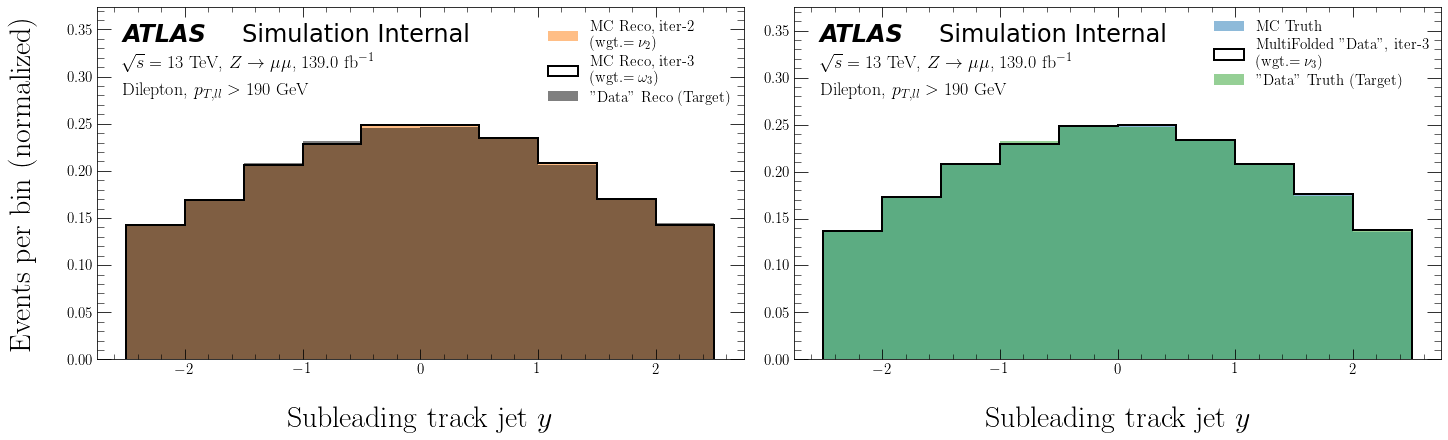

phi_trackj1 Results

ITERATION 1:


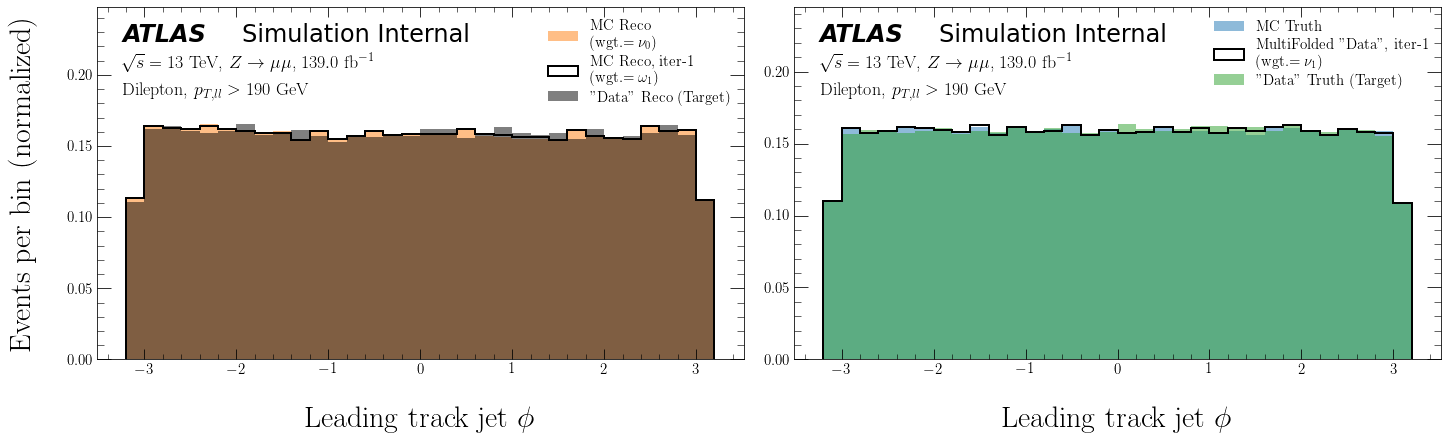

ITERATION 2:


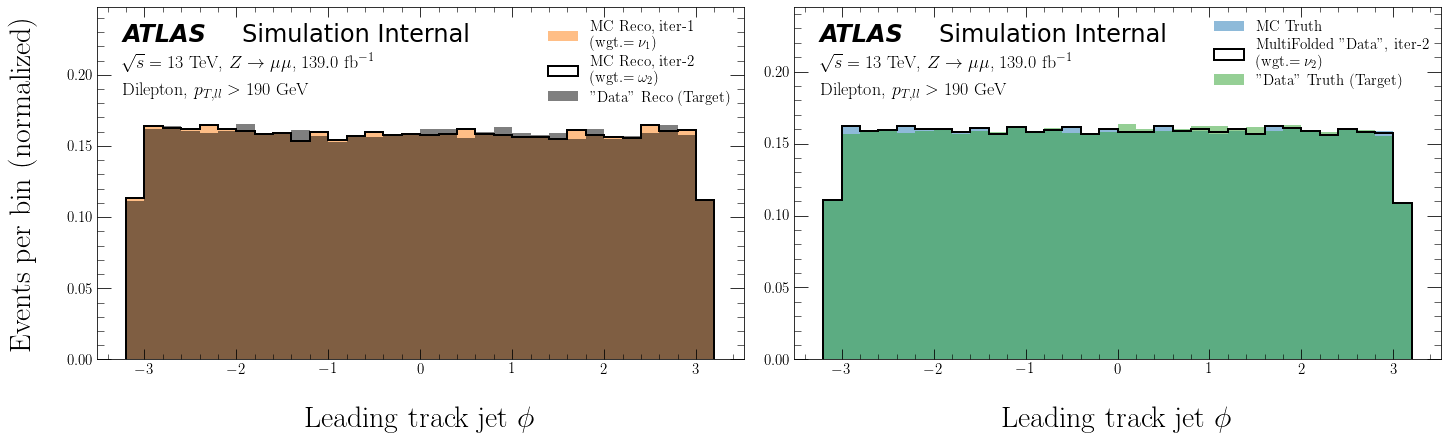

ITERATION 3:


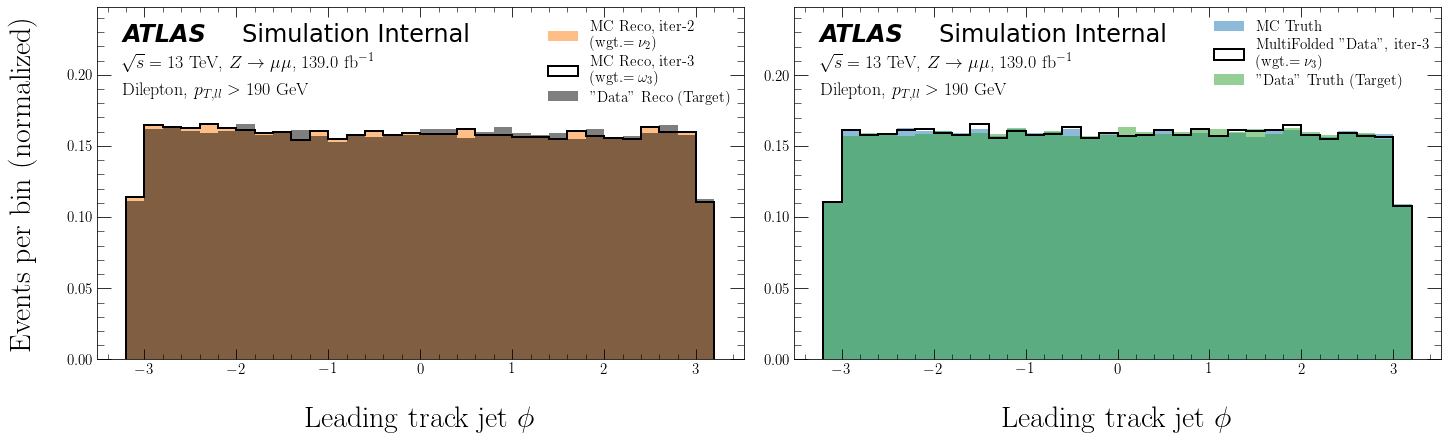

phi_trackj2 Results

ITERATION 1:


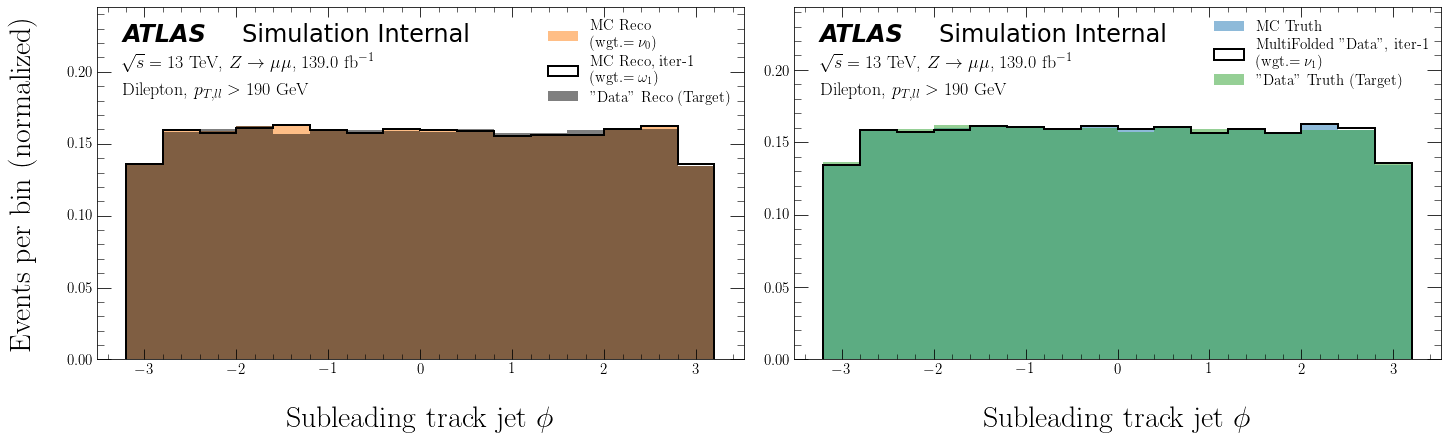

ITERATION 2:


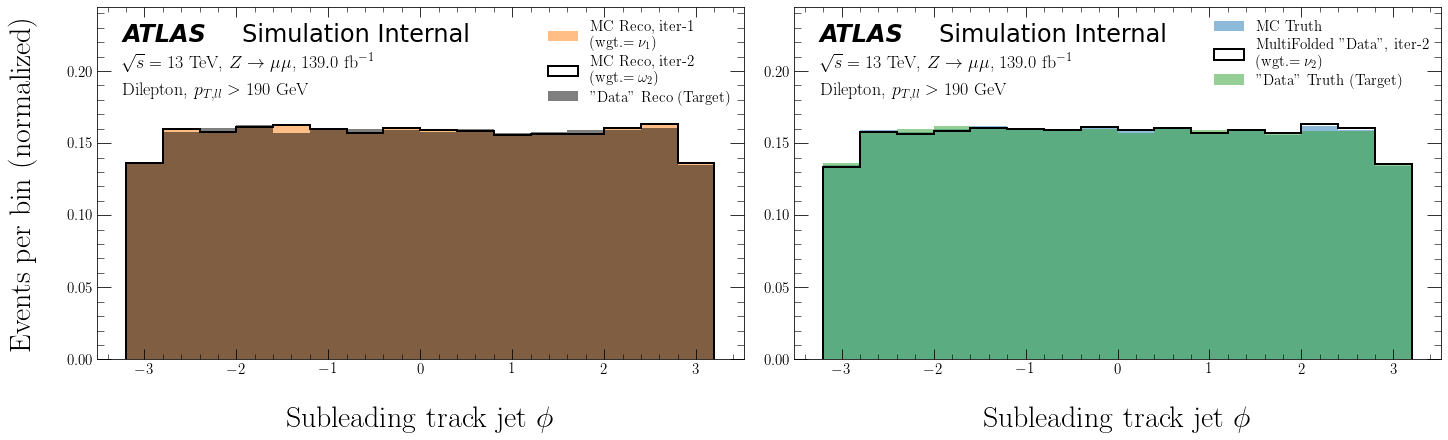

ITERATION 3:


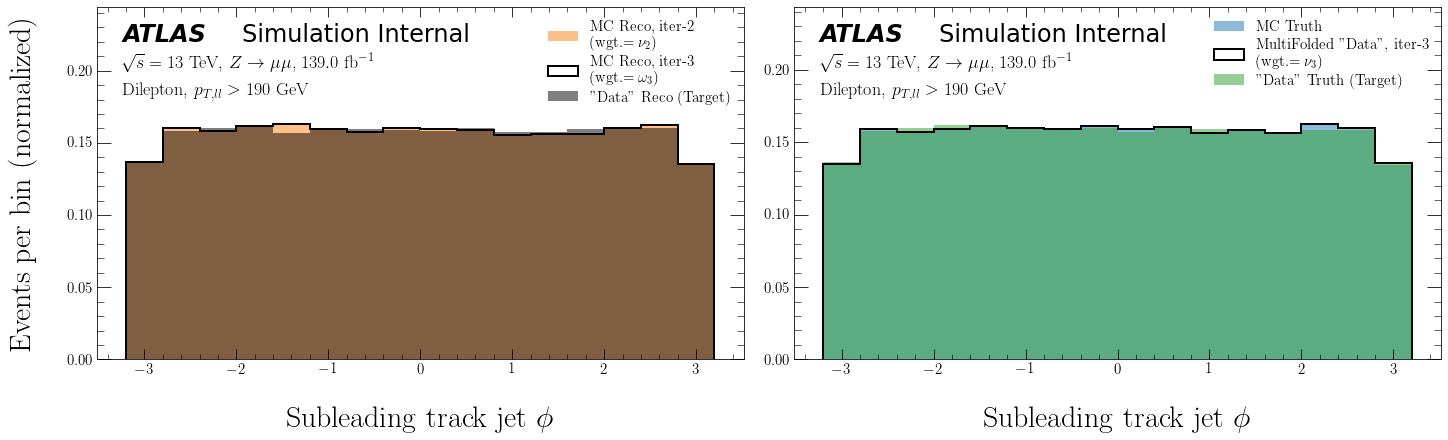

tau1_trackj1 Results

ITERATION 1:


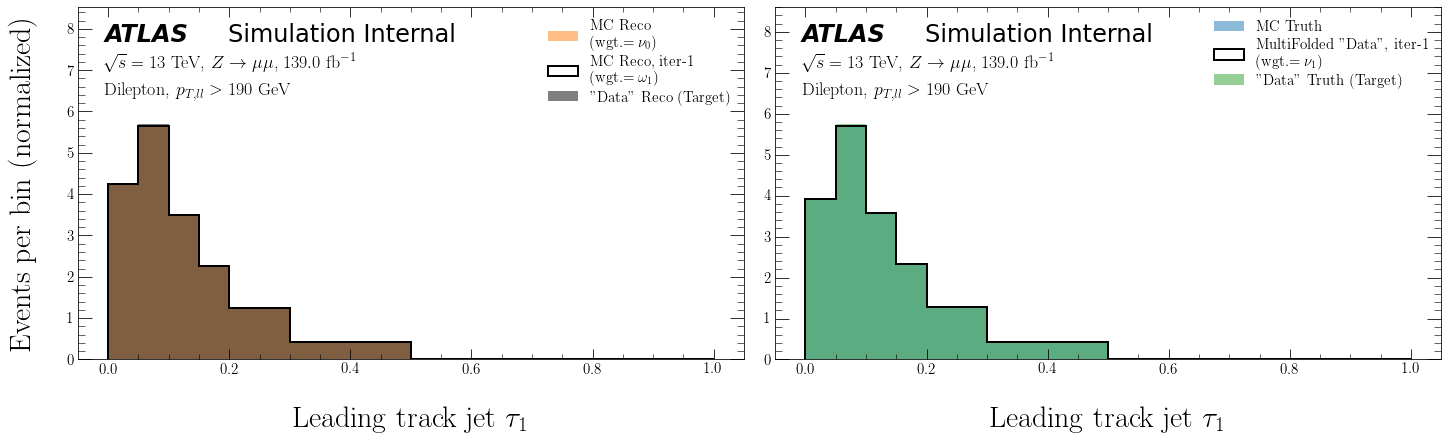

ITERATION 2:


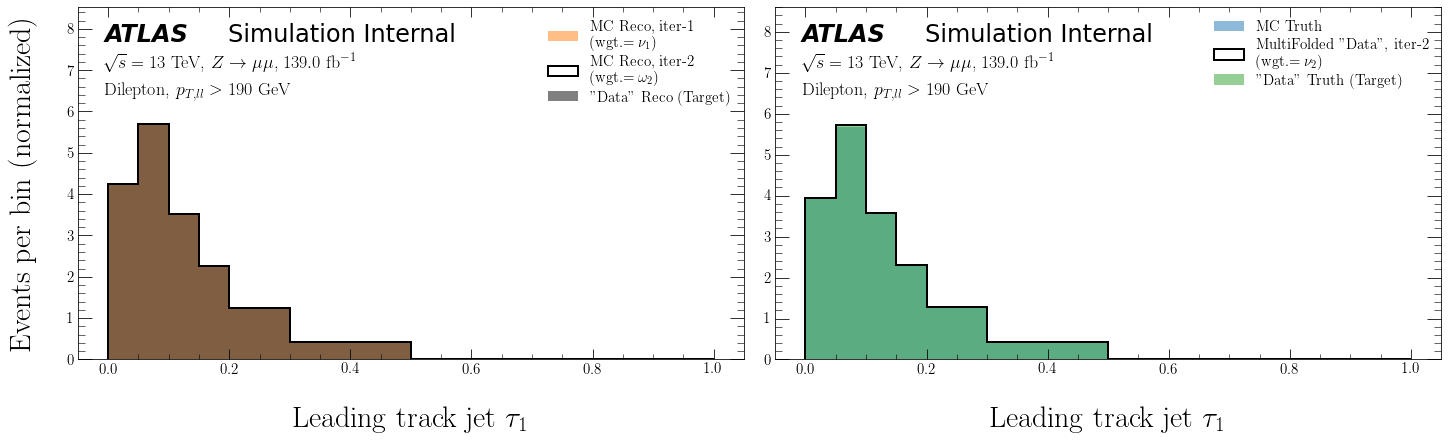

ITERATION 3:


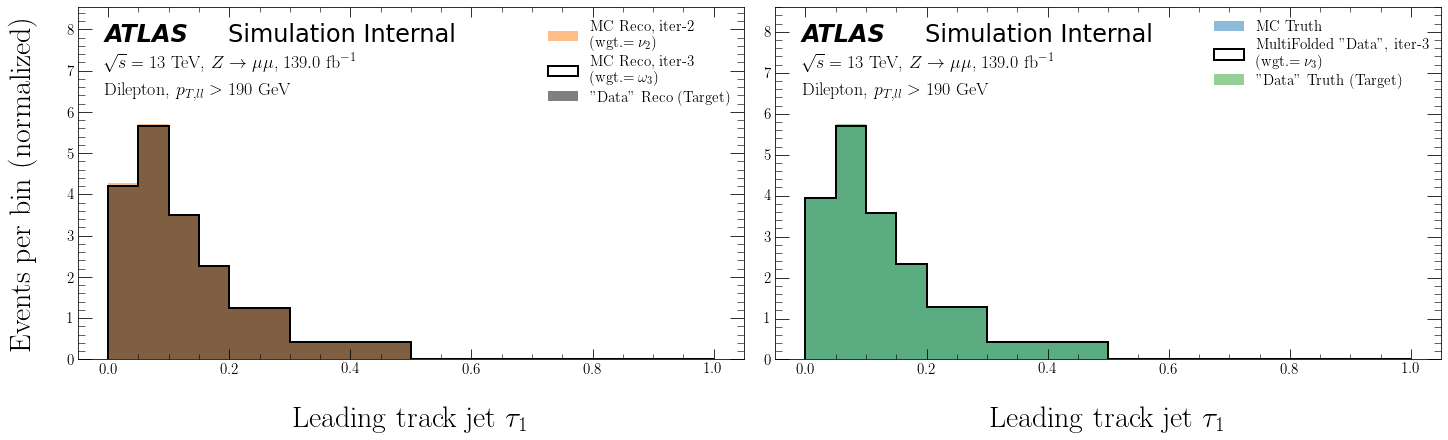

tau1_trackj2 Results

ITERATION 1:


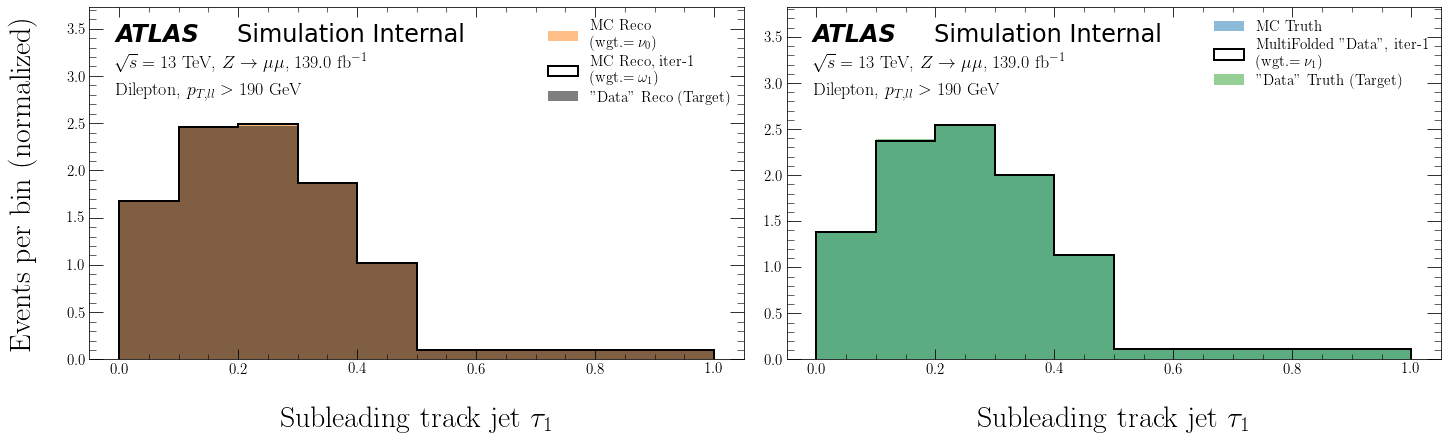

ITERATION 2:


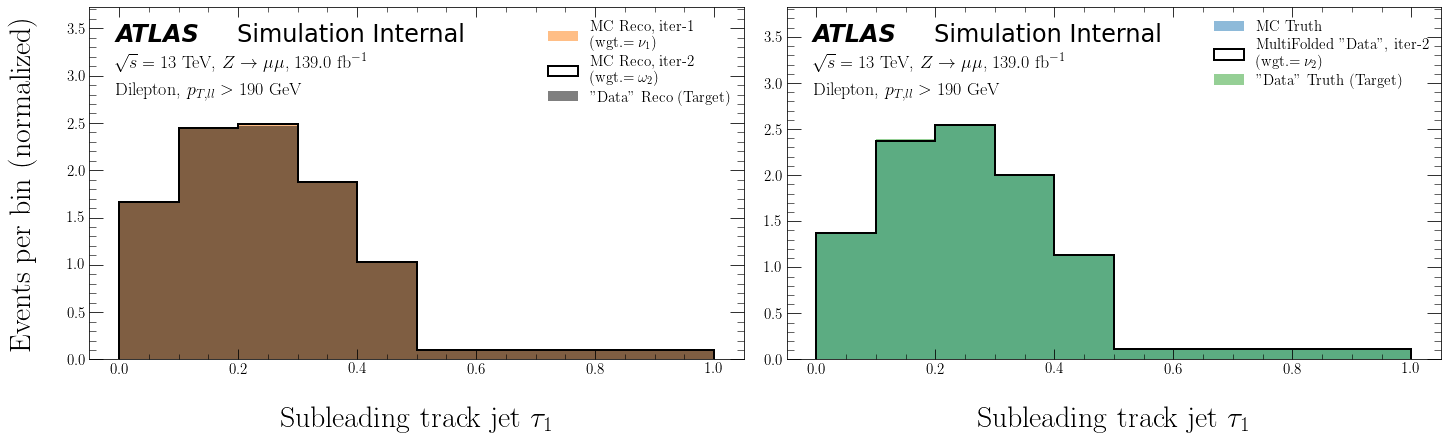

ITERATION 3:


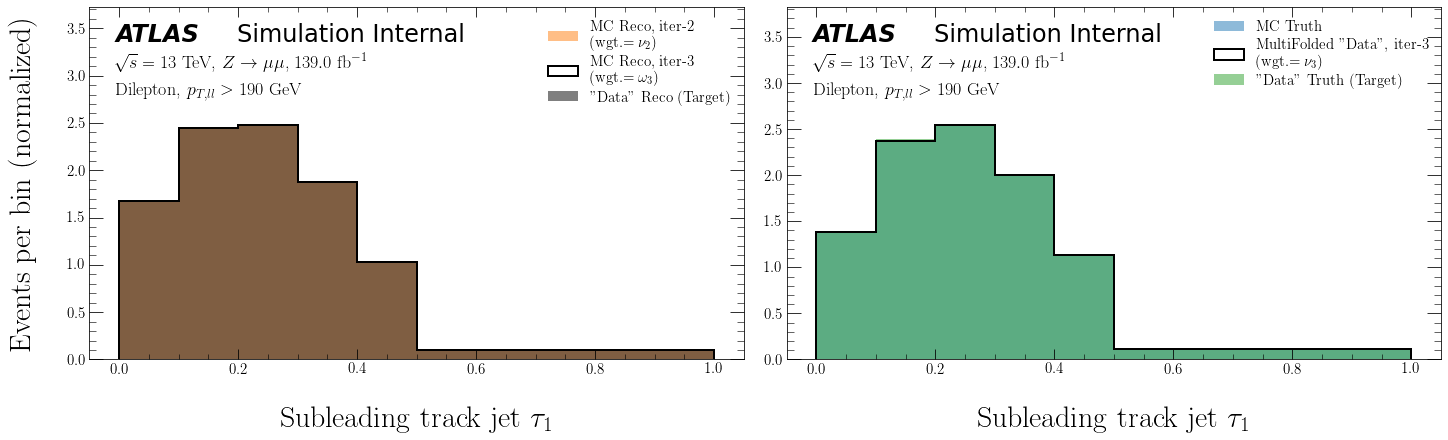

tau2_trackj1 Results

ITERATION 1:


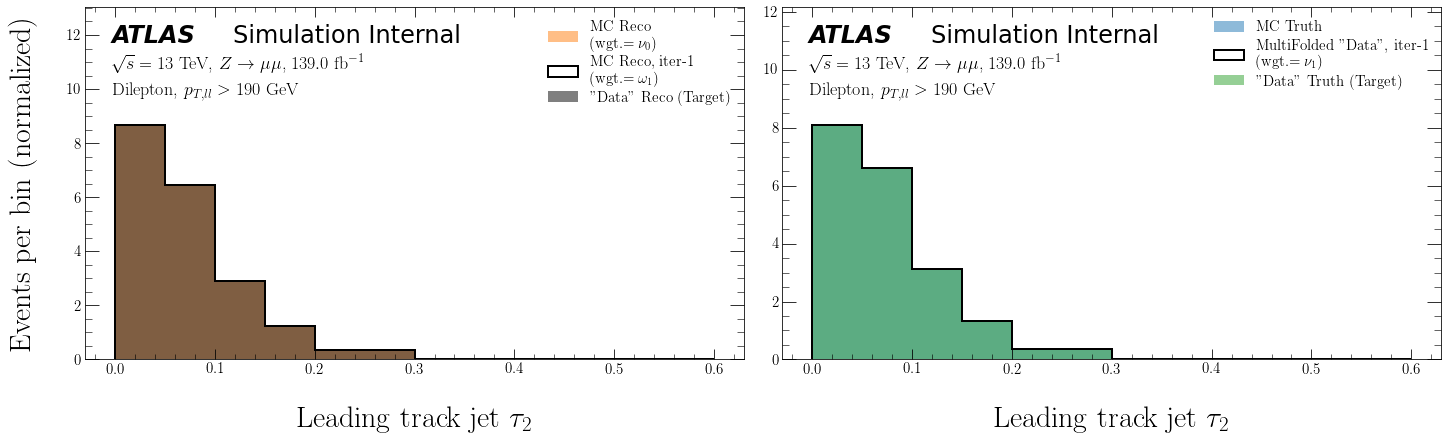

ITERATION 2:


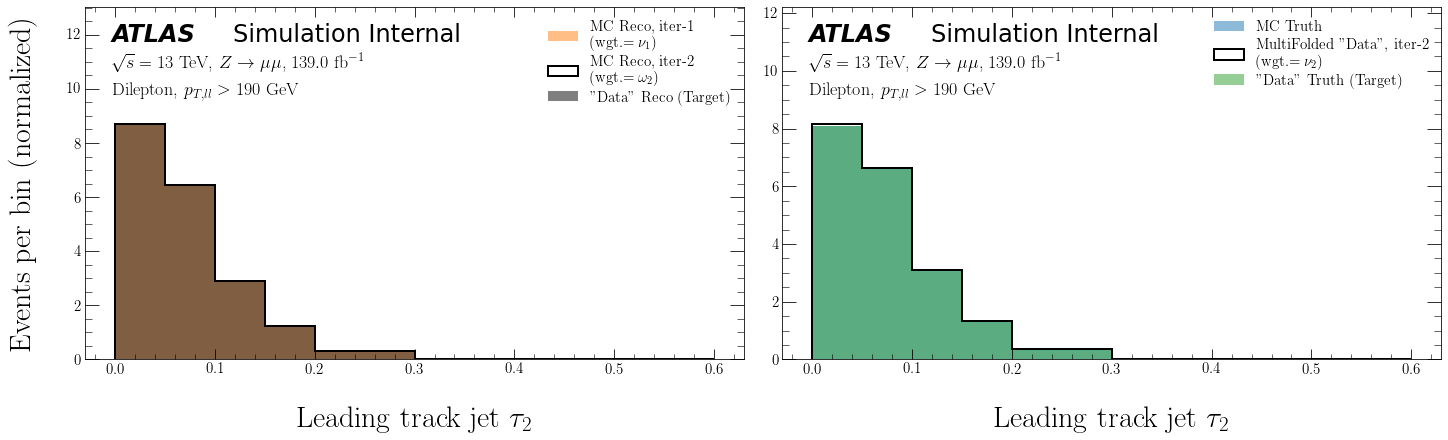

ITERATION 3:


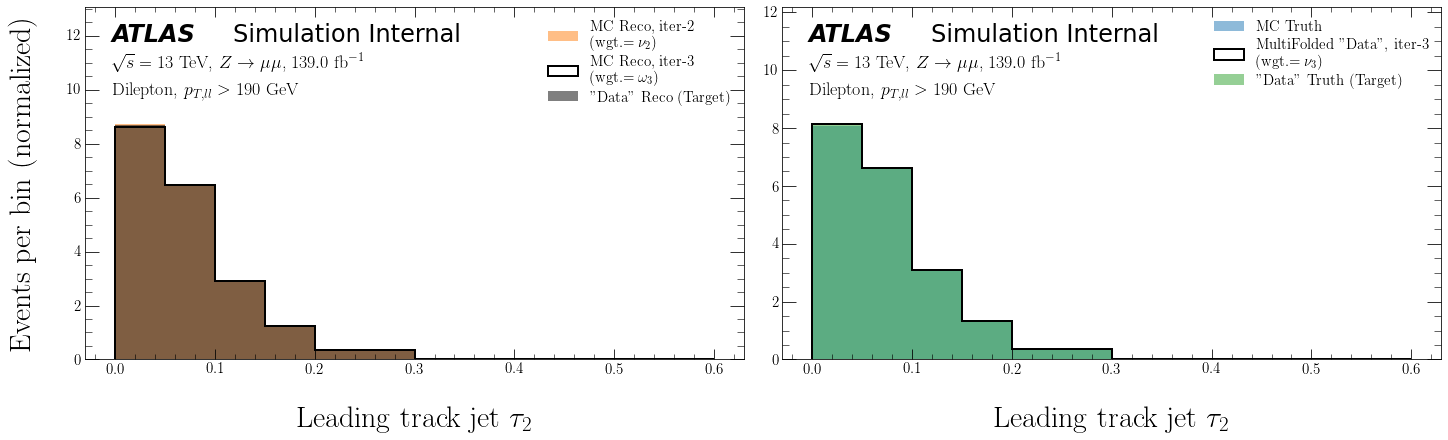

tau2_trackj2 Results

ITERATION 1:


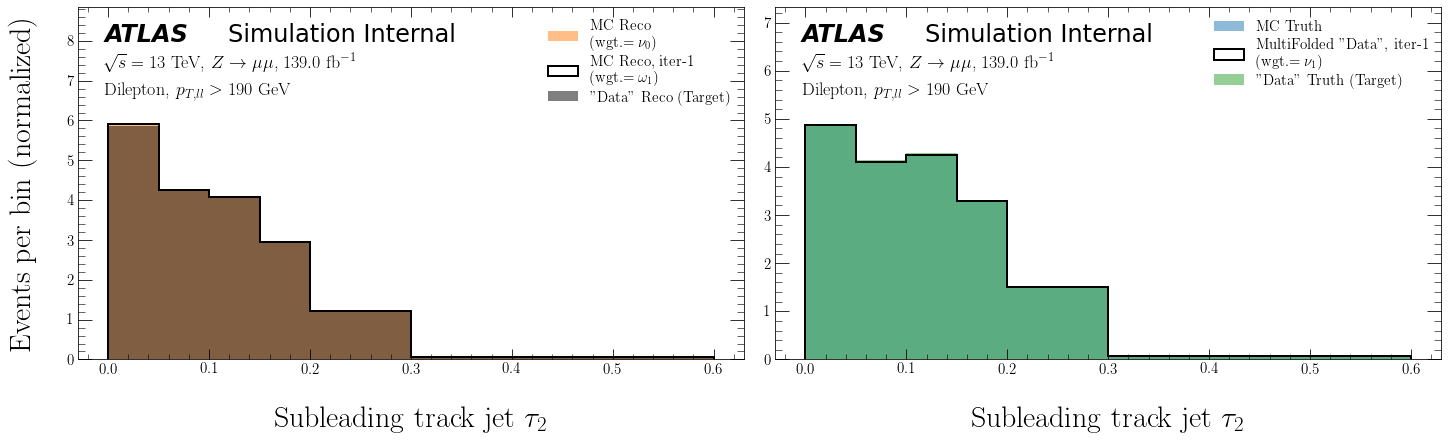

ITERATION 2:


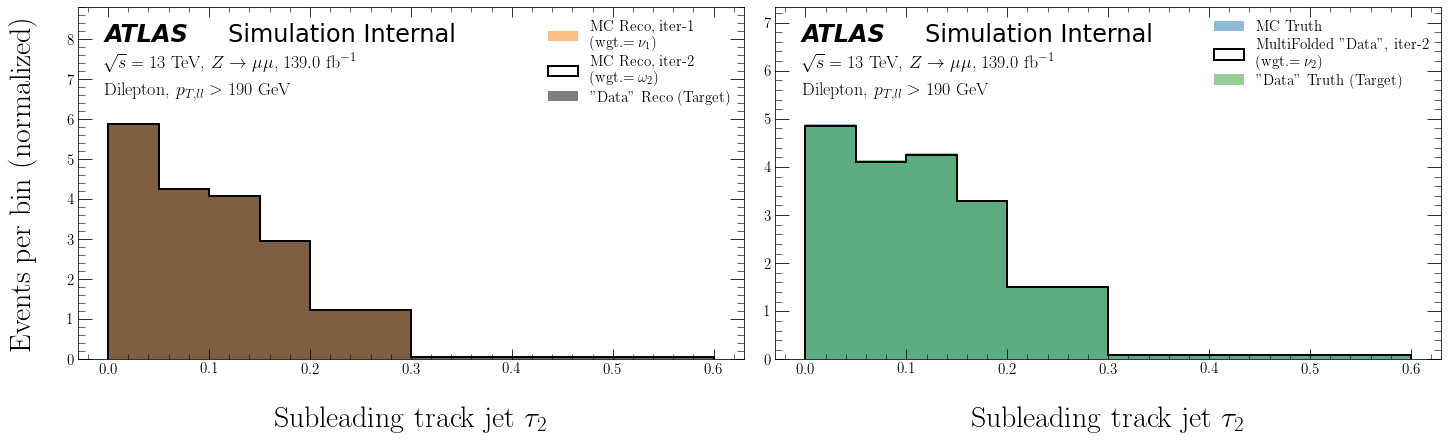

ITERATION 3:


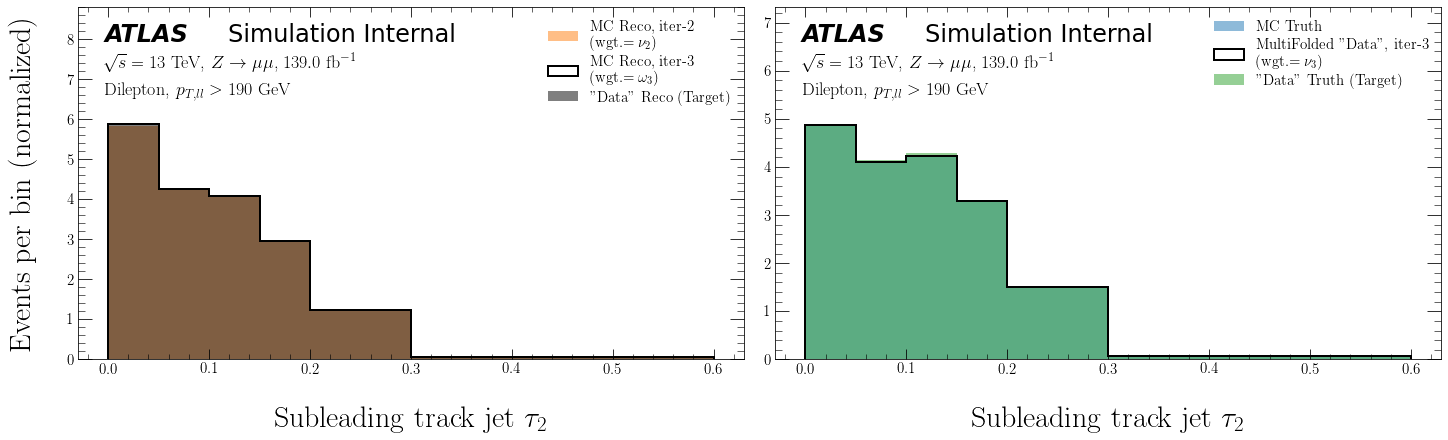

tau3_trackj1 Results

ITERATION 1:


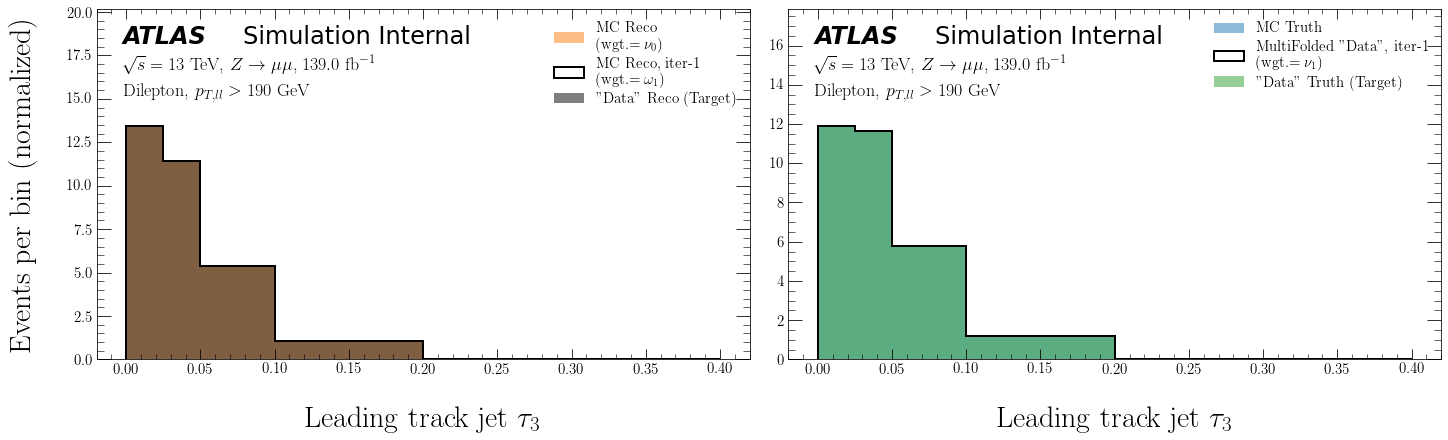

ITERATION 2:


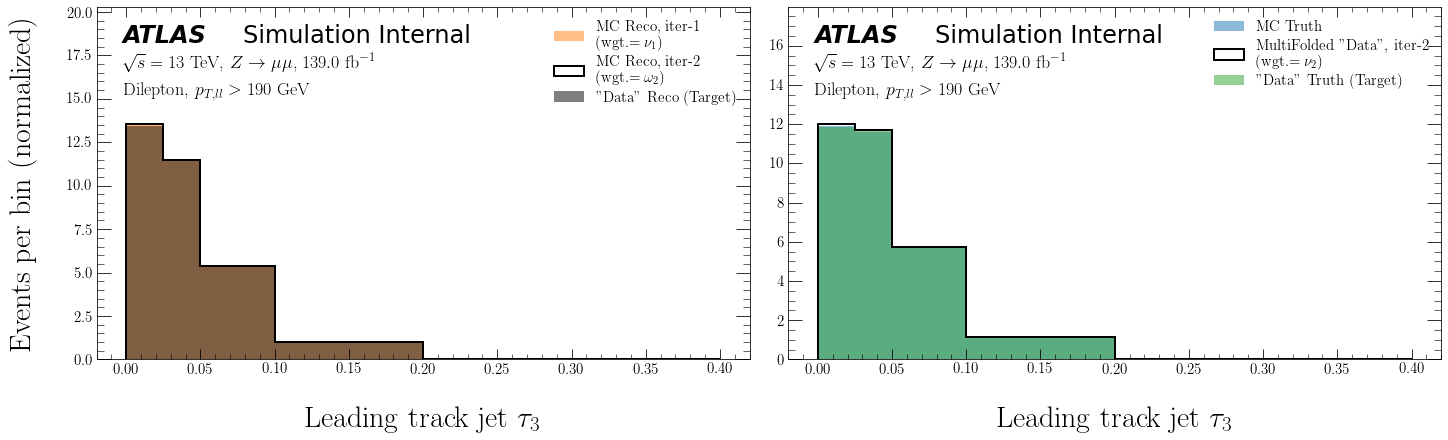

ITERATION 3:


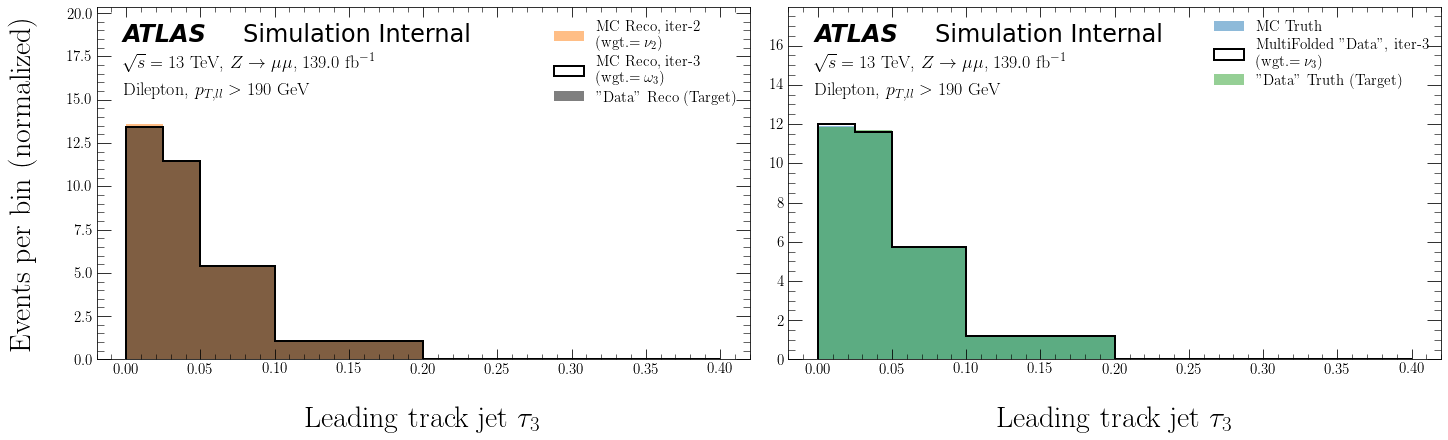

tau3_trackj2 Results

ITERATION 1:


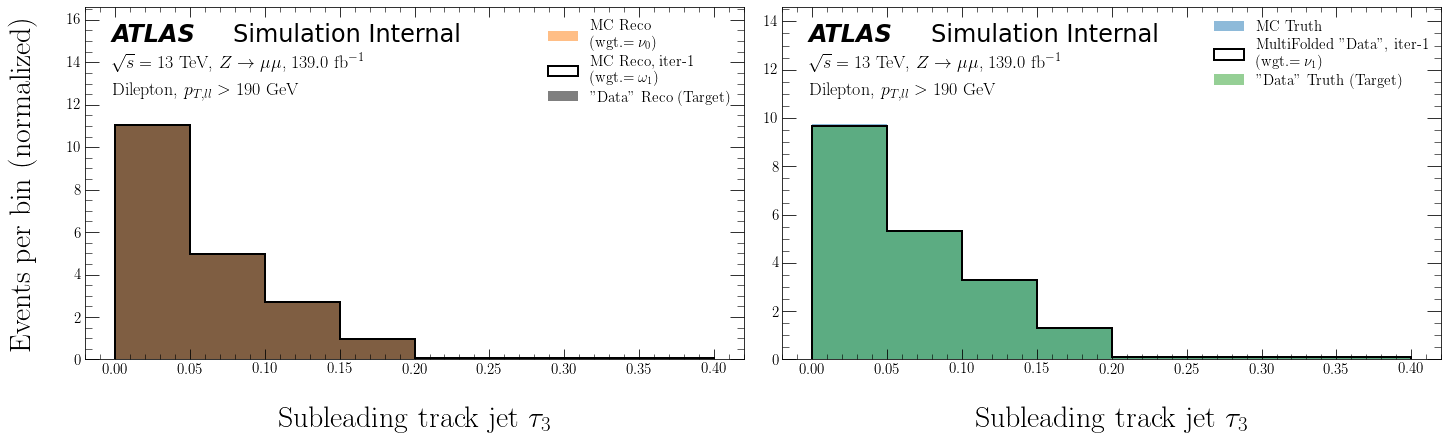

ITERATION 2:


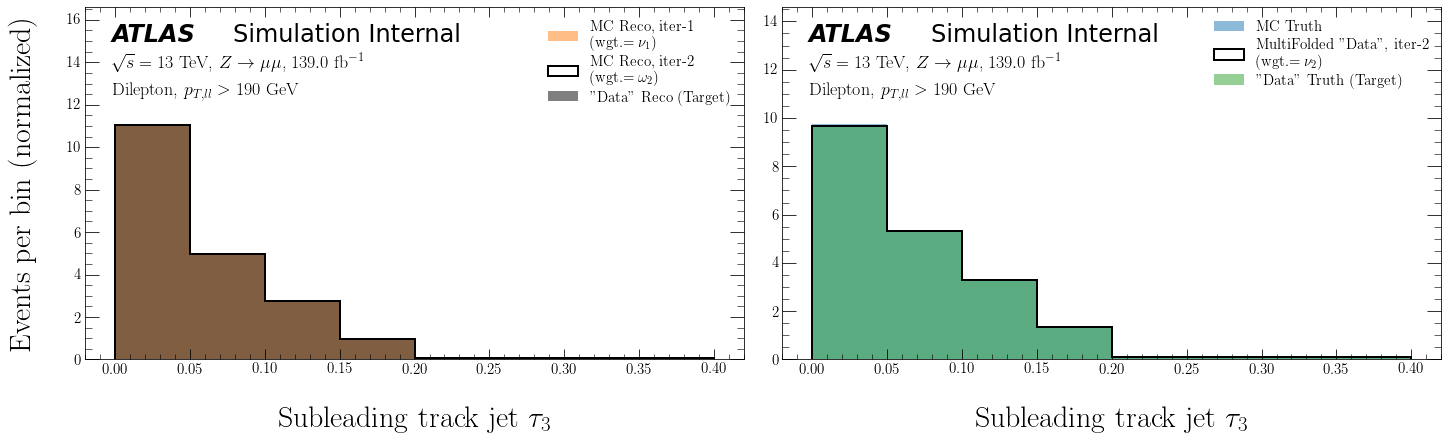

ITERATION 3:


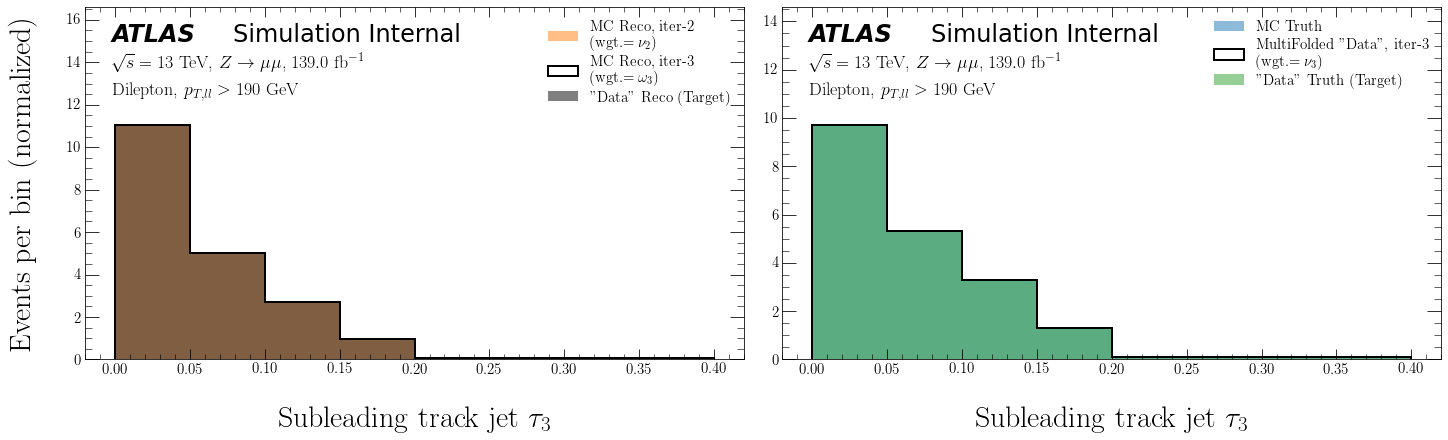

pT_ll Results

ITERATION 1:


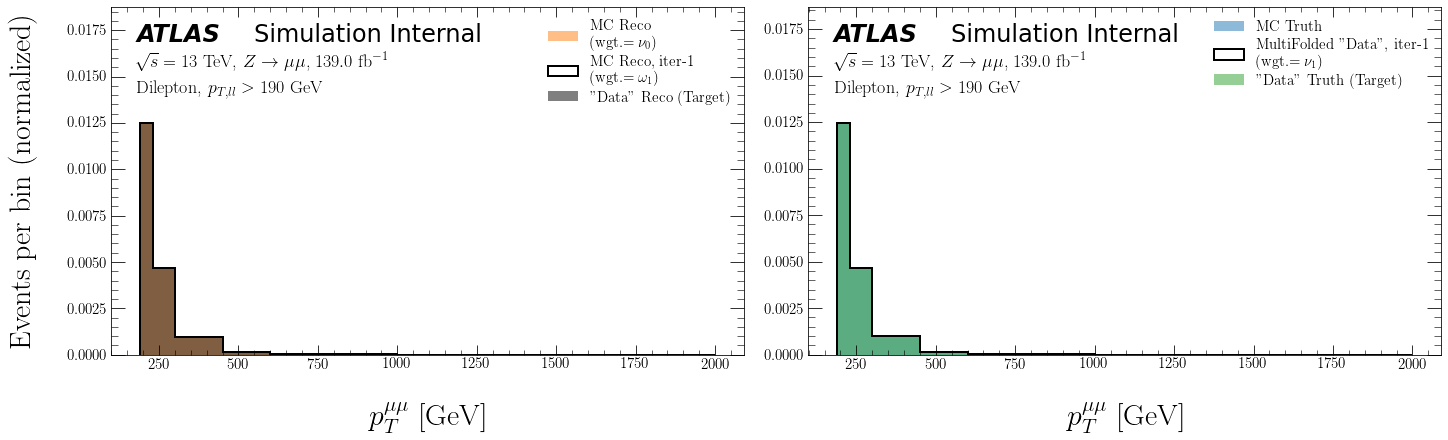

ITERATION 2:


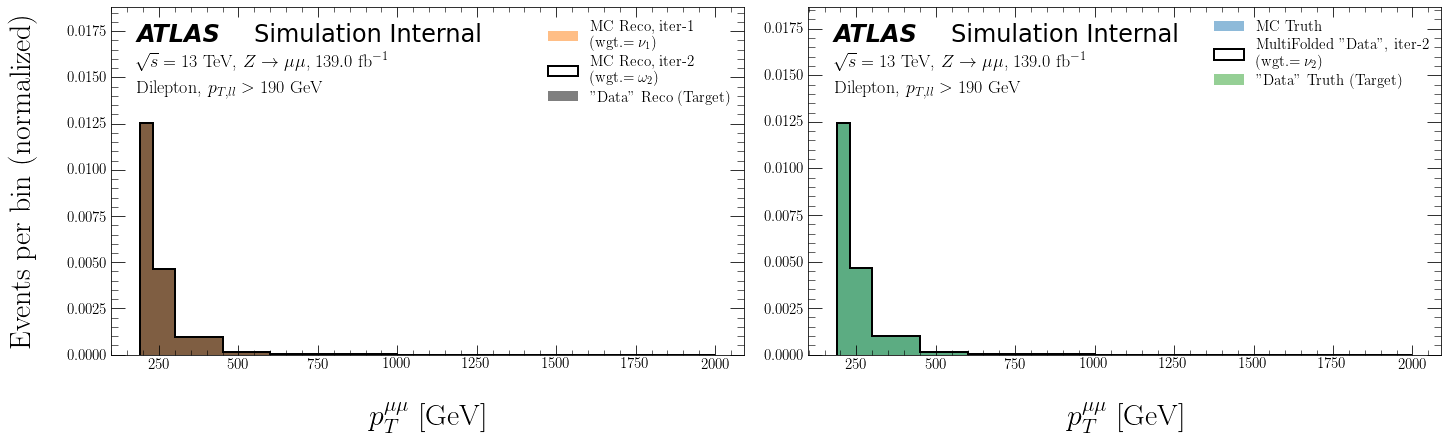

ITERATION 3:


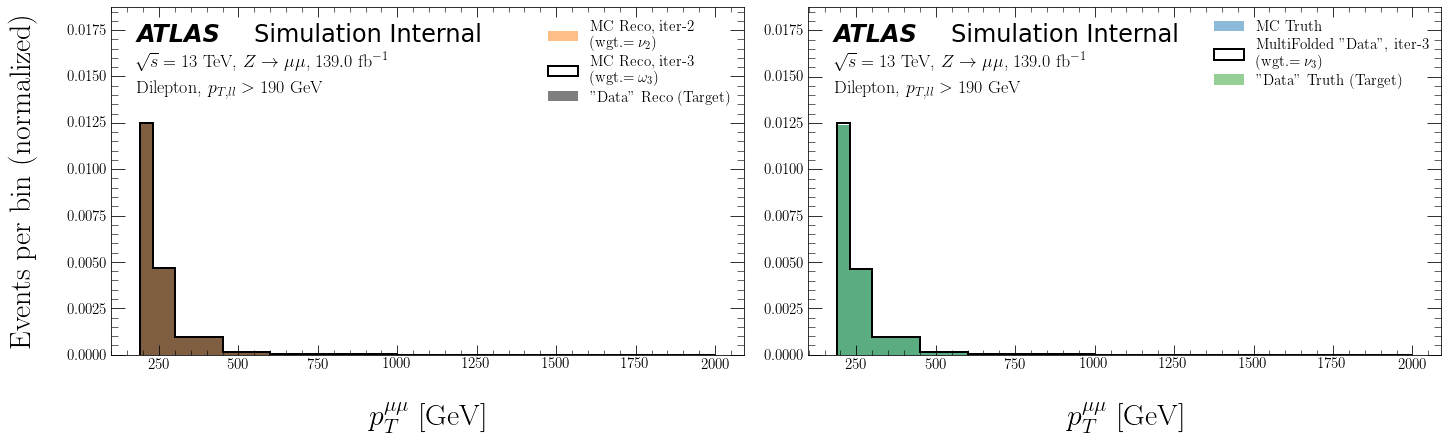

y_ll Results

ITERATION 1:


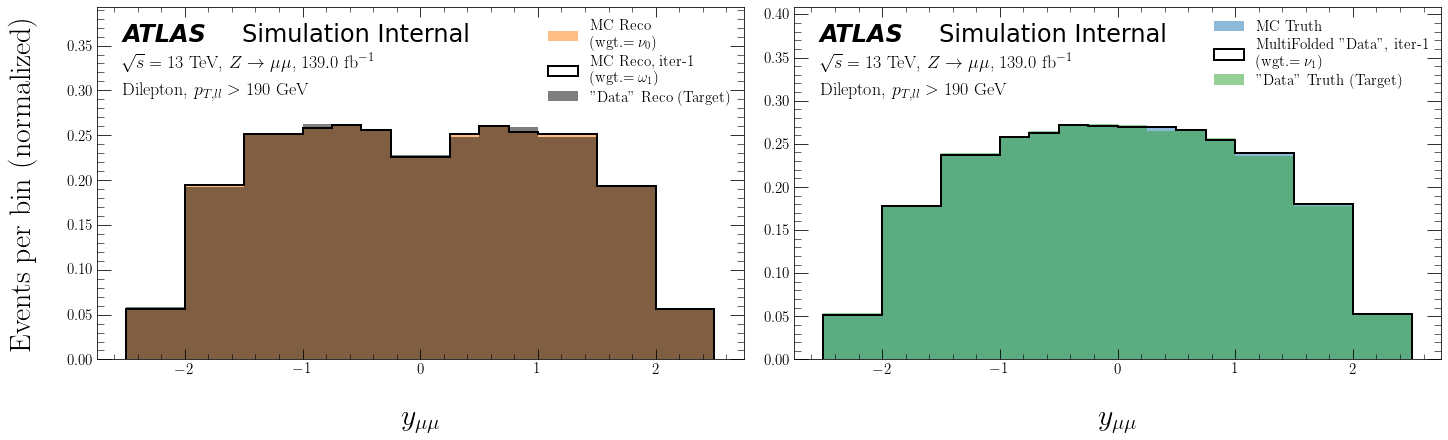

ITERATION 2:


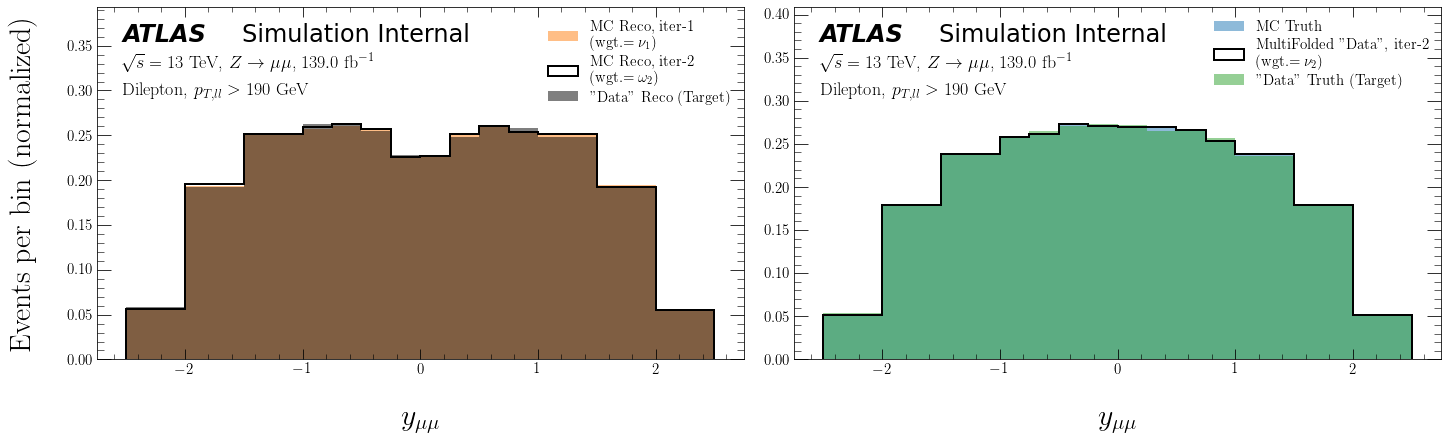

ITERATION 3:


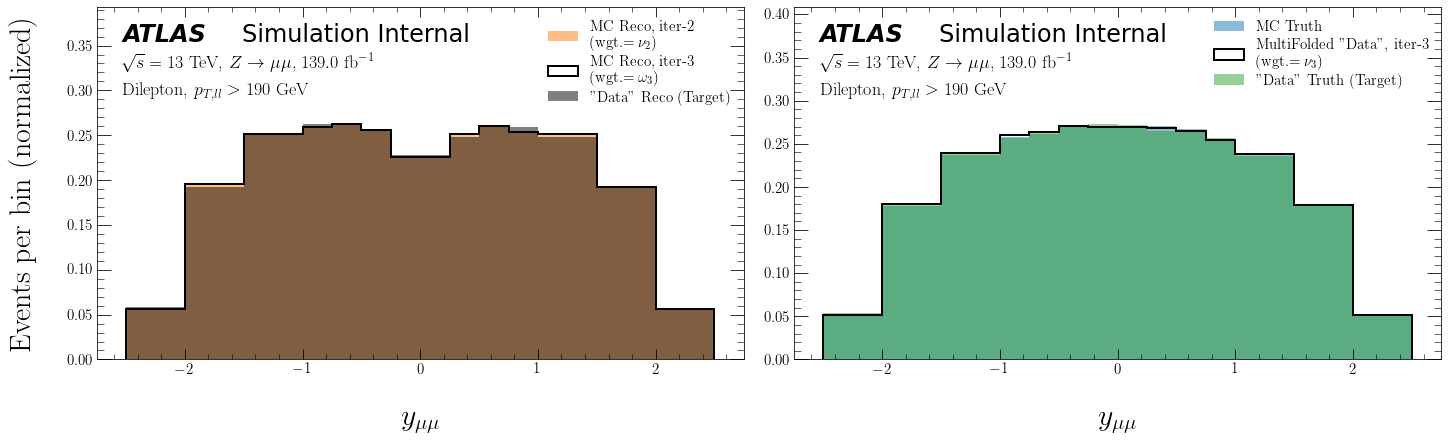

pT_l1 Results

ITERATION 1:


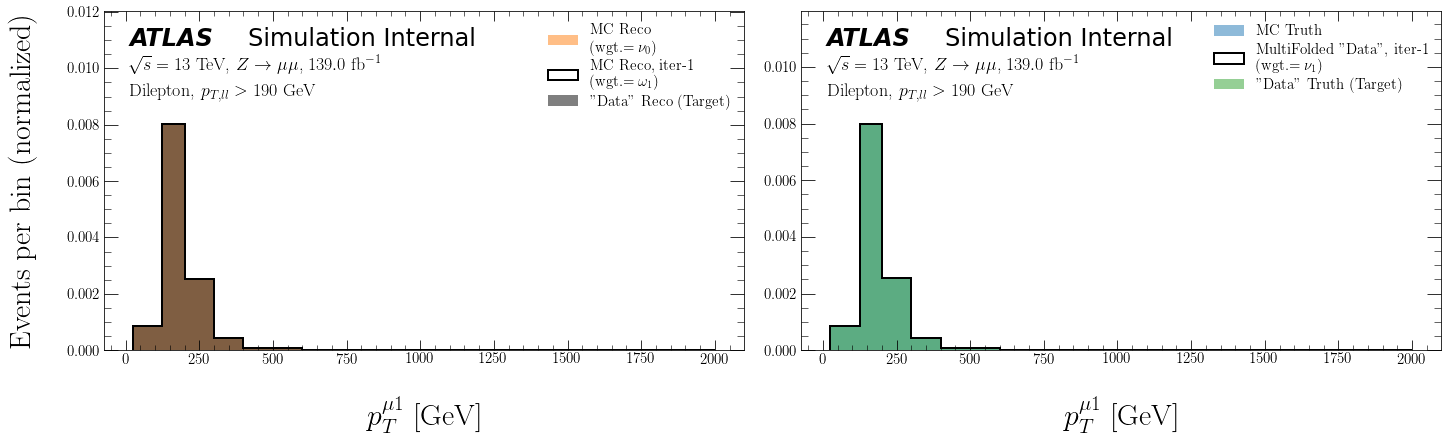

ITERATION 2:


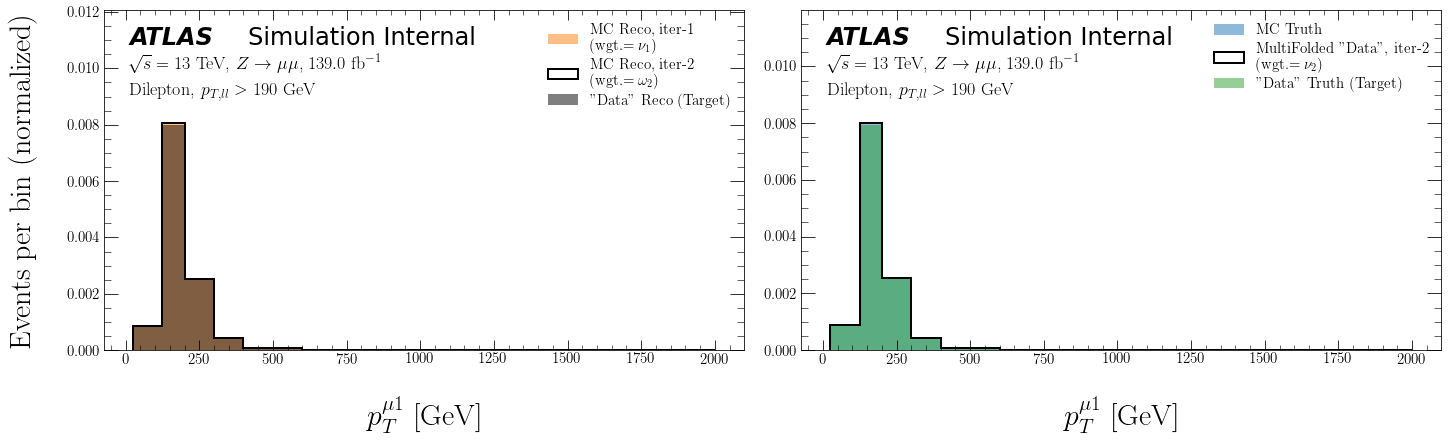

ITERATION 3:


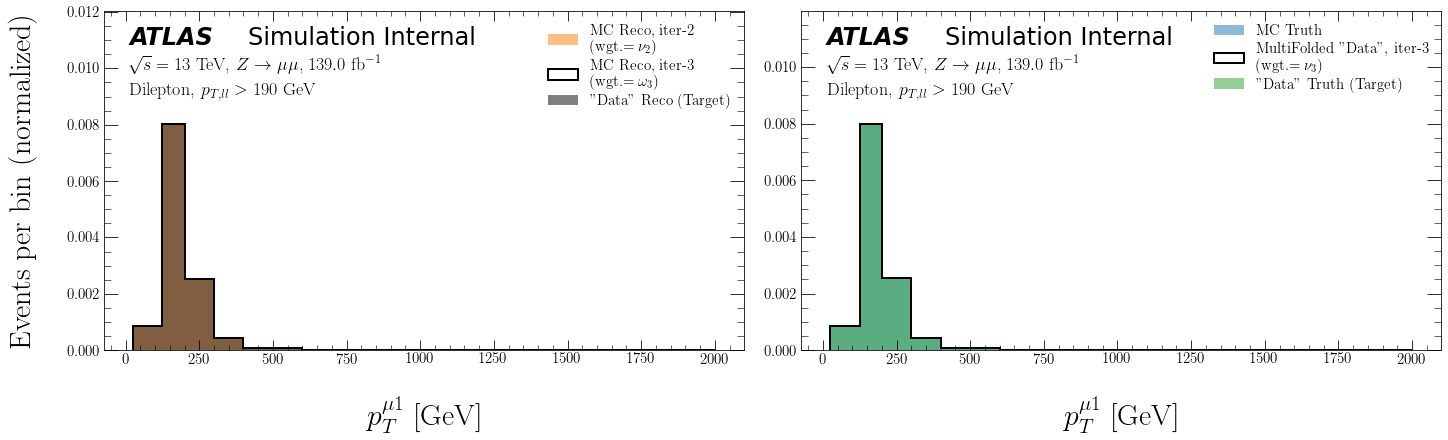

pT_l2 Results

ITERATION 1:


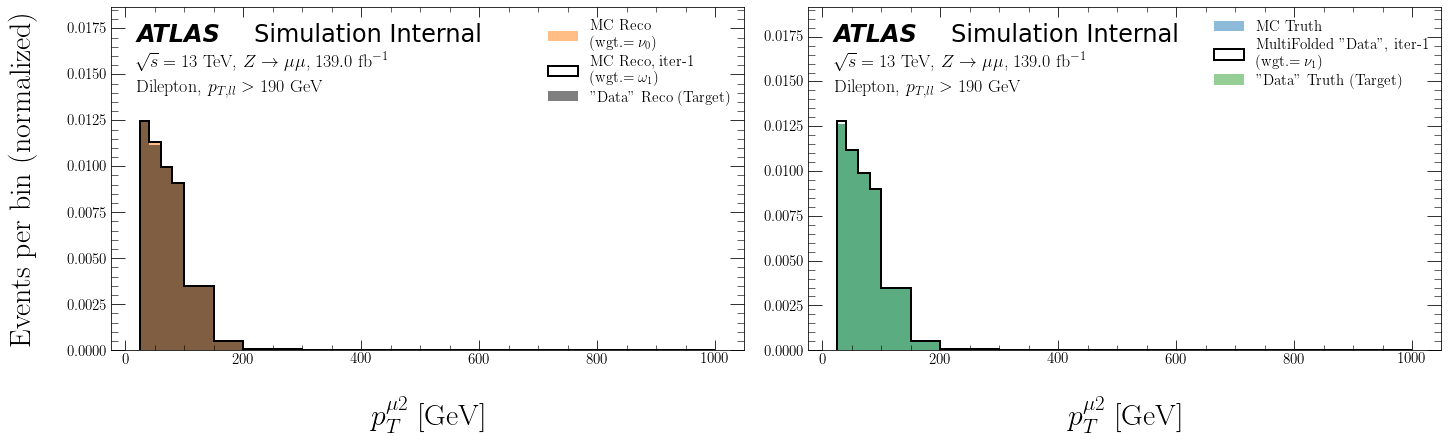

ITERATION 2:


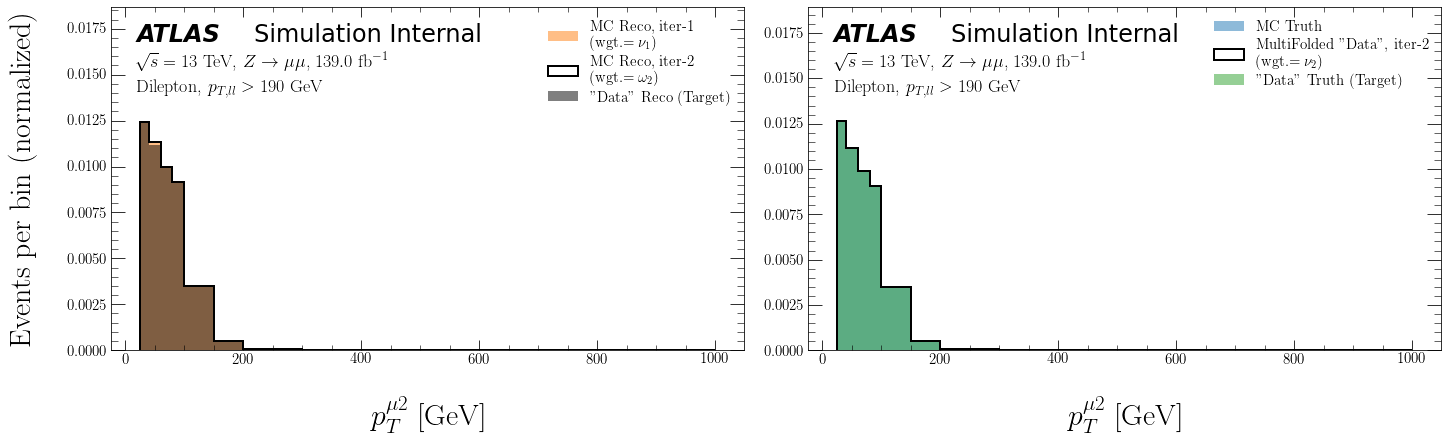

ITERATION 3:


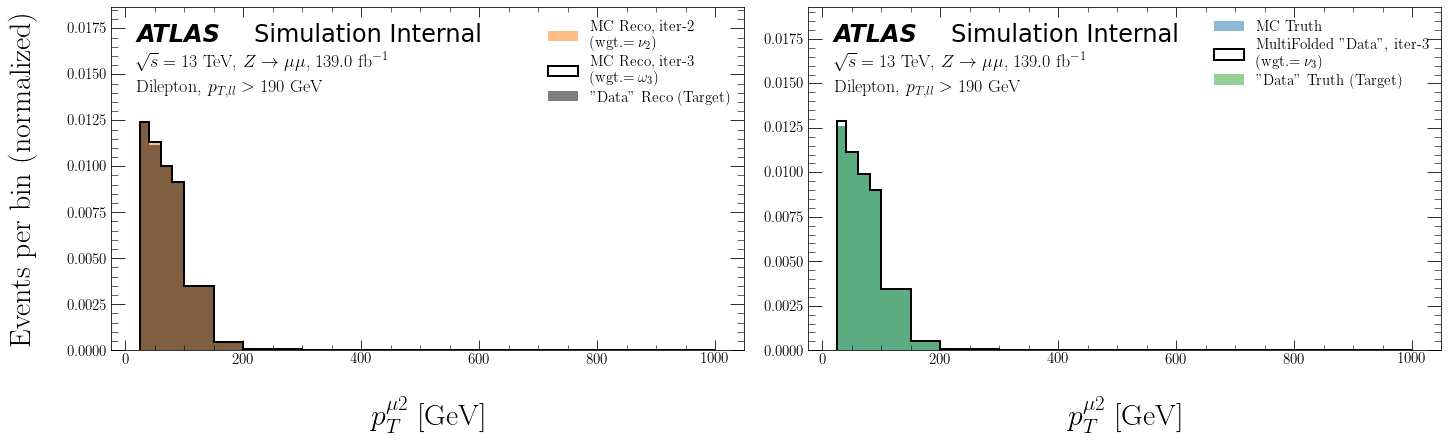

eta_l1 Results

ITERATION 1:


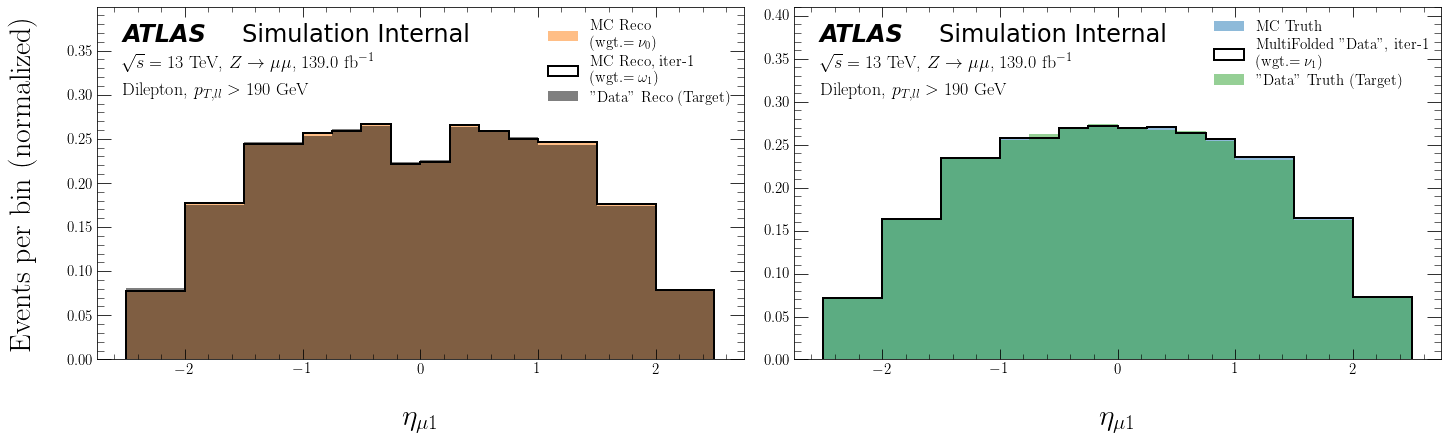

ITERATION 2:


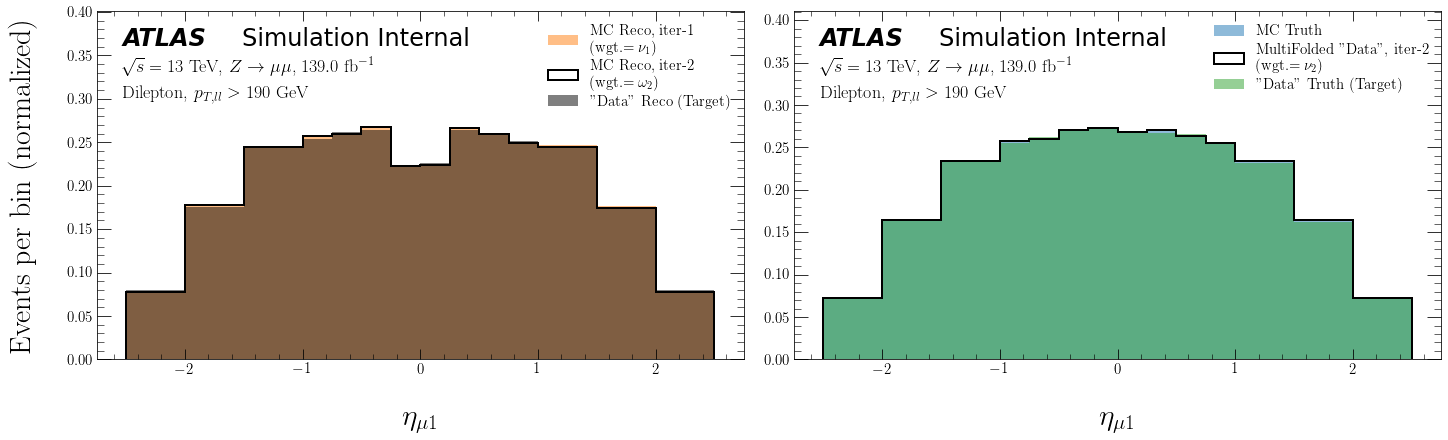

ITERATION 3:


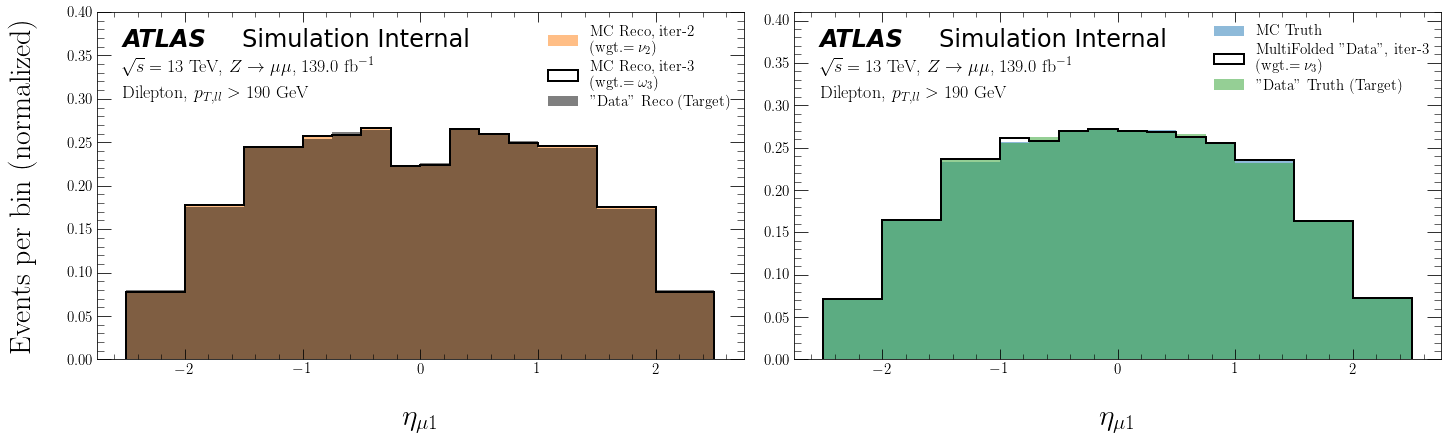

eta_l2 Results

ITERATION 1:


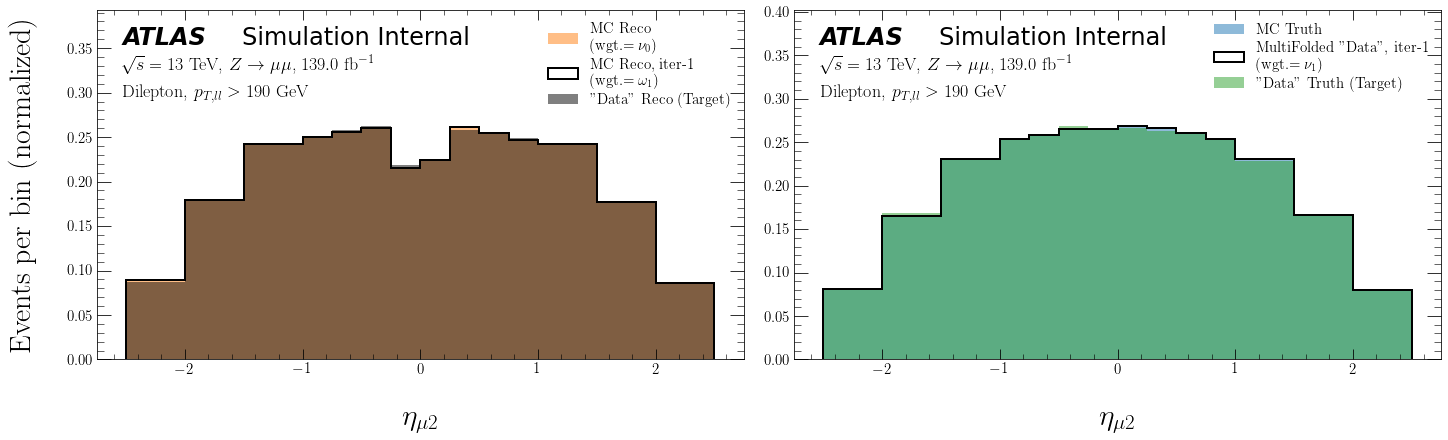

ITERATION 2:


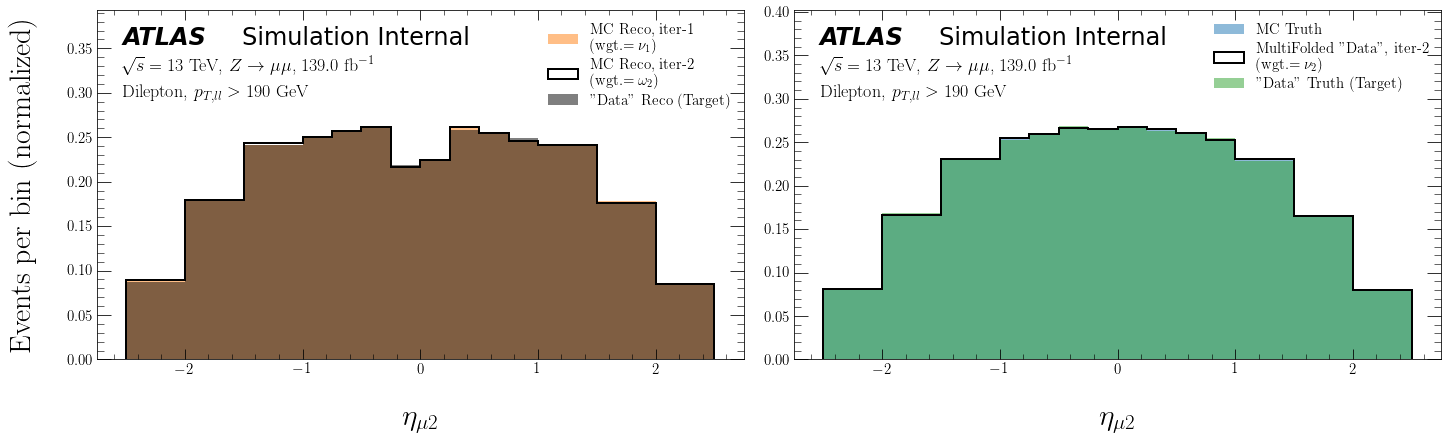

ITERATION 3:


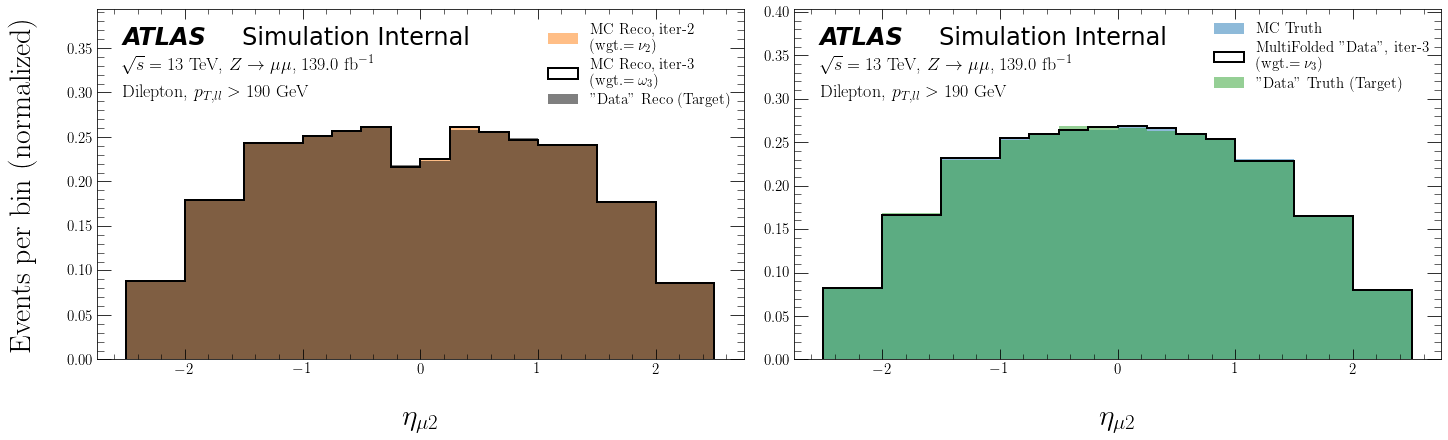

phi_l1 Results

ITERATION 1:


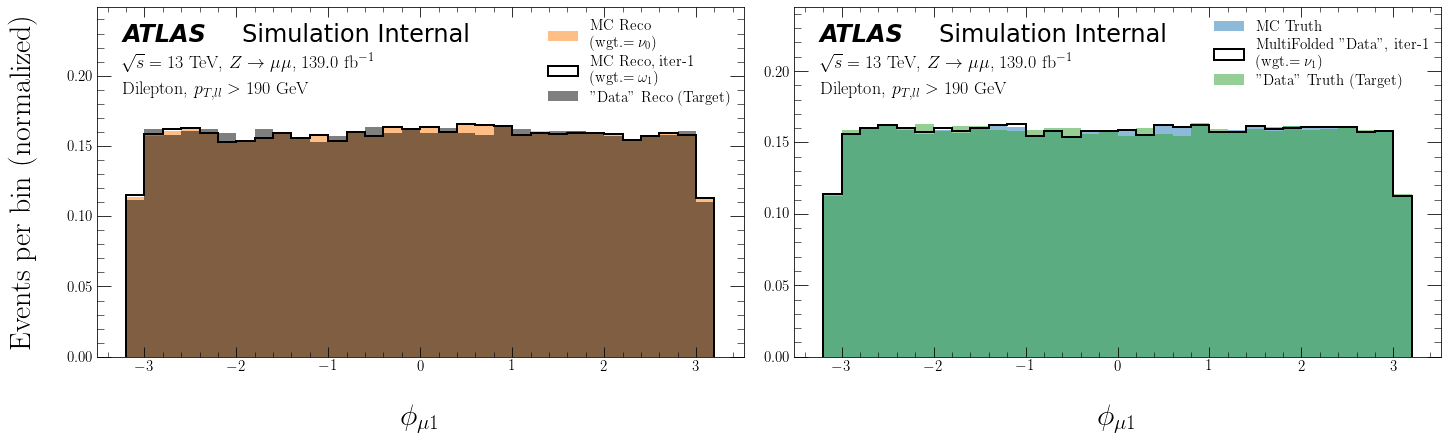

ITERATION 2:


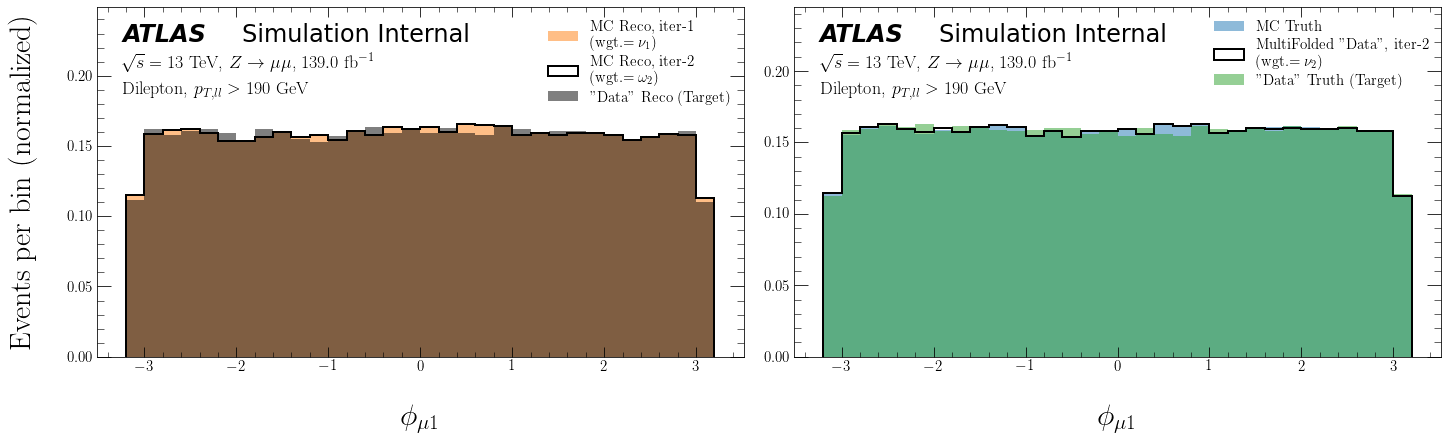

ITERATION 3:


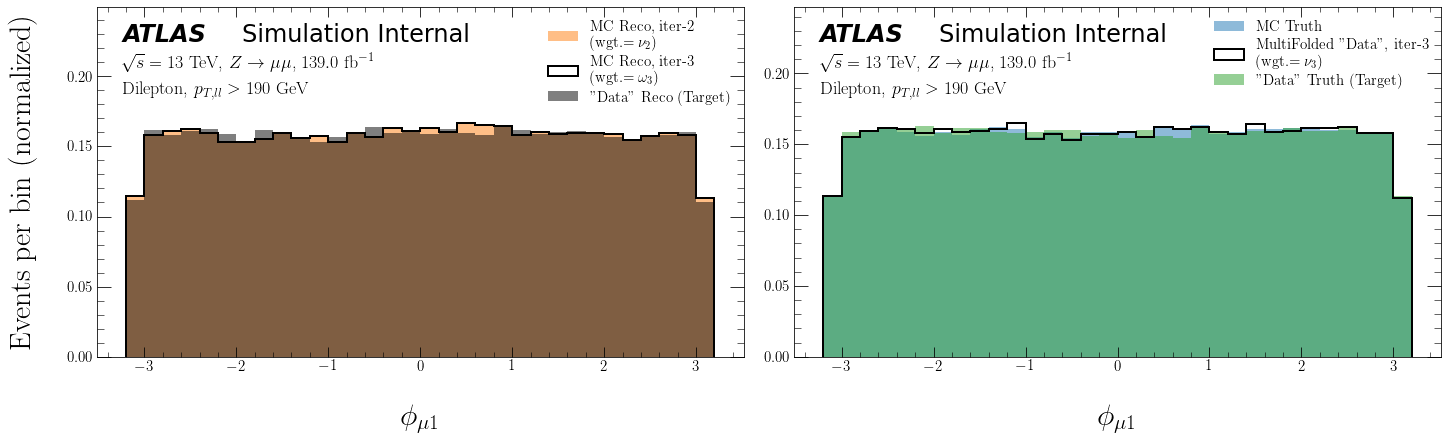

phi_l2 Results

ITERATION 1:


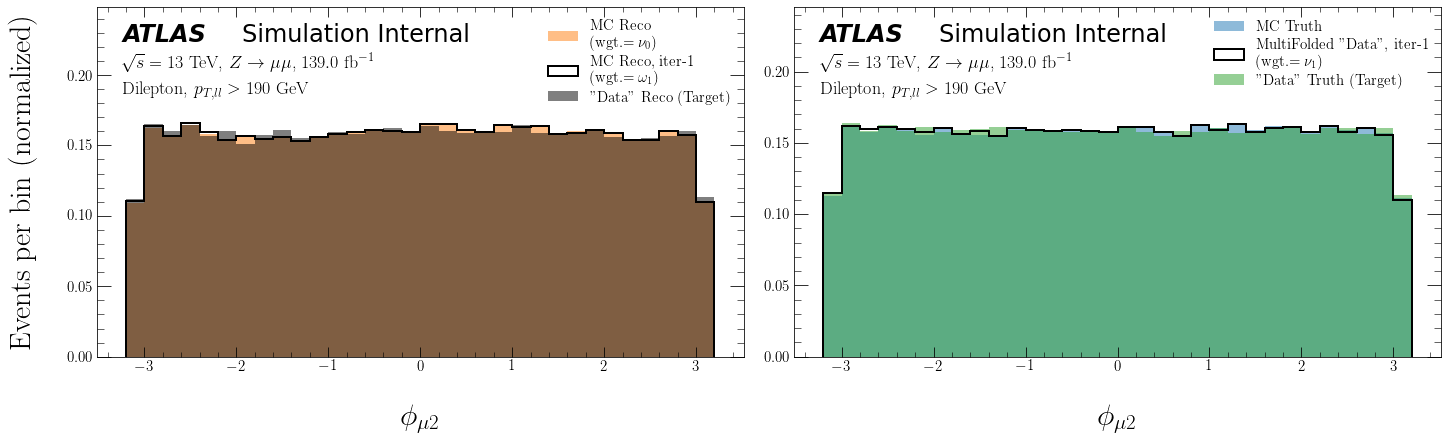

ITERATION 2:


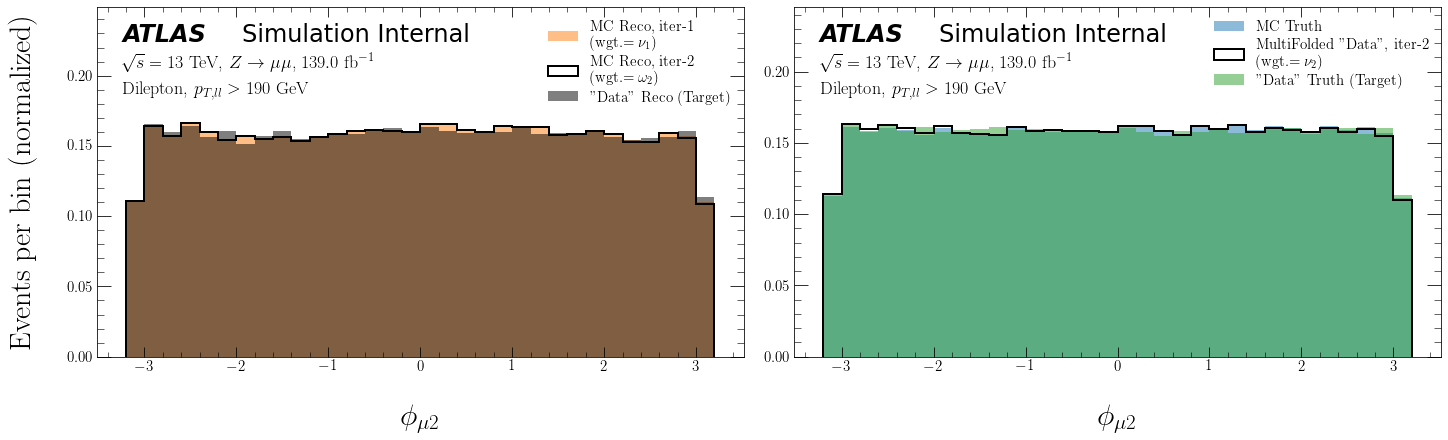

ITERATION 3:


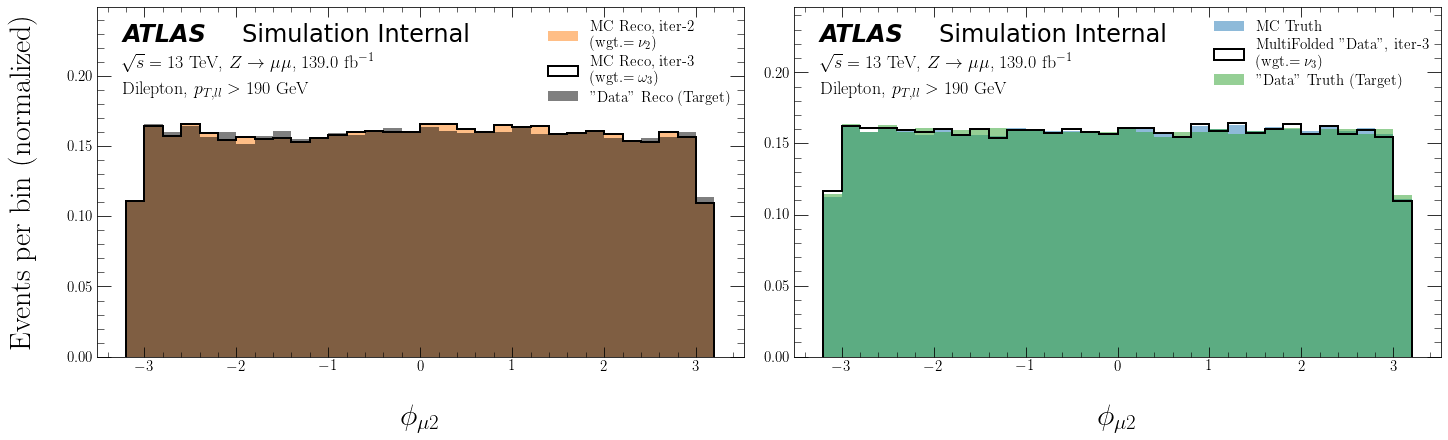

In [67]:
for i in range(len(obs)):
    print(obs[i]['file_label'] + " Results\n")
    bins = obs[i]['bins']
    x_label = obs[i]['plot_label']
    file_label = obs[i]['file_label']
    save_label = plot_dir + '/MultiFold/' + file_label + '/' + save_label0 + '-MultiFold-' + file_label

    plot_results(sim_truth=sim_truth[i],
                 sim_reco=sim_reco[i],
                 sim_truth_weights_MC=sim_truth_weights_MC,
                 sim_reco_weights_MC=sim_reco_weights_MC,
                 data_truth=data_truth[i],
                 data_reco=data_reco[i],
                 data_truth_weights_MC=data_truth_weights_MC,
                 data_reco_weights_MC=data_reco_weights_MC,
                 weights=weights,
                 bins=bins,
                 x_label=x_label,
                 flavor_label='MultiFold',
                 save_label=save_label)